In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

# Load datasets
#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TRAIN_DATA_PARIS.csv'
#full_train_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/Train_model_Paris_Vince.csv'
full_train_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_VALID_DATA_PARIS.csv'
#full_valid_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/Valid_model_Paris_Vince.csv'
full_valid_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TEST_DATA_PARIS.csv'
#full_test_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/Test_model_Paris_Vince.csv'
full_test_data = pd.read_csv(file_path)

Functie om een sample uit de volledige dataset te nemen. De functie neemt een x aantal gespecifieerde unieke id's en haalt alle rijen van die id's uit de dataset. Dit is gedaan om vereiste rekenkracht van de modellen iets naar beneden te halen. Deze functie is niet meer nodig aangezien de dataset al is aangepast maar ik hou het er nog even in just in case

In [4]:


# Sampling function
def sample_locations(data, num_locations):
    unique_ids = data[['id']].drop_duplicates()
    sampled_ids = unique_ids.sample(n=num_locations, random_state=42)
    return data.merge(sampled_ids, on=['id'])

# Sample locations
train_num_locations = 6000
val_num_locations = 2000
test_num_locations = 2000

#train_data = sample_locations(full_train_data, train_num_locations)
#val_data = sample_locations(full_valid_data, val_num_locations)
#test_data = sample_locations(full_test_data, test_num_locations)

train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Clear memory
#del full_train_data, full_valid_data, full_test_data
#gc.collect()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 539826 entries, 1278 to 536713
Columns: 142 entries, id to kitchen_amenities
dtypes: bool(103), datetime64[ns](1), float64(15), int64(23)
memory usage: 217.8 MB


LSTM model
Hier wordt het LSTM model gemaakt. Enkel de 'id', 'date' en 'price' kolommen worden hier gebruikt. Het model creëert dan sequences van de historische prijzen om zo temporal features te leren die kunnen bijdragen aan de predictive performance. Het model wordt ook gehyperparameter tuned met Optuna. Twee extra variabelen die mee getuned worden, naast de hyperparameters van het LSTM model zelf, zijn 'sequence_length' en 'max_instances_per_location'. De sequence length bepaald hoe groot de price sequences zijn om features uit te leren. De max_instances_per_location neemt een x aantal random historische prijzen per unieke locatie, aangezien alle historische prijzen gebruiken wederom teveel computerkracht vereiste. De geleerde features worden gextraheerd en het model wordt opgeslagen om later hergebruikt te kunnen worden. De max instances per location wordt op 100 vastgezet aangezien dit ook al is aangepast in de dataset maar wordt wederom nog even bijgehouden just in case

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length]['price'])  # Ensure the correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 3, 7)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1)))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32)))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True)(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2)(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mae'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_PARIS_2.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_PARIS_2.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Load the model later for reuse
# loaded_model = load_model(final_model_path)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_2.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


[I 2024-07-30 21:13:24,383] A new study created in memory with name: no-name-a6602e42-c6be-4ff5-9eef-bd3835e07d09
Creating sequences: 100%|██████████| 2000/2000 [00:13<00:00, 150.68it/s]
<ipython-input-5-5d1cd3e3ccc5>:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2024-07-30 21:32:33,430] Trial 0 finished with value: 0.007964802905917168 and parameters: {'sequence_length': 6, 'max_instances_per_location': 100, 'units1': 64, 'dropout1': 0.2, 'units2': 96, '

Epoch 1/25
15553/15553 [==============================] - 112s 7ms/step - loss: 0.0598 - mae: 0.0731 - val_loss: 0.0069 - val_mae: 0.0202
Epoch 2/25
15553/15553 [==============================] - 107s 7ms/step - loss: 0.0556 - mae: 0.0695 - val_loss: 0.0065 - val_mae: 0.0186
Epoch 3/25
15553/15553 [==============================] - 108s 7ms/step - loss: 0.0550 - mae: 0.0689 - val_loss: 0.0076 - val_mae: 0.0226
Epoch 4/25
15553/15553 [==============================] - 106s 7ms/step - loss: 0.0547 - mae: 0.0685 - val_loss: 0.0063 - val_mae: 0.0196
Epoch 5/25
15553/15553 [==============================] - 107s 7ms/step - loss: 0.0547 - mae: 0.0678 - val_loss: 0.0062 - val_mae: 0.0138
Epoch 6/25
15553/15553 [==============================] - 107s 7ms/step - loss: 0.0542 - mae: 0.0674 - val_loss: 0.0070 - val_mae: 0.0255
Epoch 7/25
15553/15553 [==============================] - 105s 7ms/step - loss: 0.0541 - mae: 0.0668 - val_loss: 0.0067 - val_mae: 0.0227
Epoch 8/25
15553/15553 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1436/1436 [==============================] - 5s 3ms/step


LSTM Model
Het LSTM model kan hier terug ingeladen worden

In [11]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_FEATURES_PARIS_2.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_2.pkl')

# Load the model
#loaded_model = load_model(final_model_path)
loaded_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = loaded_model.predict(X_train)
val_features_lstm = loaded_model.predict(X_val)
test_features_lstm = loaded_model.predict(X_test)

# Now you can use train_features_lstm, val_features_lstm, and test_features_lstm




Creating sequences: 100%|██████████| 2000/2000 [00:09<00:00, 211.42it/s]


15553/15553 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


de 16 geleerde features uit het LSTM worden hier aan de originele dataset toegevoegd

In [19]:
import numpy as np
import pandas as pd


# Number of features extracted by the LSTM model
num_lstm_features = train_features_lstm.shape[1]

# Function to pad LSTM features and align with the original dataset
def pad_lstm_features(original_data, lstm_features):
    # Calculate the number of initial rows without LSTM features due to sequence creation
    padding_length = len(original_data) - len(lstm_features)

    if padding_length < 0:
        raise ValueError("Padding length is negative. There might be an error in the sequence generation or feature extraction.")

    # Add placeholder (NaNs) for initial rows without LSTM features
    placeholder = np.full((padding_length, num_lstm_features), np.nan)

    # Concatenate placeholder and LSTM features
    return np.vstack([placeholder, lstm_features])

# Pad the LSTM features for each dataset
train_features_padded = pad_lstm_features(train_data, train_features_lstm)
val_features_padded = pad_lstm_features(val_data, val_features_lstm)
test_features_padded = pad_lstm_features(test_data, test_features_lstm)

# Ensure the LSTM features are the same length as the original data
assert len(train_data) == len(train_features_padded), "Mismatch in train data length and LSTM features length"
assert len(val_data) == len(val_features_padded), "Mismatch in validation data length and LSTM features length"
assert len(test_data) == len(test_features_padded), "Mismatch in test data length and LSTM features length"

# Add LSTM features as new columns to the original data
for i in range(train_features_padded.shape[1]):
    train_data[f'lstm_feature_{i}'] = train_features_padded[:, i]
    val_data[f'lstm_feature_{i}'] = val_features_padded[:, i]
    test_data[f'lstm_feature_{i}'] = test_features_padded[:, i]

checking de hoeveelheid NaN values,
aangezien de eerste sequence van de lstm zelf geen voorgaande sequence heeft
om features te leren zitten de kolommen van deze rijen gevuld met NaN values

In [21]:
# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())


# Checking for missing values (NaNs) and zeros in train_features_lstm
train_nan_count = np.isnan(train_features_lstm).sum()
train_zero_count = (train_features_lstm == 0).sum()

# Checking for missing values (NaNs) and zeros in val_features_lstm
val_nan_count = np.isnan(val_features_lstm).sum()
val_zero_count = (val_features_lstm == 0).sum()

# Checking for missing values (NaNs) and zeros in test_features_lstm
test_nan_count = np.isnan(test_features_lstm).sum()
test_zero_count = (test_features_lstm == 0).sum()

# Print out the results
print(f"Train LSTM Features: NaNs: {train_nan_count}, Zeros: {train_zero_count}")
print(f"Val LSTM Features: NaNs: {val_nan_count}, Zeros: {val_zero_count}")
print(f"Test LSTM Features: NaNs: {test_nan_count}, Zeros: {test_zero_count}")

# Checking for missing values (NaNs) and zeros in train_data_pegnn
train_nan_count_pegnn = train_data_pegnn.isna().sum().sum()
train_zero_count_pegnn = (train_data_pegnn == 0).sum().sum()

# Checking for missing values (NaNs) and zeros in val_data_pegnn
val_nan_count_pegnn = val_data_pegnn.isna().sum().sum()
val_zero_count_pegnn = (val_data_pegnn == 0).sum().sum()

# Checking for missing values (NaNs) and zeros in test_data_pegnn
test_nan_count_pegnn = test_data_pegnn.isna().sum().sum()
test_zero_count_pegnn = (test_data_pegnn == 0).sum().sum()

# Print out the results
print(f"Train PE-GNN Data: NaNs: {train_nan_count_pegnn}, Zeros: {train_zero_count_pegnn}")
print(f"Val PE-GNN Data: NaNs: {val_nan_count_pegnn}, Zeros: {val_zero_count_pegnn}")
print(f"Test PE-GNN Data: NaNs: {test_nan_count_pegnn}, Zeros: {test_zero_count_pegnn}")

# Checking for missing values (NaNs) and zeros in train_data_pegnn
train_nan_count_data = train_data.isna().sum().sum()
train_zero_count_data = (train_data == 0).sum().sum()

# Checking for missing values (NaNs) and zeros in val_data_pegnn
val_nan_count_data = val_data.isna().sum().sum()
val_zero_count_data = (val_data == 0).sum().sum()

# Checking for missing values (NaNs) and zeros in test_data_pegnn
test_nan_count_data = test_data.isna().sum().sum()
test_zero_count_data = (test_data == 0).sum().sum()

# Print out the results
print(f"Train Data: NaNs: {train_nan_count_data}, Zeros: {train_zero_count_data}")
print(f"Val Data: NaNs: {val_nan_count_data}, Zeros: {val_zero_count_data}")
print(f"Test Data: NaNs: {test_nan_count_data}, Zeros: {test_zero_count_data}")

Train LSTM Features: NaNs: 0, Zeros: 0
Val LSTM Features: NaNs: 0, Zeros: 0
Test LSTM Features: NaNs: 0, Zeros: 0
Train PE-GNN Data: NaNs: 7456, Zeros: 493168
Val PE-GNN Data: NaNs: 7472, Zeros: 163510
Test PE-GNN Data: NaNs: 7472, Zeros: 166018
Train Data: NaNs: 672000, Zeros: 44217657
Val Data: NaNs: 224000, Zeros: 4964282
Test Data: NaNs: 224000, Zeros: 4918707


In [28]:

train_features_padded.shape


(539675, 16)

In [29]:
train_features_lstm.shape

(497675, 16)

In [30]:
train_data.shape

(539675, 154)

In [33]:

train_data.head(42003)

,id,date,available,price,weekday,season_Autumn,season_Winter,year,month,day,...,lstm_feature_6,lstm_feature_7,lstm_feature_8,lstm_feature_9,lstm_feature_10,lstm_feature_11,lstm_feature_12,lstm_feature_13,lstm_feature_14,lstm_feature_15
1493,11798,2023-10-15,True,130.0,6,True,False,2023,10,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11356,11798,2023-10-16,True,130.0,0,True,False,2023,10,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17627,11798,2023-10-17,True,130.0,1,True,False,2023,10,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20167,11798,2023-10-18,True,130.0,2,True,False,2023,10,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24404,11798,2023-10-19,True,130.0,3,True,False,2023,10,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465290,3335366,2023-12-31,False,200.0,6,False,True,2023,12,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472903,3335366,2024-01-01,False,200.0,0,False,True,2024,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477879,3335366,2024-01-02,False,200.0,1,False,True,2024,1,2,...,-0.028200,-0.006568,0.010011,-0.020770,-0.022964,0.005616,0.007467,0.009577,-0.012227,0.026451
482281,3335366,2024-01-03,False,200.0,2,False,True,2024,1,3,...,-0.022412,-0.010773,0.004835,-0.016879,-0.017396,0.000340,0.002911,0.008989,-0.008051,0.021479


Hier wordt de data gepreprocessed voor het PE-GNN model. Aangezien we de historische prijzen niet meer nodig hebben wordt van elke unieke Airbnb maar een data entry bijgehouden. Ook de rijen met de NaN values worden verwijderd. Daarna worden de coordinaten eruit gehaald om te gebruiken in de position encoder en worden de andere hedonische features samengevoegd met de geleerde LSTM features om toe te voegen aan de nodes van het GNN. Ook word nog zeker gemaakt dat de spatiale en temporele features, die voor de baseline modellen worden gebruikt, hier uit de data worden verwijderd

In [44]:
# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_clean = train_data.dropna()
val_data_clean = val_data.dropna()
test_data_clean = test_data.dropna()


train_data_pegnn = preprocess_pegnn_data(train_data_clean.copy())
val_data_pegnn = preprocess_pegnn_data(val_data_clean.copy())
test_data_pegnn = preprocess_pegnn_data(test_data_clean.copy())
ff_zien = preprocess_pegnn_data(full_train_data.copy())



# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id', 'weekday',
    'month', 'day', 'is_holiday', 'is_school_holiday', 'neighbourhood_Batignolles-Monceau',
    'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
    'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville',
    'neighbourhood_Louvre', 'neighbourhood_Luxembourg', 'neighbourhood_Ménilmontant',
    'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon',
    'neighbourhood_Panthéon', 'neighbourhood_Passy', 'neighbourhood_Popincourt',
    'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard',
    'neighbourhood_Élysée', 'Eiffel Tower Distance', 'Louvre Museum Distance',
    'Notre-Dame Cathedral Distance', 'Sacré-Cœur Basilica Distance', 'Arc de Triomphe Distance',
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors'
    ])

    #features = data.drop(columns=['latitude', 'longitude', 'date', 'id', 'host_id'])
    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)
    scaler = StandardScaler()
    #features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)


# Scaling combined features
scaler = StandardScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Extract and scale prices
train_prices_pegnn = train_features_pegnn['price']
val_prices_pegnn = val_features_pegnn['price']
test_prices_pegnn = test_features_pegnn['price']


<ipython-input-44-8be95da97c68>:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []


<ipython-input-44-8be95da97c68>:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-44-8be95da97c68>:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []


In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data.to_csv(path + 'train_data_lstm_paris_2.csv', index=False)
val_data.to_csv(path + 'val_data_lstm_paris_2.csv', index=False)
test_data.to_csv(path + 'test_data_lstm_paris_2.csv', index=False)

PE-GNN model
Hier word het PE-GNN model gecreëerd. Ook wordt het hier terug mogelijk gemaakt om het model op te slaan en terug te hergebruiken. De edges van de GNN worden gemaakt via een k-nearest neighbours aanpak. Tussen de x aantal dichtste neighbours, dichtst in termen van fysieke afstand, worden edges gemaakt. De hoeveelheid nearest neighbours wordt net zoals een aantal andere variabelen gehyperparameter tuned via Optuna. De position encoder leert door gebruik te maken van de coordinaten van de nodes en voegt deze informatie toe aan de nodes. Zo hebben de nodes informatie over het spatiale aspect via de PE, over het temporele aspect via de LSTM, en over de hedonische features. Dit model heeft dan ook verscheidene performance metrics die die men onderaan kan zien, als ook verscheidene plots om de evolutie van de metrics te kunnen volgen doorheen het leerproces.

[I 2024-08-01 10:15:54,682] A new study created in memory with name: no-name-726f05a0-48d3-44fa-9dd0-9558f3eab899
Training PEGNN: 100%|██████████| 50/50 [02:49<00:00,  3.38s/it]
[I 2024-08-01 10:18:45,219] Trial 0 finished with value: 0.774908185005188 and parameters: {'hidden_channels': 49, 'lr': 0.0004081266203628841, 'k': 58, 'dropout_rate': 0.42771692202531486}. Best is trial 0 with value: 0.774908185005188.
Training PEGNN: 100%|██████████| 50/50 [02:25<00:00,  2.90s/it]
[I 2024-08-01 10:21:11,460] Trial 1 finished with value: 0.7858759164810181 and parameters: {'hidden_channels': 45, 'lr': 0.00032235853706220967, 'k': 56, 'dropout_rate': 0.2500393814988914}. Best is trial 0 with value: 0.774908185005188.


Best parameters:  {'hidden_channels': 49, 'lr': 0.0004081266203628841, 'k': 58, 'dropout_rate': 0.42771692202531486}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.0213680267333984, Training R-squared: -0.021368003516209155, Training MAE: 0.5341160893440247, Training MSE: 1.0213680267333984
Epoch 1, Validation Loss: 1.2257691621780396, Validation R-squared: -0.008036856308309304, Validation MAE: 0.5614305734634399, Validation MSE: 1.225769281387329


Final training:   0%|          | 1/500 [00:04<36:56,  4.44s/it]

Epoch 2, Training Loss: 1.0100191831588745, Training R-squared: -0.010019170185481041, Training MAE: 0.5341366529464722, Training MSE: 1.0100191831588745


Final training:   0%|          | 2/500 [00:07<29:40,  3.58s/it]

Epoch 2, Validation Loss: 1.213248610496521, Validation R-squared: 0.0022598267279558826, Validation MAE: 0.5620675086975098, Validation MSE: 1.213248610496521
Epoch 3, Training Loss: 1.0029597282409668, Training R-squared: -0.002959659425771921, Training MAE: 0.535477876663208, Training MSE: 1.0029596090316772


Final training:   1%|          | 3/500 [00:10<27:05,  3.27s/it]

Epoch 3, Validation Loss: 1.201473355293274, Validation R-squared: 0.011943421000003673, Validation MAE: 0.5629059672355652, Validation MSE: 1.201473355293274
Epoch 4, Training Loss: 0.9846829175949097, Training R-squared: 0.015317023081987124, Training MAE: 0.5361633896827698, Training MSE: 0.9846829175949097


Final training:   1%|          | 4/500 [00:13<25:50,  3.13s/it]

Epoch 4, Validation Loss: 1.1902692317962646, Validation R-squared: 0.021157359725225033, Validation MAE: 0.563913881778717, Validation MSE: 1.190269112586975
Epoch 5, Training Loss: 0.9776283502578735, Training R-squared: 0.022371665976922306, Training MAE: 0.537656307220459, Training MSE: 0.9776283502578735


Final training:   1%|          | 5/500 [00:16<27:41,  3.36s/it]

Epoch 5, Validation Loss: 1.1797564029693604, Validation R-squared: 0.029802815115734793, Validation MAE: 0.5648000836372375, Validation MSE: 1.1797562837600708
Epoch 6, Training Loss: 0.9744559526443481, Training R-squared: 0.02554409589315776, Training MAE: 0.5390273928642273, Training MSE: 0.9744559526443481


Final training:   1%|          | 6/500 [00:20<27:39,  3.36s/it]

Epoch 6, Validation Loss: 1.1697423458099365, Validation R-squared: 0.03803812235885817, Validation MAE: 0.5655925869941711, Validation MSE: 1.1697423458099365
Epoch 7, Training Loss: 0.9683849215507507, Training R-squared: 0.031615038884932, Training MAE: 0.540154218673706, Training MSE: 0.9683849811553955


Final training:   1%|▏         | 7/500 [00:23<26:24,  3.21s/it]

Epoch 7, Validation Loss: 1.1601918935775757, Validation R-squared: 0.04589206620697539, Validation MAE: 0.5659952163696289, Validation MSE: 1.1601918935775757
Epoch 8, Training Loss: 0.960005521774292, Training R-squared: 0.03999445339541574, Training MAE: 0.5407085418701172, Training MSE: 0.9600055813789368


Final training:   2%|▏         | 8/500 [00:26<25:36,  3.12s/it]

Epoch 8, Validation Loss: 1.1511300802230835, Validation R-squared: 0.053344275853021816, Validation MAE: 0.5660207867622375, Validation MSE: 1.1511300802230835
Epoch 9, Training Loss: 0.9520970582962036, Training R-squared: 0.04790294721948929, Training MAE: 0.5411871671676636, Training MSE: 0.9520970582962036


Final training:   2%|▏         | 9/500 [00:29<26:02,  3.18s/it]

Epoch 9, Validation Loss: 1.142372965812683, Validation R-squared: 0.060545930035939666, Validation MAE: 0.5656253099441528, Validation MSE: 1.1423728466033936
Epoch 10, Training Loss: 0.9416007995605469, Training R-squared: 0.05839918530838706, Training MAE: 0.5414837598800659, Training MSE: 0.9416009187698364


Final training:   2%|▏         | 10/500 [00:33<27:37,  3.38s/it]

Epoch 10, Validation Loss: 1.1338088512420654, Validation R-squared: 0.06758871882196671, Validation MAE: 0.5648185610771179, Validation MSE: 1.1338088512420654
Epoch 11, Training Loss: 0.9382354021072388, Training R-squared: 0.06176457913371558, Training MAE: 0.5405875444412231, Training MSE: 0.9382354021072388


Final training:   2%|▏         | 11/500 [00:36<26:23,  3.24s/it]

Epoch 11, Validation Loss: 1.1253399848937988, Validation R-squared: 0.07455320933308973, Validation MAE: 0.5635464191436768, Validation MSE: 1.1253399848937988
Epoch 12, Training Loss: 0.9290755391120911, Training R-squared: 0.07092454081017696, Training MAE: 0.535906195640564, Training MSE: 0.9290755391120911


Final training:   2%|▏         | 12/500 [00:39<25:32,  3.14s/it]

Epoch 12, Validation Loss: 1.1169081926345825, Validation R-squared: 0.08148732714879559, Validation MAE: 0.561841607093811, Validation MSE: 1.1169081926345825
Epoch 13, Training Loss: 0.9248096346855164, Training R-squared: 0.07519035615426906, Training MAE: 0.5376046895980835, Training MSE: 0.9248096346855164


Final training:   3%|▎         | 13/500 [00:42<24:58,  3.08s/it]

Epoch 13, Validation Loss: 1.108472466468811, Validation R-squared: 0.08842458748521331, Validation MAE: 0.5598247051239014, Validation MSE: 1.108472466468811
Epoch 14, Training Loss: 0.911443293094635, Training R-squared: 0.08855668264863203, Training MAE: 0.536213755607605, Training MSE: 0.911443293094635


Final training:   3%|▎         | 14/500 [00:46<27:44,  3.42s/it]

Epoch 14, Validation Loss: 1.0999739170074463, Validation R-squared: 0.09541356265365308, Validation MAE: 0.557391345500946, Validation MSE: 1.0999739170074463
Epoch 15, Training Loss: 0.9080405831336975, Training R-squared: 0.09195935920420462, Training MAE: 0.5323702096939087, Training MSE: 0.9080405831336975


Final training:   3%|▎         | 15/500 [00:49<26:25,  3.27s/it]

Epoch 15, Validation Loss: 1.09151029586792, Validation R-squared: 0.10237388418575077, Validation MAE: 0.5545169115066528, Validation MSE: 1.0915101766586304
Epoch 16, Training Loss: 0.9039760828018188, Training R-squared: 0.09602399459639765, Training MAE: 0.5318931937217712, Training MSE: 0.9039760828018188


Final training:   3%|▎         | 16/500 [00:52<25:35,  3.17s/it]

Epoch 16, Validation Loss: 1.083004117012024, Validation R-squared: 0.10936900082957957, Validation MAE: 0.5513091683387756, Validation MSE: 1.083004117012024
Epoch 17, Training Loss: 0.8946512341499329, Training R-squared: 0.10534881477907776, Training MAE: 0.528671145439148, Training MSE: 0.8946511745452881


Final training:   3%|▎         | 17/500 [00:55<24:55,  3.10s/it]

Epoch 17, Validation Loss: 1.0744248628616333, Validation R-squared: 0.11642429484520789, Validation MAE: 0.5478242635726929, Validation MSE: 1.0744249820709229
Epoch 18, Training Loss: 0.8912466764450073, Training R-squared: 0.10875332721123121, Training MAE: 0.5247118473052979, Training MSE: 0.8912466764450073


Final training:   4%|▎         | 18/500 [00:58<26:47,  3.34s/it]

Epoch 18, Validation Loss: 1.06574547290802, Validation R-squared: 0.12356209767122484, Validation MAE: 0.5441460609436035, Validation MSE: 1.06574547290802
Epoch 19, Training Loss: 0.8848045468330383, Training R-squared: 0.11519548657372591, Training MAE: 0.521757185459137, Training MSE: 0.8848045468330383


Final training:   4%|▍         | 19/500 [01:02<26:32,  3.31s/it]

Epoch 19, Validation Loss: 1.05690336227417, Validation R-squared: 0.13083358399550904, Validation MAE: 0.5401398539543152, Validation MSE: 1.0569032430648804
Epoch 20, Training Loss: 0.8726892471313477, Training R-squared: 0.12731071503009617, Training MAE: 0.516045868396759, Training MSE: 0.8726893663406372


Final training:   4%|▍         | 20/500 [01:05<25:32,  3.19s/it]

Epoch 20, Validation Loss: 1.047921895980835, Validation R-squared: 0.13821963161031048, Validation MAE: 0.535971999168396, Validation MSE: 1.0479217767715454
Epoch 21, Training Loss: 0.8705527782440186, Training R-squared: 0.12944723161030847, Training MAE: 0.5124396085739136, Training MSE: 0.8705527782440186


Final training:   4%|▍         | 21/500 [01:08<24:53,  3.12s/it]

Epoch 21, Validation Loss: 1.0387831926345825, Validation R-squared: 0.14573505778661433, Validation MAE: 0.5316558480262756, Validation MSE: 1.0387831926345825
Epoch 22, Training Loss: 0.8579209446907043, Training R-squared: 0.1420790533268912, Training MAE: 0.5077505111694336, Training MSE: 0.8579209446907043


Final training:   4%|▍         | 22/500 [01:11<25:44,  3.23s/it]

Epoch 22, Validation Loss: 1.0293866395950317, Validation R-squared: 0.15346250866333022, Validation MAE: 0.5272830724716187, Validation MSE: 1.0293865203857422
Epoch 23, Training Loss: 0.8529843688011169, Training R-squared: 0.14701563886144453, Training MAE: 0.5038655400276184, Training MSE: 0.8529844880104065


Final training:   5%|▍         | 23/500 [01:15<26:53,  3.38s/it]

Epoch 23, Validation Loss: 1.0198867321014404, Validation R-squared: 0.1612749304680947, Validation MAE: 0.5228623151779175, Validation MSE: 1.0198867321014404
Epoch 24, Training Loss: 0.8456442952156067, Training R-squared: 0.15435572440258039, Training MAE: 0.49988892674446106, Training MSE: 0.8456441760063171


Final training:   5%|▍         | 24/500 [01:18<25:42,  3.24s/it]

Epoch 24, Validation Loss: 1.0102283954620361, Validation R-squared: 0.16921762000909202, Validation MAE: 0.5184172987937927, Validation MSE: 1.0102283954620361
Epoch 25, Training Loss: 0.842314600944519, Training R-squared: 0.15768529264182007, Training MAE: 0.49714088439941406, Training MSE: 0.842314600944519


Final training:   5%|▌         | 25/500 [01:21<24:54,  3.15s/it]

Epoch 25, Validation Loss: 1.000502109527588, Validation R-squared: 0.17721615981275418, Validation MAE: 0.5139769315719604, Validation MSE: 1.000502347946167
Epoch 26, Training Loss: 0.8308555483818054, Training R-squared: 0.16914452011816505, Training MAE: 0.4904535412788391, Training MSE: 0.8308554291725159


Final training:   5%|▌         | 26/500 [01:24<24:31,  3.10s/it]

Epoch 26, Validation Loss: 0.9906708002090454, Validation R-squared: 0.18530117641079868, Validation MAE: 0.5095926523208618, Validation MSE: 0.990670919418335
Epoch 27, Training Loss: 0.8309556841850281, Training R-squared: 0.16904436149535151, Training MAE: 0.49317437410354614, Training MSE: 0.8309556841850281


Final training:   5%|▌         | 27/500 [01:28<27:00,  3.43s/it]

Epoch 27, Validation Loss: 0.9807792901992798, Validation R-squared: 0.19343576647342253, Validation MAE: 0.5052146911621094, Validation MSE: 0.980779230594635
Epoch 28, Training Loss: 0.8225101828575134, Training R-squared: 0.17748989754158329, Training MAE: 0.48724526166915894, Training MSE: 0.8225100040435791


Final training:   6%|▌         | 28/500 [01:31<25:43,  3.27s/it]

Epoch 28, Validation Loss: 0.9708280563354492, Validation R-squared: 0.2016194344109392, Validation MAE: 0.5009657144546509, Validation MSE: 0.9708279967308044
Epoch 29, Training Loss: 0.8194674253463745, Training R-squared: 0.18053268103391817, Training MAE: 0.48236531019210815, Training MSE: 0.8194674253463745


Final training:   6%|▌         | 29/500 [01:34<24:59,  3.18s/it]

Epoch 29, Validation Loss: 0.9608626365661621, Validation R-squared: 0.20981458914625473, Validation MAE: 0.49679726362228394, Validation MSE: 0.9608626365661621
Epoch 30, Training Loss: 0.8126068711280823, Training R-squared: 0.18739322618252774, Training MAE: 0.4795859754085541, Training MSE: 0.8126067519187927


Final training:   6%|▌         | 30/500 [01:37<24:21,  3.11s/it]

Epoch 30, Validation Loss: 0.9508503079414368, Validation R-squared: 0.21804842066512597, Validation MAE: 0.49290549755096436, Validation MSE: 0.9508503079414368
Epoch 31, Training Loss: 0.7968029975891113, Training R-squared: 0.20319706636111456, Training MAE: 0.471091091632843, Training MSE: 0.7968029379844666


Final training:   6%|▌         | 31/500 [01:41<26:54,  3.44s/it]

Epoch 31, Validation Loss: 0.9407079219818115, Validation R-squared: 0.22638937298124995, Validation MAE: 0.4891761243343353, Validation MSE: 0.940707802772522
Epoch 32, Training Loss: 0.7921757102012634, Training R-squared: 0.20782430038394428, Training MAE: 0.46800002455711365, Training MSE: 0.7921757102012634


Final training:   6%|▋         | 32/500 [01:44<25:37,  3.29s/it]

Epoch 32, Validation Loss: 0.9305107593536377, Validation R-squared: 0.23477509060596125, Validation MAE: 0.4856610894203186, Validation MSE: 0.9305107593536377
Epoch 33, Training Loss: 0.7776334881782532, Training R-squared: 0.22236647251557806, Training MAE: 0.4665210545063019, Training MSE: 0.7776334881782532


Final training:   7%|▋         | 33/500 [01:47<24:43,  3.18s/it]

Epoch 33, Validation Loss: 0.9202584028244019, Validation R-squared: 0.2432063860213881, Validation MAE: 0.4822666347026825, Validation MSE: 0.9202584028244019
Epoch 34, Training Loss: 0.7720060348510742, Training R-squared: 0.22799410124616615, Training MAE: 0.46152380108833313, Training MSE: 0.7720059156417847


Final training:   7%|▋         | 34/500 [01:50<24:05,  3.10s/it]

Epoch 34, Validation Loss: 0.9100807905197144, Validation R-squared: 0.2515762095712699, Validation MAE: 0.47897377610206604, Validation MSE: 0.9100806713104248
Epoch 35, Training Loss: 0.7704439163208008, Training R-squared: 0.22955607695966684, Training MAE: 0.460552841424942, Training MSE: 0.7704439163208008


Final training:   7%|▋         | 35/500 [01:54<25:46,  3.33s/it]

Epoch 35, Validation Loss: 0.9000957012176514, Validation R-squared: 0.2597874698348548, Validation MAE: 0.4757876694202423, Validation MSE: 0.9000958204269409
Epoch 36, Training Loss: 0.75475013256073, Training R-squared: 0.24524986386655434, Training MAE: 0.454155832529068, Training MSE: 0.75475013256073


Final training:   7%|▋         | 36/500 [01:57<25:49,  3.34s/it]

Epoch 36, Validation Loss: 0.8902014493942261, Validation R-squared: 0.26792427944570363, Validation MAE: 0.472760409116745, Validation MSE: 0.8902015089988708
Epoch 37, Training Loss: 0.7529019713401794, Training R-squared: 0.247098023512336, Training MAE: 0.45331552624702454, Training MSE: 0.7529019713401794


Final training:   7%|▋         | 37/500 [02:00<24:53,  3.23s/it]

Epoch 37, Validation Loss: 0.8804579973220825, Validation R-squared: 0.275937050289383, Validation MAE: 0.46975404024124146, Validation MSE: 0.8804580569267273
Epoch 38, Training Loss: 0.743625283241272, Training R-squared: 0.25637475306178625, Training MAE: 0.4501105546951294, Training MSE: 0.743625283241272


Final training:   8%|▊         | 38/500 [02:03<24:04,  3.13s/it]

Epoch 38, Validation Loss: 0.8707607388496399, Validation R-squared: 0.2839117731866643, Validation MAE: 0.4669209420681, Validation MSE: 0.8707607388496399
Epoch 39, Training Loss: 0.7347163558006287, Training R-squared: 0.26528360891128366, Training MAE: 0.44719061255455017, Training MSE: 0.7347163558006287


Final training:   8%|▊         | 39/500 [02:06<24:33,  3.20s/it]

Epoch 39, Validation Loss: 0.861290693283081, Validation R-squared: 0.29169976383720875, Validation MAE: 0.4640231430530548, Validation MSE: 0.8612905144691467
Epoch 40, Training Loss: 0.7492098808288574, Training R-squared: 0.2507900943305864, Training MAE: 0.4511830806732178, Training MSE: 0.7492099404335022


Final training:   8%|▊         | 40/500 [02:10<25:55,  3.38s/it]

Epoch 40, Validation Loss: 0.8521029353141785, Validation R-squared: 0.2992554407515954, Validation MAE: 0.4610449969768524, Validation MSE: 0.8521029353141785
Epoch 41, Training Loss: 0.7292662858963013, Training R-squared: 0.2707337803068456, Training MAE: 0.4429875910282135, Training MSE: 0.7292662262916565


Final training:   8%|▊         | 41/500 [02:13<24:51,  3.25s/it]

Epoch 41, Validation Loss: 0.8431591391563416, Validation R-squared: 0.306610565851665, Validation MAE: 0.4582609534263611, Validation MSE: 0.8431590795516968
Epoch 42, Training Loss: 0.7259727120399475, Training R-squared: 0.2740272261505702, Training MAE: 0.44257256388664246, Training MSE: 0.7259727716445923


Final training:   8%|▊         | 42/500 [02:16<24:05,  3.16s/it]

Epoch 42, Validation Loss: 0.8345284461975098, Validation R-squared: 0.3137081351668012, Validation MAE: 0.4554946720600128, Validation MSE: 0.8345285654067993
Epoch 43, Training Loss: 0.7136186361312866, Training R-squared: 0.2863813526789437, Training MAE: 0.43733474612236023, Training MSE: 0.7136186361312866


Final training:   9%|▊         | 43/500 [02:19<23:33,  3.09s/it]

Epoch 43, Validation Loss: 0.8261098265647888, Validation R-squared: 0.3206313538892497, Validation MAE: 0.4529348611831665, Validation MSE: 0.8261099457740784
Epoch 44, Training Loss: 0.7088061571121216, Training R-squared: 0.29119387782656114, Training MAE: 0.4380013048648834, Training MSE: 0.7088061571121216


Final training:   9%|▉         | 44/500 [02:23<26:09,  3.44s/it]

Epoch 44, Validation Loss: 0.817902147769928, Validation R-squared: 0.3273811269283228, Validation MAE: 0.45052245259284973, Validation MSE: 0.817902147769928
Epoch 45, Training Loss: 0.7022035717964172, Training R-squared: 0.2977963981188877, Training MAE: 0.4362921714782715, Training MSE: 0.7022035717964172


Final training:   9%|▉         | 45/500 [02:26<24:47,  3.27s/it]

Epoch 45, Validation Loss: 0.8099372982978821, Validation R-squared: 0.3339312103408899, Validation MAE: 0.44822415709495544, Validation MSE: 0.8099372386932373
Epoch 46, Training Loss: 0.6930297613143921, Training R-squared: 0.30697025115431065, Training MAE: 0.43377912044525146, Training MSE: 0.6930297613143921


Final training:   9%|▉         | 46/500 [02:29<23:56,  3.16s/it]

Epoch 46, Validation Loss: 0.8021275997161865, Validation R-squared: 0.3403537314535652, Validation MAE: 0.4456988573074341, Validation MSE: 0.8021275401115417
Epoch 47, Training Loss: 0.6929756999015808, Training R-squared: 0.30702426228296387, Training MAE: 0.43737322092056274, Training MSE: 0.6929757595062256


Final training:   9%|▉         | 47/500 [02:32<23:20,  3.09s/it]

Epoch 47, Validation Loss: 0.794529378414154, Validation R-squared: 0.3466022406428757, Validation MAE: 0.4427385926246643, Validation MSE: 0.7945293188095093
Epoch 48, Training Loss: 0.6837653517723083, Training R-squared: 0.316234675526078, Training MAE: 0.4269149601459503, Training MSE: 0.6837653517723083


Final training:  10%|▉         | 48/500 [02:36<25:04,  3.33s/it]

Epoch 48, Validation Loss: 0.787134051322937, Validation R-squared: 0.3526839675212029, Validation MAE: 0.44011303782463074, Validation MSE: 0.787134051322937
Epoch 49, Training Loss: 0.6694617867469788, Training R-squared: 0.3305382260725733, Training MAE: 0.4272480309009552, Training MSE: 0.6694617867469788


Final training:  10%|▉         | 49/500 [02:39<24:23,  3.25s/it]

Epoch 49, Validation Loss: 0.7798700332641602, Validation R-squared: 0.35865766900216633, Validation MAE: 0.43737873435020447, Validation MSE: 0.7798700332641602
Epoch 50, Training Loss: 0.6704980134963989, Training R-squared: 0.329501997633585, Training MAE: 0.42923983931541443, Training MSE: 0.6704980134963989


Final training:  10%|█         | 50/500 [02:42<23:36,  3.15s/it]

Epoch 50, Validation Loss: 0.7728670239448547, Validation R-squared: 0.36441668495692436, Validation MAE: 0.4342632591724396, Validation MSE: 0.7728670239448547
Epoch 51, Training Loss: 0.685373067855835, Training R-squared: 0.31462691299525414, Training MAE: 0.4285570979118347, Training MSE: 0.6853731274604797


Final training:  10%|█         | 51/500 [02:44<23:01,  3.08s/it]

Epoch 51, Validation Loss: 0.7661713361740112, Validation R-squared: 0.36992309122182954, Validation MAE: 0.431019127368927, Validation MSE: 0.7661712765693665
Epoch 52, Training Loss: 0.6600165963172913, Training R-squared: 0.33998344490602783, Training MAE: 0.42002007365226746, Training MSE: 0.6600165963172913


Final training:  10%|█         | 52/500 [02:48<24:03,  3.22s/it]

Epoch 52, Validation Loss: 0.7598203420639038, Validation R-squared: 0.37514595503997195, Validation MAE: 0.4280397891998291, Validation MSE: 0.7598204016685486
Epoch 53, Training Loss: 0.6527619957923889, Training R-squared: 0.3472379492143396, Training MAE: 0.422514945268631, Training MSE: 0.6527620553970337


Final training:  11%|█         | 53/500 [02:52<25:04,  3.37s/it]

Epoch 53, Validation Loss: 0.7537819743156433, Validation R-squared: 0.38011174727759156, Validation MAE: 0.42486196756362915, Validation MSE: 0.7537819743156433
Epoch 54, Training Loss: 0.6552364230155945, Training R-squared: 0.3447635945728641, Training MAE: 0.4194328784942627, Training MSE: 0.6552363634109497


Final training:  11%|█         | 54/500 [02:55<23:56,  3.22s/it]

Epoch 54, Validation Loss: 0.7480509281158447, Validation R-squared: 0.38482474721794435, Validation MAE: 0.42185914516448975, Validation MSE: 0.7480509877204895
Epoch 55, Training Loss: 0.6571497321128845, Training R-squared: 0.34285029227731934, Training MAE: 0.4195963740348816, Training MSE: 0.6571497321128845


Final training:  11%|█         | 55/500 [02:58<23:17,  3.14s/it]

Epoch 55, Validation Loss: 0.7427298426628113, Validation R-squared: 0.38920065322733965, Validation MAE: 0.4192773997783661, Validation MSE: 0.7427298426628113
Epoch 56, Training Loss: 0.6358590722084045, Training R-squared: 0.36414091130233905, Training MAE: 0.4123048484325409, Training MSE: 0.6358591318130493


Final training:  11%|█         | 56/500 [03:01<23:16,  3.15s/it]

Epoch 56, Validation Loss: 0.737750232219696, Validation R-squared: 0.39329576902839525, Validation MAE: 0.416993111371994, Validation MSE: 0.7377501130104065
Epoch 57, Training Loss: 0.6395867466926575, Training R-squared: 0.36041329563991176, Training MAE: 0.41371476650238037, Training MSE: 0.6395866870880127


Final training:  11%|█▏        | 57/500 [03:05<25:13,  3.42s/it]

Epoch 57, Validation Loss: 0.7330732941627502, Validation R-squared: 0.3971419550552042, Validation MAE: 0.4151175022125244, Validation MSE: 0.7330732345581055
Epoch 58, Training Loss: 0.6355324387550354, Training R-squared: 0.36446754941473203, Training MAE: 0.41345643997192383, Training MSE: 0.6355324387550354


Final training:  12%|█▏        | 58/500 [03:08<24:00,  3.26s/it]

Epoch 58, Validation Loss: 0.7286888957023621, Validation R-squared: 0.40074752858114215, Validation MAE: 0.41341906785964966, Validation MSE: 0.7286888957023621
Epoch 59, Training Loss: 0.6185199022293091, Training R-squared: 0.3814800690833019, Training MAE: 0.4104221761226654, Training MSE: 0.6185199022293091


Final training:  12%|█▏        | 59/500 [03:11<23:15,  3.16s/it]

Epoch 59, Validation Loss: 0.7245104908943176, Validation R-squared: 0.4041837119166176, Validation MAE: 0.4119461476802826, Validation MSE: 0.7245104908943176
Epoch 60, Training Loss: 0.6288692951202393, Training R-squared: 0.37113074127535217, Training MAE: 0.41055333614349365, Training MSE: 0.6288692951202393


Final training:  12%|█▏        | 60/500 [03:14<22:41,  3.09s/it]

Epoch 60, Validation Loss: 0.7205941081047058, Validation R-squared: 0.407404404854007, Validation MAE: 0.41065019369125366, Validation MSE: 0.7205941081047058
Epoch 61, Training Loss: 0.6241684556007385, Training R-squared: 0.3758316199930145, Training MAE: 0.4089851379394531, Training MSE: 0.624168336391449


Final training:  12%|█▏        | 61/500 [03:18<25:02,  3.42s/it]

Epoch 61, Validation Loss: 0.7169864177703857, Validation R-squared: 0.4103713197548111, Validation MAE: 0.40947434306144714, Validation MSE: 0.7169864177703857
Epoch 62, Training Loss: 0.6169413924217224, Training R-squared: 0.3830585926942657, Training MAE: 0.40407800674438477, Training MSE: 0.6169413924217224


Final training:  12%|█▏        | 62/500 [03:21<24:01,  3.29s/it]

Epoch 62, Validation Loss: 0.713575005531311, Validation R-squared: 0.41317668352923675, Validation MAE: 0.4084322154521942, Validation MSE: 0.7135751247406006
Epoch 63, Training Loss: 0.6221917867660522, Training R-squared: 0.3778081417199346, Training MAE: 0.40836772322654724, Training MSE: 0.6221919059753418


Final training:  13%|█▎        | 63/500 [03:24<23:10,  3.18s/it]

Epoch 63, Validation Loss: 0.7104586958885193, Validation R-squared: 0.41573946355123703, Validation MAE: 0.40748754143714905, Validation MSE: 0.7104587554931641
Epoch 64, Training Loss: 0.6227163672447205, Training R-squared: 0.3772836421978166, Training MAE: 0.40327441692352295, Training MSE: 0.6227163672447205


Final training:  13%|█▎        | 64/500 [03:27<22:35,  3.11s/it]

Epoch 64, Validation Loss: 0.7074266076087952, Validation R-squared: 0.4182330609913846, Validation MAE: 0.4070000946521759, Validation MSE: 0.7074265480041504
Epoch 65, Training Loss: 0.6098691821098328, Training R-squared: 0.3901308337459489, Training MAE: 0.40494534373283386, Training MSE: 0.6098691821098328


Final training:  13%|█▎        | 65/500 [03:30<23:49,  3.29s/it]

Epoch 65, Validation Loss: 0.7044824361801147, Validation R-squared: 0.4206542819007102, Validation MAE: 0.40638959407806396, Validation MSE: 0.7044823169708252
Epoch 66, Training Loss: 0.6006191372871399, Training R-squared: 0.3993808712640735, Training MAE: 0.3978324830532074, Training MSE: 0.6006191372871399


Final training:  13%|█▎        | 66/500 [03:34<24:07,  3.34s/it]

Epoch 66, Validation Loss: 0.7017236948013306, Validation R-squared: 0.4229228738598322, Validation MAE: 0.4056968092918396, Validation MSE: 0.7017237544059753
Epoch 67, Training Loss: 0.5824538469314575, Training R-squared: 0.4175461431675318, Training MAE: 0.4029349982738495, Training MSE: 0.5824539065361023


Final training:  13%|█▎        | 67/500 [03:37<23:08,  3.21s/it]

Epoch 67, Validation Loss: 0.699239194393158, Validation R-squared: 0.4249660972714835, Validation MAE: 0.4047103822231293, Validation MSE: 0.699239194393158
Epoch 68, Training Loss: 0.5808043479919434, Training R-squared: 0.4191956164601087, Training MAE: 0.3989633619785309, Training MSE: 0.5808043479919434


Final training:  14%|█▎        | 68/500 [03:40<22:29,  3.12s/it]

Epoch 68, Validation Loss: 0.6968703269958496, Validation R-squared: 0.426914144280223, Validation MAE: 0.4036995768547058, Validation MSE: 0.6968703269958496
Epoch 69, Training Loss: 0.5910312533378601, Training R-squared: 0.40896870448856126, Training MAE: 0.39870956540107727, Training MSE: 0.5910312533378601


Final training:  14%|█▍        | 69/500 [03:43<22:45,  3.17s/it]

Epoch 69, Validation Loss: 0.694639265537262, Validation R-squared: 0.42874898714324494, Validation MAE: 0.40287885069847107, Validation MSE: 0.694639265537262
Epoch 70, Training Loss: 0.5902320146560669, Training R-squared: 0.40976803401568174, Training MAE: 0.3989725410938263, Training MSE: 0.5902319550514221


Final training:  14%|█▍        | 70/500 [03:47<24:19,  3.40s/it]

Epoch 70, Validation Loss: 0.692716121673584, Validation R-squared: 0.43033044725373115, Validation MAE: 0.4019867777824402, Validation MSE: 0.692716121673584
Epoch 71, Training Loss: 0.596240222454071, Training R-squared: 0.4037597344956989, Training MAE: 0.40159857273101807, Training MSE: 0.596240222454071


Final training:  14%|█▍        | 71/500 [03:50<23:14,  3.25s/it]

Epoch 71, Validation Loss: 0.6909594535827637, Validation R-squared: 0.43177507140003724, Validation MAE: 0.4010383188724518, Validation MSE: 0.6909595131874084
Epoch 72, Training Loss: 0.5959599614143372, Training R-squared: 0.4040400481671077, Training MAE: 0.3974904417991638, Training MSE: 0.5959599018096924


Final training:  14%|█▍        | 72/500 [03:53<22:36,  3.17s/it]

Epoch 72, Validation Loss: 0.6893690228462219, Validation R-squared: 0.43308296441589444, Validation MAE: 0.40027645230293274, Validation MSE: 0.6893691420555115
Epoch 73, Training Loss: 0.5900781154632568, Training R-squared: 0.40992189954142566, Training MAE: 0.3968230187892914, Training MSE: 0.5900781154632568


Final training:  15%|█▍        | 73/500 [03:56<21:57,  3.08s/it]

Epoch 73, Validation Loss: 0.6880164742469788, Validation R-squared: 0.43419536986300455, Validation MAE: 0.3995280861854553, Validation MSE: 0.6880164742469788
Epoch 74, Training Loss: 0.5733956694602966, Training R-squared: 0.4266043119445858, Training MAE: 0.3935683071613312, Training MSE: 0.5733957290649414


Final training:  15%|█▍        | 74/500 [04:00<24:30,  3.45s/it]

Epoch 74, Validation Loss: 0.6867512464523315, Validation R-squared: 0.4352358015278245, Validation MAE: 0.39868777990341187, Validation MSE: 0.6867513060569763
Epoch 75, Training Loss: 0.5835719704627991, Training R-squared: 0.41642802577513116, Training MAE: 0.39234060049057007, Training MSE: 0.5835719704627991


Final training:  15%|█▌        | 75/500 [04:03<23:20,  3.30s/it]

Epoch 75, Validation Loss: 0.6855824589729309, Validation R-squared: 0.43619698384218186, Validation MAE: 0.39786651730537415, Validation MSE: 0.6855823993682861
Epoch 76, Training Loss: 0.569557785987854, Training R-squared: 0.4304422033919022, Training MAE: 0.39023077487945557, Training MSE: 0.569557785987854


Final training:  15%|█▌        | 76/500 [04:06<22:31,  3.19s/it]

Epoch 76, Validation Loss: 0.6845496296882629, Validation R-squared: 0.43704636571355393, Validation MAE: 0.3969724178314209, Validation MSE: 0.6845496296882629
Epoch 77, Training Loss: 0.5829980373382568, Training R-squared: 0.4170019352776533, Training MAE: 0.3903638422489166, Training MSE: 0.5829980373382568


Final training:  15%|█▌        | 77/500 [04:09<21:51,  3.10s/it]

Epoch 77, Validation Loss: 0.68363356590271, Validation R-squared: 0.4377997174452165, Validation MAE: 0.3961280286312103, Validation MSE: 0.68363356590271
Epoch 78, Training Loss: 0.5751815438270569, Training R-squared: 0.42481843603722835, Training MAE: 0.39258289337158203, Training MSE: 0.5751815438270569


Final training:  16%|█▌        | 78/500 [04:12<23:26,  3.33s/it]

Epoch 78, Validation Loss: 0.6828177571296692, Validation R-squared: 0.43847064683654113, Validation MAE: 0.39521294832229614, Validation MSE: 0.6828176975250244
Epoch 79, Training Loss: 0.5823827981948853, Training R-squared: 0.41761720210144637, Training MAE: 0.3902066946029663, Training MSE: 0.5823827981948853


Final training:  16%|█▌        | 79/500 [04:16<22:49,  3.25s/it]

Epoch 79, Validation Loss: 0.6820945143699646, Validation R-squared: 0.4390653628013673, Validation MAE: 0.39418017864227295, Validation MSE: 0.6820945143699646
Epoch 80, Training Loss: 0.5706846714019775, Training R-squared: 0.4293153263344138, Training MAE: 0.38925641775131226, Training MSE: 0.5706846714019775


Final training:  16%|█▌        | 80/500 [04:18<22:01,  3.15s/it]

Epoch 80, Validation Loss: 0.6812984347343445, Validation R-squared: 0.43972002799534804, Validation MAE: 0.39331361651420593, Validation MSE: 0.6812984347343445
Epoch 81, Training Loss: 0.5773962140083313, Training R-squared: 0.4226037693833341, Training MAE: 0.38945379853248596, Training MSE: 0.5773962140083313


Final training:  16%|█▌        | 81/500 [04:21<21:34,  3.09s/it]

Epoch 81, Validation Loss: 0.680459201335907, Validation R-squared: 0.4404102880462617, Validation MAE: 0.39252525568008423, Validation MSE: 0.6804590821266174
Epoch 82, Training Loss: 0.5745288133621216, Training R-squared: 0.4254712098438036, Training MAE: 0.3868124485015869, Training MSE: 0.5745287537574768


Final training:  16%|█▋        | 82/500 [04:25<22:32,  3.24s/it]

Epoch 82, Validation Loss: 0.6796339750289917, Validation R-squared: 0.4410888009681959, Validation MAE: 0.3917996287345886, Validation MSE: 0.6796340942382812
Epoch 83, Training Loss: 0.5821526050567627, Training R-squared: 0.4178474029662639, Training MAE: 0.38581615686416626, Training MSE: 0.5821526646614075


Final training:  17%|█▋        | 83/500 [04:29<23:17,  3.35s/it]

Epoch 83, Validation Loss: 0.6787495613098145, Validation R-squared: 0.4418162088993536, Validation MAE: 0.3912503123283386, Validation MSE: 0.6787495017051697
Epoch 84, Training Loss: 0.5588626861572266, Training R-squared: 0.4411373077353683, Training MAE: 0.38537517189979553, Training MSE: 0.5588626861572266


Final training:  17%|█▋        | 84/500 [04:32<22:21,  3.22s/it]

Epoch 84, Validation Loss: 0.6778663992881775, Validation R-squared: 0.44254247944896596, Validation MAE: 0.39099207520484924, Validation MSE: 0.6778663396835327
Epoch 85, Training Loss: 0.5686283707618713, Training R-squared: 0.4313716593981466, Training MAE: 0.38595420122146606, Training MSE: 0.5686283707618713


Final training:  17%|█▋        | 85/500 [04:34<21:39,  3.13s/it]

Epoch 85, Validation Loss: 0.6770711541175842, Validation R-squared: 0.44319641462148185, Validation MAE: 0.3906978666782379, Validation MSE: 0.677071213722229
Epoch 86, Training Loss: 0.5645603537559509, Training R-squared: 0.43543960686609784, Training MAE: 0.3843757212162018, Training MSE: 0.5645604133605957


Final training:  17%|█▋        | 86/500 [04:38<21:34,  3.13s/it]

Epoch 86, Validation Loss: 0.6764174699783325, Validation R-squared: 0.4437340045551086, Validation MAE: 0.39027637243270874, Validation MSE: 0.6764174699783325
Epoch 87, Training Loss: 0.5570529103279114, Training R-squared: 0.4429471307505848, Training MAE: 0.3836725056171417, Training MSE: 0.5570528507232666


Final training:  17%|█▋        | 87/500 [04:42<23:26,  3.40s/it]

Epoch 87, Validation Loss: 0.6756738424301147, Validation R-squared: 0.44434552169278596, Validation MAE: 0.38996249437332153, Validation MSE: 0.6756739020347595
Epoch 88, Training Loss: 0.5501652359962463, Training R-squared: 0.44983483841810534, Training MAE: 0.37832948565483093, Training MSE: 0.5501651763916016


Final training:  18%|█▊        | 88/500 [04:45<22:24,  3.26s/it]

Epoch 88, Validation Loss: 0.6748153567314148, Validation R-squared: 0.44505159452106113, Validation MAE: 0.3897278308868408, Validation MSE: 0.67481529712677
Epoch 89, Training Loss: 0.5547232031822205, Training R-squared: 0.4452768488715432, Training MAE: 0.3823067843914032, Training MSE: 0.5547231435775757


Final training:  18%|█▊        | 89/500 [04:47<21:39,  3.16s/it]

Epoch 89, Validation Loss: 0.6741147041320801, Validation R-squared: 0.4456277497924199, Validation MAE: 0.38941675424575806, Validation MSE: 0.6741147041320801
Epoch 90, Training Loss: 0.5628044009208679, Training R-squared: 0.43719564429662405, Training MAE: 0.38251417875289917, Training MSE: 0.5628043413162231


Final training:  18%|█▊        | 90/500 [04:50<21:03,  3.08s/it]

Epoch 90, Validation Loss: 0.673383891582489, Validation R-squared: 0.4462287448653771, Validation MAE: 0.38930612802505493, Validation MSE: 0.6733839511871338
Epoch 91, Training Loss: 0.5658637881278992, Training R-squared: 0.43413626060078225, Training MAE: 0.38342809677124023, Training MSE: 0.5658637881278992


Final training:  18%|█▊        | 91/500 [04:55<23:18,  3.42s/it]

Epoch 91, Validation Loss: 0.6726135611534119, Validation R-squared: 0.4468622753198639, Validation MAE: 0.3891417682170868, Validation MSE: 0.6726135015487671
Epoch 92, Training Loss: 0.5504727363586426, Training R-squared: 0.44952725641747937, Training MAE: 0.3786109685897827, Training MSE: 0.5504727363586426


Final training:  18%|█▊        | 92/500 [04:58<22:17,  3.28s/it]

Epoch 92, Validation Loss: 0.6717272996902466, Validation R-squared: 0.44759106695815387, Validation MAE: 0.38908296823501587, Validation MSE: 0.6717272996902466
Epoch 93, Training Loss: 0.5467718839645386, Training R-squared: 0.45322810156218807, Training MAE: 0.3759695589542389, Training MSE: 0.5467719435691833


Final training:  19%|█▊        | 93/500 [05:00<21:35,  3.18s/it]

Epoch 93, Validation Loss: 0.6707963347434998, Validation R-squared: 0.4483566382131977, Validation MAE: 0.3890596628189087, Validation MSE: 0.6707963347434998
Epoch 94, Training Loss: 0.5514019131660461, Training R-squared: 0.4485981380847237, Training MAE: 0.37463581562042236, Training MSE: 0.5514018535614014


Final training:  19%|█▉        | 94/500 [05:03<21:07,  3.12s/it]

Epoch 94, Validation Loss: 0.6698286533355713, Validation R-squared: 0.44915251357281916, Validation MAE: 0.38895609974861145, Validation MSE: 0.6698285341262817
Epoch 95, Training Loss: 0.5583688020706177, Training R-squared: 0.4416312146407344, Training MAE: 0.37978142499923706, Training MSE: 0.5583688020706177


Final training:  19%|█▉        | 95/500 [05:07<22:28,  3.33s/it]

Epoch 95, Validation Loss: 0.6691285371780396, Validation R-squared: 0.4497282301849561, Validation MAE: 0.3887971043586731, Validation MSE: 0.6691285371780396
Epoch 96, Training Loss: 0.5498283505439758, Training R-squared: 0.45017163850586417, Training MAE: 0.37309592962265015, Training MSE: 0.5498283505439758


Final training:  19%|█▉        | 96/500 [05:11<22:26,  3.33s/it]

Epoch 96, Validation Loss: 0.6684153079986572, Validation R-squared: 0.45031476792702474, Validation MAE: 0.3885914385318756, Validation MSE: 0.6684153079986572
Epoch 97, Training Loss: 0.5662245154380798, Training R-squared: 0.4337754855224971, Training MAE: 0.37969645857810974, Training MSE: 0.5662245154380798


Final training:  19%|█▉        | 97/500 [05:14<21:35,  3.21s/it]

Epoch 97, Validation Loss: 0.6677596569061279, Validation R-squared: 0.45085398413345945, Validation MAE: 0.38827818632125854, Validation MSE: 0.6677595973014832
Epoch 98, Training Loss: 0.5522547364234924, Training R-squared: 0.44774530813505964, Training MAE: 0.3779152035713196, Training MSE: 0.5522546768188477


Final training:  20%|█▉        | 98/500 [05:17<21:06,  3.15s/it]

Epoch 98, Validation Loss: 0.6672263741493225, Validation R-squared: 0.45129253657177704, Validation MAE: 0.3878840208053589, Validation MSE: 0.6672263145446777
Epoch 99, Training Loss: 0.5203246474266052, Training R-squared: 0.4796753687879992, Training MAE: 0.37195852398872375, Training MSE: 0.5203246474266052


Final training:  20%|█▉        | 99/500 [05:20<21:39,  3.24s/it]

Epoch 99, Validation Loss: 0.6667584180831909, Validation R-squared: 0.4516773412405338, Validation MAE: 0.3872092664241791, Validation MSE: 0.6667584180831909
Epoch 100, Training Loss: 0.5277745723724365, Training R-squared: 0.4722254698057111, Training MAE: 0.3717183470726013, Training MSE: 0.5277745127677917


Final training:  20%|██        | 100/500 [05:24<22:43,  3.41s/it]

Epoch 100, Validation Loss: 0.6662006974220276, Validation R-squared: 0.4521359952616153, Validation MAE: 0.386660635471344, Validation MSE: 0.6662006974220276
Epoch 101, Training Loss: 0.5256514549255371, Training R-squared: 0.4743485733879781, Training MAE: 0.3721460998058319, Training MSE: 0.5256514549255371


Final training:  20%|██        | 101/500 [05:27<21:39,  3.26s/it]

Epoch 101, Validation Loss: 0.6654846668243408, Validation R-squared: 0.4527248366661958, Validation MAE: 0.38604485988616943, Validation MSE: 0.6654847264289856
Epoch 102, Training Loss: 0.5314504504203796, Training R-squared: 0.46854954873619614, Training MAE: 0.37152552604675293, Training MSE: 0.5314504504203796


Final training:  20%|██        | 102/500 [05:30<20:49,  3.14s/it]

Epoch 102, Validation Loss: 0.6650800108909607, Validation R-squared: 0.4530576165253334, Validation MAE: 0.38521644473075867, Validation MSE: 0.6650800108909607
Epoch 103, Training Loss: 0.5477163195610046, Training R-squared: 0.4522836919852826, Training MAE: 0.37405917048454285, Training MSE: 0.5477163195610046


Final training:  21%|██        | 103/500 [05:33<20:21,  3.08s/it]

Epoch 103, Validation Loss: 0.6647930145263672, Validation R-squared: 0.45329367070256643, Validation MAE: 0.38438305258750916, Validation MSE: 0.6647929549217224
Epoch 104, Training Loss: 0.5316065549850464, Training R-squared: 0.46839345967725765, Training MAE: 0.3728206157684326, Training MSE: 0.5316065549850464


Final training:  21%|██        | 104/500 [05:37<22:29,  3.41s/it]

Epoch 104, Validation Loss: 0.6644909977912903, Validation R-squared: 0.4535420060050487, Validation MAE: 0.3836735188961029, Validation MSE: 0.6644909977912903
Epoch 105, Training Loss: 0.5398975610733032, Training R-squared: 0.4601024014589724, Training MAE: 0.3739069700241089, Training MSE: 0.539897620677948


Final training:  21%|██        | 105/500 [05:40<21:26,  3.26s/it]

Epoch 105, Validation Loss: 0.6642934679985046, Validation R-squared: 0.45370448981768885, Validation MAE: 0.3829289674758911, Validation MSE: 0.6642934083938599
Epoch 106, Training Loss: 0.531732439994812, Training R-squared: 0.46826756251911716, Training MAE: 0.3719078302383423, Training MSE: 0.531732439994812


Final training:  21%|██        | 106/500 [05:43<20:41,  3.15s/it]

Epoch 106, Validation Loss: 0.6641100645065308, Validation R-squared: 0.45385528770206895, Validation MAE: 0.3824234902858734, Validation MSE: 0.6641100645065308
Epoch 107, Training Loss: 0.5327203869819641, Training R-squared: 0.4672796582683687, Training MAE: 0.3680541217327118, Training MSE: 0.5327203869819641


Final training:  21%|██▏       | 107/500 [05:45<20:11,  3.08s/it]

Epoch 107, Validation Loss: 0.6639596223831177, Validation R-squared: 0.45397898098158995, Validation MAE: 0.38213443756103516, Validation MSE: 0.6639596223831177
Epoch 108, Training Loss: 0.5253779292106628, Training R-squared: 0.47462209229090735, Training MAE: 0.36726588010787964, Training MSE: 0.5253779292106628


Final training:  22%|██▏       | 108/500 [05:49<21:33,  3.30s/it]

Epoch 108, Validation Loss: 0.6638004183769226, Validation R-squared: 0.45410990457026634, Validation MAE: 0.38195282220840454, Validation MSE: 0.6638004183769226
Epoch 109, Training Loss: 0.5294568538665771, Training R-squared: 0.4705431614407227, Training MAE: 0.3691641092300415, Training MSE: 0.5294568538665771


Final training:  22%|██▏       | 109/500 [05:52<21:02,  3.23s/it]

Epoch 109, Validation Loss: 0.663517415523529, Validation R-squared: 0.4543426063060727, Validation MAE: 0.3819364607334137, Validation MSE: 0.663517415523529
Epoch 110, Training Loss: 0.5390376448631287, Training R-squared: 0.46096241749462574, Training MAE: 0.37097349762916565, Training MSE: 0.5390376448631287


Final training:  22%|██▏       | 110/500 [05:55<20:21,  3.13s/it]

Epoch 110, Validation Loss: 0.6631726026535034, Validation R-squared: 0.4546261868243452, Validation MAE: 0.38185328245162964, Validation MSE: 0.6631726622581482
Epoch 111, Training Loss: 0.547004222869873, Training R-squared: 0.4529957814657598, Training MAE: 0.37260228395462036, Training MSE: 0.547004222869873


Final training:  22%|██▏       | 111/500 [05:58<19:54,  3.07s/it]

Epoch 111, Validation Loss: 0.6628380417823792, Validation R-squared: 0.4549013951405003, Validation MAE: 0.3818257749080658, Validation MSE: 0.6628379821777344
Epoch 112, Training Loss: 0.5228217840194702, Training R-squared: 0.47717828565275255, Training MAE: 0.3698034882545471, Training MSE: 0.5228216648101807


Final training:  22%|██▏       | 112/500 [06:02<20:40,  3.20s/it]

Epoch 112, Validation Loss: 0.662501335144043, Validation R-squared: 0.4551782216421726, Validation MAE: 0.38173097372055054, Validation MSE: 0.662501335144043
Epoch 113, Training Loss: 0.5233587026596069, Training R-squared: 0.4766412616563447, Training MAE: 0.36877894401550293, Training MSE: 0.5233587026596069


Final training:  23%|██▎       | 113/500 [06:05<21:32,  3.34s/it]

Epoch 113, Validation Loss: 0.6623274087905884, Validation R-squared: 0.4553212924168991, Validation MAE: 0.3815428912639618, Validation MSE: 0.6623274087905884
Epoch 114, Training Loss: 0.5119109153747559, Training R-squared: 0.4880891077703776, Training MAE: 0.3639681041240692, Training MSE: 0.5119109153747559


Final training:  23%|██▎       | 114/500 [06:08<20:42,  3.22s/it]

Epoch 114, Validation Loss: 0.6620006561279297, Validation R-squared: 0.45558996615967884, Validation MAE: 0.38145753741264343, Validation MSE: 0.6620006561279297
Epoch 115, Training Loss: 0.5256823897361755, Training R-squared: 0.4743176281262894, Training MAE: 0.3677044212818146, Training MSE: 0.5256823897361755


Final training:  23%|██▎       | 115/500 [06:11<20:07,  3.14s/it]

Epoch 115, Validation Loss: 0.6615490913391113, Validation R-squared: 0.4559613221374763, Validation MAE: 0.3815828859806061, Validation MSE: 0.6615491509437561
Epoch 116, Training Loss: 0.5303806662559509, Training R-squared: 0.46961937332224746, Training MAE: 0.36725857853889465, Training MSE: 0.5303806662559509


Final training:  23%|██▎       | 116/500 [06:14<20:02,  3.13s/it]

Epoch 116, Validation Loss: 0.6610795259475708, Validation R-squared: 0.4563474691746323, Validation MAE: 0.38168957829475403, Validation MSE: 0.6610795259475708
Epoch 117, Training Loss: 0.508053183555603, Training R-squared: 0.49194682505133247, Training MAE: 0.3649206757545471, Training MSE: 0.508053183555603


Final training:  23%|██▎       | 117/500 [06:18<21:53,  3.43s/it]

Epoch 117, Validation Loss: 0.6606521606445312, Validation R-squared: 0.4566989246753548, Validation MAE: 0.3817828297615051, Validation MSE: 0.660652220249176
Epoch 118, Training Loss: 0.503300130367279, Training R-squared: 0.4966998527424249, Training MAE: 0.36161816120147705, Training MSE: 0.503300130367279


Final training:  24%|██▎       | 118/500 [06:21<20:55,  3.29s/it]

Epoch 118, Validation Loss: 0.6600057482719421, Validation R-squared: 0.4572304744125304, Validation MAE: 0.38190287351608276, Validation MSE: 0.6600058674812317
Epoch 119, Training Loss: 0.529029905796051, Training R-squared: 0.4709701676781888, Training MAE: 0.36780908703804016, Training MSE: 0.5290297865867615


Final training:  24%|██▍       | 119/500 [06:24<20:14,  3.19s/it]

Epoch 119, Validation Loss: 0.6593759059906006, Validation R-squared: 0.4577484756144332, Validation MAE: 0.3819420337677002, Validation MSE: 0.6593759655952454
Epoch 120, Training Loss: 0.5379260182380676, Training R-squared: 0.46207394434621885, Training MAE: 0.37126338481903076, Training MSE: 0.5379260778427124


Final training:  24%|██▍       | 120/500 [06:27<19:39,  3.11s/it]

Epoch 120, Validation Loss: 0.6589405536651611, Validation R-squared: 0.4581064868159408, Validation MAE: 0.38187408447265625, Validation MSE: 0.6589406728744507
Epoch 121, Training Loss: 0.5329008102416992, Training R-squared: 0.46709919090679475, Training MAE: 0.3676503598690033, Training MSE: 0.5329008102416992


Final training:  24%|██▍       | 121/500 [06:31<21:45,  3.45s/it]

Epoch 121, Validation Loss: 0.6586665511131287, Validation R-squared: 0.45833182937504025, Validation MAE: 0.38167712092399597, Validation MSE: 0.6586666107177734
Epoch 122, Training Loss: 0.5377447605133057, Training R-squared: 0.4622552048205384, Training MAE: 0.37210652232170105, Training MSE: 0.5377448201179504


Final training:  24%|██▍       | 122/500 [06:34<20:45,  3.29s/it]

Epoch 122, Validation Loss: 0.6584122776985168, Validation R-squared: 0.4585409543760042, Validation MAE: 0.38132548332214355, Validation MSE: 0.6584123373031616
Epoch 123, Training Loss: 0.5089191794395447, Training R-squared: 0.491080856147731, Training MAE: 0.3640909790992737, Training MSE: 0.5089191794395447


Final training:  25%|██▍       | 123/500 [06:37<20:01,  3.19s/it]

Epoch 123, Validation Loss: 0.6580787897109985, Validation R-squared: 0.45881518278886213, Validation MAE: 0.3808397352695465, Validation MSE: 0.6580788493156433
Epoch 124, Training Loss: 0.5097216367721558, Training R-squared: 0.4902783690439074, Training MAE: 0.3655994236469269, Training MSE: 0.5097216367721558


Final training:  25%|██▍       | 124/500 [06:40<19:32,  3.12s/it]

Epoch 124, Validation Loss: 0.6578798890113831, Validation R-squared: 0.45897883212970314, Validation MAE: 0.38027650117874146, Validation MSE: 0.6578798890113831
Epoch 125, Training Loss: 0.5188142657279968, Training R-squared: 0.4811857482339853, Training MAE: 0.3660557270050049, Training MSE: 0.5188142657279968


Final training:  25%|██▌       | 125/500 [06:44<20:45,  3.32s/it]

Epoch 125, Validation Loss: 0.657698392868042, Validation R-squared: 0.459128025718352, Validation MAE: 0.3797151446342468, Validation MSE: 0.657698392868042
Epoch 126, Training Loss: 0.5057300925254822, Training R-squared: 0.49426996110129306, Training MAE: 0.3626287281513214, Training MSE: 0.5057300925254822


Final training:  25%|██▌       | 126/500 [06:48<21:01,  3.37s/it]

Epoch 126, Validation Loss: 0.6574253439903259, Validation R-squared: 0.45935259620965585, Validation MAE: 0.3792992830276489, Validation MSE: 0.6574253439903259
Epoch 127, Training Loss: 0.5135183334350586, Training R-squared: 0.48648168059521835, Training MAE: 0.3604696989059448, Training MSE: 0.5135183334350586


Final training:  25%|██▌       | 127/500 [06:51<20:06,  3.23s/it]

Epoch 127, Validation Loss: 0.6570267081260681, Validation R-squared: 0.4596803914732901, Validation MAE: 0.37899550795555115, Validation MSE: 0.6570267081260681
Epoch 128, Training Loss: 0.5160861015319824, Training R-squared: 0.48391393431725416, Training MAE: 0.3620286285877228, Training MSE: 0.5160861015319824


Final training:  26%|██▌       | 128/500 [06:53<19:29,  3.14s/it]

Epoch 128, Validation Loss: 0.6565811634063721, Validation R-squared: 0.4600468453912586, Validation MAE: 0.3789021074771881, Validation MSE: 0.6565811634063721
Epoch 129, Training Loss: 0.523929238319397, Training R-squared: 0.47607072333613487, Training MAE: 0.36175790429115295, Training MSE: 0.5239292979240417


Final training:  26%|██▌       | 129/500 [06:57<19:51,  3.21s/it]

Epoch 129, Validation Loss: 0.656114935874939, Validation R-squared: 0.46043024459148085, Validation MAE: 0.378865510225296, Validation MSE: 0.656114935874939
Epoch 130, Training Loss: 0.49880796670913696, Training R-squared: 0.5011920417461374, Training MAE: 0.35782113671302795, Training MSE: 0.49880796670913696


Final training:  26%|██▌       | 130/500 [07:01<21:00,  3.41s/it]

Epoch 130, Validation Loss: 0.6557321548461914, Validation R-squared: 0.4607450376942268, Validation MAE: 0.37894362211227417, Validation MSE: 0.6557321548461914
Epoch 131, Training Loss: 0.5104184150695801, Training R-squared: 0.48958160372684945, Training MAE: 0.36489206552505493, Training MSE: 0.5104184150695801


Final training:  26%|██▌       | 131/500 [07:04<20:02,  3.26s/it]

Epoch 131, Validation Loss: 0.6554446220397949, Validation R-squared: 0.4609814572368367, Validation MAE: 0.3790610432624817, Validation MSE: 0.6554446220397949
Epoch 132, Training Loss: 0.4983295798301697, Training R-squared: 0.5016704079133594, Training MAE: 0.3606909513473511, Training MSE: 0.4983295798301697


Final training:  26%|██▋       | 132/500 [07:06<19:18,  3.15s/it]

Epoch 132, Validation Loss: 0.6551119089126587, Validation R-squared: 0.4612551116414052, Validation MAE: 0.37902456521987915, Validation MSE: 0.6551118493080139
Epoch 133, Training Loss: 0.49768441915512085, Training R-squared: 0.5023155797879608, Training MAE: 0.3629953861236572, Training MSE: 0.49768441915512085


Final training:  27%|██▋       | 133/500 [07:09<18:51,  3.08s/it]

Epoch 133, Validation Loss: 0.6546492576599121, Validation R-squared: 0.46163551044380935, Validation MAE: 0.37905260920524597, Validation MSE: 0.6546493172645569
Epoch 134, Training Loss: 0.5097622275352478, Training R-squared: 0.49023780623333035, Training MAE: 0.3608477711677551, Training MSE: 0.5097622275352478


Final training:  27%|██▋       | 134/500 [07:14<20:54,  3.43s/it]

Epoch 134, Validation Loss: 0.654384195804596, Validation R-squared: 0.4618535584151088, Validation MAE: 0.37902289628982544, Validation MSE: 0.654384195804596
Epoch 135, Training Loss: 0.5054436326026917, Training R-squared: 0.49455635897783445, Training MAE: 0.36242151260375977, Training MSE: 0.5054436922073364


Final training:  27%|██▋       | 135/500 [07:17<20:01,  3.29s/it]

Epoch 135, Validation Loss: 0.6542392373085022, Validation R-squared: 0.4619727664489762, Validation MAE: 0.37883996963500977, Validation MSE: 0.6542392373085022
Epoch 136, Training Loss: 0.48809167742729187, Training R-squared: 0.5119083454373978, Training MAE: 0.35386624932289124, Training MSE: 0.48809167742729187


Final training:  27%|██▋       | 136/500 [07:20<19:17,  3.18s/it]

Epoch 136, Validation Loss: 0.6540389060974121, Validation R-squared: 0.4621374664802862, Validation MAE: 0.378562331199646, Validation MSE: 0.6540389657020569
Epoch 137, Training Loss: 0.5003365278244019, Training R-squared: 0.49966345509825594, Training MAE: 0.3605106770992279, Training MSE: 0.5003365874290466


Final training:  27%|██▋       | 137/500 [07:22<18:45,  3.10s/it]

Epoch 137, Validation Loss: 0.6538386344909668, Validation R-squared: 0.46230216760570364, Validation MAE: 0.3783647119998932, Validation MSE: 0.6538386940956116
Epoch 138, Training Loss: 0.4967966675758362, Training R-squared: 0.5032033550115271, Training MAE: 0.3589540719985962, Training MSE: 0.4967966079711914


Final training:  28%|██▊       | 138/500 [07:26<20:03,  3.32s/it]

Epoch 138, Validation Loss: 0.6538057923316956, Validation R-squared: 0.462329203864158, Validation MAE: 0.378074049949646, Validation MSE: 0.6538057923316956
Epoch 139, Training Loss: 0.5093103647232056, Training R-squared: 0.49068957568831484, Training MAE: 0.358024924993515, Training MSE: 0.5093104243278503


Final training:  28%|██▊       | 139/500 [07:30<20:10,  3.35s/it]

Epoch 139, Validation Loss: 0.6538661122322083, Validation R-squared: 0.46227958878735054, Validation MAE: 0.3778854012489319, Validation MSE: 0.653866171836853
Epoch 140, Training Loss: 0.49571672081947327, Training R-squared: 0.5042832788750791, Training MAE: 0.3581629991531372, Training MSE: 0.49571672081947327


Final training:  28%|██▊       | 140/500 [07:33<19:20,  3.22s/it]

Epoch 140, Validation Loss: 0.6535601615905762, Validation R-squared: 0.46253121056856417, Validation MAE: 0.37774646282196045, Validation MSE: 0.6535601615905762
Epoch 141, Training Loss: 0.49615243077278137, Training R-squared: 0.5038475725240372, Training MAE: 0.3590778708457947, Training MSE: 0.49615243077278137


Final training:  28%|██▊       | 141/500 [07:36<18:46,  3.14s/it]

Epoch 141, Validation Loss: 0.6531856656074524, Validation R-squared: 0.46283918875290675, Validation MAE: 0.37758350372314453, Validation MSE: 0.6531856656074524
Epoch 142, Training Loss: 0.5011957287788391, Training R-squared: 0.4988042970597337, Training MAE: 0.35845673084259033, Training MSE: 0.5011957287788391


Final training:  28%|██▊       | 142/500 [07:39<19:33,  3.28s/it]

Epoch 142, Validation Loss: 0.6525089740753174, Validation R-squared: 0.46339566612117034, Validation MAE: 0.3775937855243683, Validation MSE: 0.6525089740753174
Epoch 143, Training Loss: 0.48706239461898804, Training R-squared: 0.5129376287643332, Training MAE: 0.3569784462451935, Training MSE: 0.48706239461898804


Final training:  29%|██▊       | 143/500 [07:43<20:30,  3.45s/it]

Epoch 143, Validation Loss: 0.6519970297813416, Validation R-squared: 0.46381668729527337, Validation MAE: 0.37749889492988586, Validation MSE: 0.6519970297813416
Epoch 144, Training Loss: 0.48390454053878784, Training R-squared: 0.5160954516847871, Training MAE: 0.35277408361434937, Training MSE: 0.48390454053878784


Final training:  29%|██▉       | 144/500 [07:46<19:28,  3.28s/it]

Epoch 144, Validation Loss: 0.6514160633087158, Validation R-squared: 0.4642944412776667, Validation MAE: 0.37762296199798584, Validation MSE: 0.6514160633087158
Epoch 145, Training Loss: 0.48995089530944824, Training R-squared: 0.5100491315212712, Training MAE: 0.35248395800590515, Training MSE: 0.48995089530944824


Final training:  29%|██▉       | 145/500 [07:49<18:48,  3.18s/it]

Epoch 145, Validation Loss: 0.6507373452186584, Validation R-squared: 0.46485259920851474, Validation MAE: 0.3778550326824188, Validation MSE: 0.6507373452186584
Epoch 146, Training Loss: 0.4960464537143707, Training R-squared: 0.5039535466108922, Training MAE: 0.35692158341407776, Training MSE: 0.4960464537143707


Final training:  29%|██▉       | 146/500 [07:52<18:34,  3.15s/it]

Epoch 146, Validation Loss: 0.6501812934875488, Validation R-squared: 0.46530986136485175, Validation MAE: 0.377958208322525, Validation MSE: 0.6501812934875488
Epoch 147, Training Loss: 0.4988931715488434, Training R-squared: 0.5011068851155698, Training MAE: 0.36020734906196594, Training MSE: 0.4988931119441986


Final training:  29%|██▉       | 147/500 [07:56<20:20,  3.46s/it]

Epoch 147, Validation Loss: 0.6498719453811646, Validation R-squared: 0.4655642982088306, Validation MAE: 0.3778735101222992, Validation MSE: 0.6498719453811646
Epoch 148, Training Loss: 0.49082818627357483, Training R-squared: 0.5091718200273503, Training MAE: 0.3580169081687927, Training MSE: 0.49082818627357483


Final training:  30%|██▉       | 148/500 [07:59<19:21,  3.30s/it]

Epoch 148, Validation Loss: 0.6500864028930664, Validation R-squared: 0.46538790806359775, Validation MAE: 0.3776558041572571, Validation MSE: 0.6500864624977112
Epoch 149, Training Loss: 0.48589447140693665, Training R-squared: 0.5141055626836852, Training MAE: 0.353834331035614, Training MSE: 0.48589441180229187


Final training:  30%|██▉       | 149/500 [08:02<18:39,  3.19s/it]

Epoch 149, Validation Loss: 0.6505274176597595, Validation R-squared: 0.4650252686140479, Validation MAE: 0.37720802426338196, Validation MSE: 0.6505274176597595
Epoch 150, Training Loss: 0.5151719450950623, Training R-squared: 0.4848280827021634, Training MAE: 0.360942006111145, Training MSE: 0.5151719450950623


Final training:  30%|███       | 150/500 [08:05<18:09,  3.11s/it]

Epoch 150, Validation Loss: 0.6508074998855591, Validation R-squared: 0.4647948918229048, Validation MAE: 0.3768797814846039, Validation MSE: 0.6508075594902039
Epoch 151, Training Loss: 0.49601319432258606, Training R-squared: 0.5039867979118768, Training MAE: 0.3598406910896301, Training MSE: 0.49601319432258606


Final training:  30%|███       | 151/500 [08:09<19:45,  3.40s/it]

Epoch 151, Validation Loss: 0.6511768698692322, Validation R-squared: 0.46449113584147317, Validation MAE: 0.37641802430152893, Validation MSE: 0.6511768698692322
Epoch 152, Training Loss: 0.5021622180938721, Training R-squared: 0.4978377429632004, Training MAE: 0.35955312848091125, Training MSE: 0.5021622180938721


Final training:  30%|███       | 152/500 [08:12<19:06,  3.29s/it]

Epoch 152, Validation Loss: 0.6514943838119507, Validation R-squared: 0.46423002502974653, Validation MAE: 0.37605640292167664, Validation MSE: 0.6514944434165955
Epoch 153, Training Loss: 0.4898463189601898, Training R-squared: 0.5101536430144156, Training MAE: 0.3543871343135834, Training MSE: 0.4898463785648346


Final training:  31%|███       | 153/500 [08:15<18:24,  3.18s/it]

Epoch 153, Validation Loss: 0.6516309380531311, Validation R-squared: 0.464117719081517, Validation MAE: 0.3757741153240204, Validation MSE: 0.6516309976577759
Epoch 154, Training Loss: 0.4877660572528839, Training R-squared: 0.5122339853430291, Training MAE: 0.36074262857437134, Training MSE: 0.4877660572528839


Final training:  31%|███       | 154/500 [08:18<17:52,  3.10s/it]

Epoch 154, Validation Loss: 0.6518526077270508, Validation R-squared: 0.46393540139363754, Validation MAE: 0.37518295645713806, Validation MSE: 0.6518526077270508
Epoch 155, Training Loss: 0.49759238958358765, Training R-squared: 0.5024076005073206, Training MAE: 0.3585135042667389, Training MSE: 0.49759238958358765


Final training:  31%|███       | 155/500 [08:21<18:43,  3.26s/it]

Epoch 155, Validation Loss: 0.651808500289917, Validation R-squared: 0.4639716979024302, Validation MAE: 0.3747681677341461, Validation MSE: 0.651808500289917
Epoch 156, Training Loss: 0.48091670870780945, Training R-squared: 0.5190833621173087, Training MAE: 0.3549341559410095, Training MSE: 0.48091667890548706


Final training:  31%|███       | 156/500 [08:25<19:23,  3.38s/it]

Epoch 156, Validation Loss: 0.6513630747795105, Validation R-squared: 0.4643380209593687, Validation MAE: 0.3746509552001953, Validation MSE: 0.6513630747795105
Epoch 157, Training Loss: 0.48129093647003174, Training R-squared: 0.5187090144412372, Training MAE: 0.35341668128967285, Training MSE: 0.4812909960746765


Final training:  31%|███▏      | 157/500 [08:28<18:34,  3.25s/it]

Epoch 157, Validation Loss: 0.6505712270736694, Validation R-squared: 0.46498921223904754, Validation MAE: 0.3747364282608032, Validation MSE: 0.6505712270736694
Epoch 158, Training Loss: 0.4667941927909851, Training R-squared: 0.5332058180173453, Training MAE: 0.351755291223526, Training MSE: 0.4667941927909851


Final training:  32%|███▏      | 158/500 [08:31<17:59,  3.16s/it]

Epoch 158, Validation Loss: 0.6498353481292725, Validation R-squared: 0.4655944275617394, Validation MAE: 0.37479066848754883, Validation MSE: 0.6498352885246277
Epoch 159, Training Loss: 0.4958149790763855, Training R-squared: 0.5041849812333594, Training MAE: 0.357321560382843, Training MSE: 0.4958150088787079


Final training:  32%|███▏      | 159/500 [08:34<17:51,  3.14s/it]

Epoch 159, Validation Loss: 0.6491888165473938, Validation R-squared: 0.4661261061349282, Validation MAE: 0.37485069036483765, Validation MSE: 0.649188756942749
Epoch 160, Training Loss: 0.4905721843242645, Training R-squared: 0.5094278418770404, Training MAE: 0.3513566851615906, Training MSE: 0.4905722141265869


Final training:  32%|███▏      | 160/500 [08:38<19:18,  3.41s/it]

Epoch 160, Validation Loss: 0.648299515247345, Validation R-squared: 0.46685739327838305, Validation MAE: 0.3750939667224884, Validation MSE: 0.648299515247345
Epoch 161, Training Loss: 0.4634881913661957, Training R-squared: 0.5365118079029931, Training MAE: 0.35239723324775696, Training MSE: 0.4634881317615509


Final training:  32%|███▏      | 161/500 [08:41<18:26,  3.26s/it]

Epoch 161, Validation Loss: 0.6477470397949219, Validation R-squared: 0.4673118047815291, Validation MAE: 0.37523385882377625, Validation MSE: 0.6477469801902771
Epoch 162, Training Loss: 0.47712254524230957, Training R-squared: 0.5228774293827, Training MAE: 0.35391557216644287, Training MSE: 0.47712254524230957


Final training:  32%|███▏      | 162/500 [08:44<17:46,  3.16s/it]

Epoch 162, Validation Loss: 0.6472489237785339, Validation R-squared: 0.4677214090400862, Validation MAE: 0.37532925605773926, Validation MSE: 0.6472489237785339
Epoch 163, Training Loss: 0.4821665287017822, Training R-squared: 0.517833457784333, Training MAE: 0.3557756245136261, Training MSE: 0.4821665287017822


Final training:  33%|███▎      | 163/500 [08:47<17:15,  3.07s/it]

Epoch 163, Validation Loss: 0.646907389163971, Validation R-squared: 0.4680022600918281, Validation MAE: 0.3751716911792755, Validation MSE: 0.646907389163971
Epoch 164, Training Loss: 0.4808468818664551, Training R-squared: 0.5191531273613041, Training MAE: 0.3541429042816162, Training MSE: 0.48084691166877747


Final training:  33%|███▎      | 164/500 [08:51<19:06,  3.41s/it]

Epoch 164, Validation Loss: 0.6466420292854309, Validation R-squared: 0.4682204414676048, Validation MAE: 0.3749726116657257, Validation MSE: 0.6466420292854309
Epoch 165, Training Loss: 0.47826606035232544, Training R-squared: 0.5217339563470853, Training MAE: 0.3534850478172302, Training MSE: 0.4782660901546478


Final training:  33%|███▎      | 165/500 [08:54<18:24,  3.30s/it]

Epoch 165, Validation Loss: 0.6464942693710327, Validation R-squared: 0.46834198831426654, Validation MAE: 0.3746472895145416, Validation MSE: 0.6464942693710327
Epoch 166, Training Loss: 0.47691407799720764, Training R-squared: 0.5230859565422085, Training MAE: 0.35515910387039185, Training MSE: 0.47691407799720764


Final training:  33%|███▎      | 166/500 [08:57<17:50,  3.20s/it]

Epoch 166, Validation Loss: 0.6461771130561829, Validation R-squared: 0.46860278606521466, Validation MAE: 0.37422800064086914, Validation MSE: 0.6461771726608276
Epoch 167, Training Loss: 0.4719449281692505, Training R-squared: 0.5280550862833282, Training MAE: 0.3514491319656372, Training MSE: 0.4719449281692505


Final training:  33%|███▎      | 167/500 [09:00<17:19,  3.12s/it]

Epoch 167, Validation Loss: 0.6461277604103088, Validation R-squared: 0.46864340543484095, Validation MAE: 0.37344807386398315, Validation MSE: 0.6461277008056641
Epoch 168, Training Loss: 0.45938199758529663, Training R-squared: 0.5406180174096176, Training MAE: 0.35123565793037415, Training MSE: 0.45938199758529663


Final training:  34%|███▎      | 168/500 [09:04<18:18,  3.31s/it]

Epoch 168, Validation Loss: 0.6464073061943054, Validation R-squared: 0.4684134673238135, Validation MAE: 0.3725258409976959, Validation MSE: 0.6464073657989502
Epoch 169, Training Loss: 0.46008843183517456, Training R-squared: 0.5399115806534505, Training MAE: 0.3485782742500305, Training MSE: 0.46008843183517456


Final training:  34%|███▍      | 169/500 [09:07<18:33,  3.36s/it]

Epoch 169, Validation Loss: 0.6466538310050964, Validation R-squared: 0.46821076354404767, Validation MAE: 0.37181103229522705, Validation MSE: 0.6466538310050964
Epoch 170, Training Loss: 0.4648588001728058, Training R-squared: 0.535141245164344, Training MAE: 0.34887567162513733, Training MSE: 0.464858740568161


Final training:  34%|███▍      | 170/500 [09:10<17:46,  3.23s/it]

Epoch 170, Validation Loss: 0.6468592286109924, Validation R-squared: 0.46804184308591057, Validation MAE: 0.37132197618484497, Validation MSE: 0.6468592882156372
Epoch 171, Training Loss: 0.4651334285736084, Training R-squared: 0.5348666149025935, Training MAE: 0.3507256507873535, Training MSE: 0.4651334285736084


Final training:  34%|███▍      | 171/500 [09:13<17:11,  3.13s/it]

Epoch 171, Validation Loss: 0.6469588875770569, Validation R-squared: 0.4679599051270993, Validation MAE: 0.3710750341415405, Validation MSE: 0.6469589471817017
Epoch 172, Training Loss: 0.4807712137699127, Training R-squared: 0.5192287878491668, Training MAE: 0.3513362407684326, Training MSE: 0.4807712137699127


Final training:  34%|███▍      | 172/500 [09:16<17:19,  3.17s/it]

Epoch 172, Validation Loss: 0.6468890309333801, Validation R-squared: 0.46801738995801445, Validation MAE: 0.3709978759288788, Validation MSE: 0.6468889713287354
Epoch 173, Training Loss: 0.46108105778694153, Training R-squared: 0.5389189319138845, Training MAE: 0.3442693054676056, Training MSE: 0.46108105778694153


Final training:  35%|███▍      | 173/500 [09:20<18:34,  3.41s/it]

Epoch 173, Validation Loss: 0.6464222073554993, Validation R-squared: 0.4684012105801709, Validation MAE: 0.3713040351867676, Validation MSE: 0.646422266960144
Epoch 174, Training Loss: 0.46537575125694275, Training R-squared: 0.5346242087480917, Training MAE: 0.35259976983070374, Training MSE: 0.46537578105926514


Final training:  35%|███▍      | 174/500 [09:23<17:50,  3.28s/it]

Epoch 174, Validation Loss: 0.6456999778747559, Validation R-squared: 0.4689951583055084, Validation MAE: 0.3718549311161041, Validation MSE: 0.6457000374794006
Epoch 175, Training Loss: 0.4672132134437561, Training R-squared: 0.532786806013085, Training MAE: 0.3506786823272705, Training MSE: 0.4672132134437561


Final training:  35%|███▌      | 175/500 [09:26<17:08,  3.17s/it]

Epoch 175, Validation Loss: 0.6450962424278259, Validation R-squared: 0.46949168240065586, Validation MAE: 0.3723253905773163, Validation MSE: 0.6450963020324707
Epoch 176, Training Loss: 0.4616640508174896, Training R-squared: 0.5383359774479415, Training MAE: 0.34963712096214294, Training MSE: 0.46166402101516724


Final training:  35%|███▌      | 176/500 [09:29<16:39,  3.09s/it]

Epoch 176, Validation Loss: 0.6446936726570129, Validation R-squared: 0.4698227698785351, Validation MAE: 0.37266823649406433, Validation MSE: 0.6446936130523682
Epoch 177, Training Loss: 0.47689852118492126, Training R-squared: 0.5231014823242758, Training MAE: 0.35270336270332336, Training MSE: 0.4768984913825989


Final training:  35%|███▌      | 177/500 [09:33<18:31,  3.44s/it]

Epoch 177, Validation Loss: 0.6445547938346863, Validation R-squared: 0.469936967931763, Validation MAE: 0.3729664087295532, Validation MSE: 0.6445547342300415
Epoch 178, Training Loss: 0.46342548727989197, Training R-squared: 0.5365744975284608, Training MAE: 0.34818699955940247, Training MSE: 0.46342548727989197


Final training:  36%|███▌      | 178/500 [09:36<17:37,  3.28s/it]

Epoch 178, Validation Loss: 0.644871711730957, Validation R-squared: 0.4696763731429553, Validation MAE: 0.37303054332733154, Validation MSE: 0.6448716521263123
Epoch 179, Training Loss: 0.4617762565612793, Training R-squared: 0.5382237358606186, Training MAE: 0.3527681529521942, Training MSE: 0.4617762565612793


Final training:  36%|███▌      | 179/500 [09:39<16:56,  3.17s/it]

Epoch 179, Validation Loss: 0.6455509066581726, Validation R-squared: 0.46911777067190996, Validation MAE: 0.37279826402664185, Validation MSE: 0.6455509066581726
Epoch 180, Training Loss: 0.4596993625164032, Training R-squared: 0.5403006133251851, Training MAE: 0.349581241607666, Training MSE: 0.4596993625164032


Final training:  36%|███▌      | 180/500 [09:42<16:31,  3.10s/it]

Epoch 180, Validation Loss: 0.6461227536201477, Validation R-squared: 0.4686474885729933, Validation MAE: 0.3726213276386261, Validation MSE: 0.6461228132247925
Epoch 181, Training Loss: 0.46379736065864563, Training R-squared: 0.5362026335659741, Training MAE: 0.3533763885498047, Training MSE: 0.46379736065864563


Final training:  36%|███▌      | 181/500 [09:46<17:34,  3.31s/it]

Epoch 181, Validation Loss: 0.6468617916107178, Validation R-squared: 0.46803973716182123, Validation MAE: 0.3722067177295685, Validation MSE: 0.6468617916107178
Epoch 182, Training Loss: 0.46090689301490784, Training R-squared: 0.5390930921631751, Training MAE: 0.3500979244709015, Training MSE: 0.4609069228172302


Final training:  36%|███▋      | 182/500 [09:49<17:39,  3.33s/it]

Epoch 182, Validation Loss: 0.647327184677124, Validation R-squared: 0.4676569840479271, Validation MAE: 0.3716794550418854, Validation MSE: 0.647327184677124
Epoch 183, Training Loss: 0.4580767750740051, Training R-squared: 0.5419232477307534, Training MAE: 0.3489415943622589, Training MSE: 0.4580767750740051


Final training:  37%|███▋      | 183/500 [09:52<16:54,  3.20s/it]

Epoch 183, Validation Loss: 0.6476861834526062, Validation R-squared: 0.4673617280993442, Validation MAE: 0.37130141258239746, Validation MSE: 0.647686243057251
Epoch 184, Training Loss: 0.4574689269065857, Training R-squared: 0.5425310381157714, Training MAE: 0.3446156978607178, Training MSE: 0.45746898651123047


Final training:  37%|███▋      | 184/500 [09:55<16:26,  3.12s/it]

Epoch 184, Validation Loss: 0.6471943855285645, Validation R-squared: 0.4677662665012047, Validation MAE: 0.37121668457984924, Validation MSE: 0.6471943259239197
Epoch 185, Training Loss: 0.4546130895614624, Training R-squared: 0.5453869046392196, Training MAE: 0.3459543287754059, Training MSE: 0.4546130895614624


Final training:  37%|███▋      | 185/500 [09:58<16:40,  3.18s/it]

Epoch 185, Validation Loss: 0.6463438272476196, Validation R-squared: 0.4684657420284497, Validation MAE: 0.37126830220222473, Validation MSE: 0.6463437676429749
Epoch 186, Training Loss: 0.47760438919067383, Training R-squared: 0.5223956134118792, Training MAE: 0.3522539734840393, Training MSE: 0.47760435938835144


Final training:  37%|███▋      | 186/500 [10:02<17:42,  3.39s/it]

Epoch 186, Validation Loss: 0.6453518867492676, Validation R-squared: 0.4692814161706794, Validation MAE: 0.37141838669776917, Validation MSE: 0.6453519463539124
Epoch 187, Training Loss: 0.4677923619747162, Training R-squared: 0.5322076816227663, Training MAE: 0.3498486280441284, Training MSE: 0.4677923321723938


Final training:  37%|███▋      | 187/500 [10:05<16:53,  3.24s/it]

Epoch 187, Validation Loss: 0.644025981426239, Validation R-squared: 0.4703718910896487, Validation MAE: 0.3718358874320984, Validation MSE: 0.6440259218215942
Epoch 188, Training Loss: 0.4727470278739929, Training R-squared: 0.52725300437063, Training MAE: 0.3510737121105194, Training MSE: 0.47274699807167053


Final training:  38%|███▊      | 188/500 [10:08<16:22,  3.15s/it]

Epoch 188, Validation Loss: 0.6428288221359253, Validation R-squared: 0.471356282319654, Validation MAE: 0.3721153736114502, Validation MSE: 0.6428288817405701
Epoch 189, Training Loss: 0.4492327868938446, Training R-squared: 0.5507672147951708, Training MAE: 0.3458341658115387, Training MSE: 0.449232816696167


Final training:  38%|███▊      | 189/500 [10:11<15:57,  3.08s/it]

Epoch 189, Validation Loss: 0.6420645713806152, Validation R-squared: 0.4719848496691834, Validation MAE: 0.37213748693466187, Validation MSE: 0.64206463098526
Epoch 190, Training Loss: 0.4537540674209595, Training R-squared: 0.54624595939301, Training MAE: 0.35219165682792664, Training MSE: 0.4537540674209595


Final training:  38%|███▊      | 190/500 [10:15<17:43,  3.43s/it]

Epoch 190, Validation Loss: 0.6415084600448608, Validation R-squared: 0.47244215211088203, Validation MAE: 0.3720260262489319, Validation MSE: 0.6415084600448608
Epoch 191, Training Loss: 0.4568050503730774, Training R-squared: 0.543194903556641, Training MAE: 0.3489278554916382, Training MSE: 0.45680510997772217


Final training:  38%|███▊      | 191/500 [10:18<16:50,  3.27s/it]

Epoch 191, Validation Loss: 0.6410729289054871, Validation R-squared: 0.4728003363002562, Validation MAE: 0.37179699540138245, Validation MSE: 0.6410729289054871
Epoch 192, Training Loss: 0.4429631531238556, Training R-squared: 0.5570368738370097, Training MAE: 0.34567806124687195, Training MSE: 0.4429631233215332


Final training:  38%|███▊      | 192/500 [10:21<16:17,  3.17s/it]

Epoch 192, Validation Loss: 0.6406353116035461, Validation R-squared: 0.4731602588164372, Validation MAE: 0.3714199960231781, Validation MSE: 0.6406352519989014
Epoch 193, Training Loss: 0.45470014214515686, Training R-squared: 0.5452998771422777, Training MAE: 0.3493533432483673, Training MSE: 0.45470014214515686


Final training:  39%|███▊      | 193/500 [10:24<15:53,  3.10s/it]

Epoch 193, Validation Loss: 0.6402957439422607, Validation R-squared: 0.4734395168941645, Validation MAE: 0.37095949053764343, Validation MSE: 0.640295684337616
Epoch 194, Training Loss: 0.4473850429058075, Training R-squared: 0.5526149636297855, Training MAE: 0.3442426323890686, Training MSE: 0.4473850429058075


Final training:  39%|███▉      | 194/500 [10:28<17:03,  3.34s/it]

Epoch 194, Validation Loss: 0.6396712064743042, Validation R-squared: 0.47395307712626866, Validation MAE: 0.37048467993736267, Validation MSE: 0.639671266078949
Epoch 195, Training Loss: 0.45260053873062134, Training R-squared: 0.547399442123979, Training MAE: 0.3486918807029724, Training MSE: 0.45260053873062134


Final training:  39%|███▉      | 195/500 [10:31<16:37,  3.27s/it]

Epoch 195, Validation Loss: 0.6396898627281189, Validation R-squared: 0.47393774586607096, Validation MAE: 0.369897723197937, Validation MSE: 0.6396898627281189
Epoch 196, Training Loss: 0.44932761788368225, Training R-squared: 0.5506723661574575, Training MAE: 0.34440886974334717, Training MSE: 0.44932761788368225


Final training:  39%|███▉      | 196/500 [10:34<15:59,  3.16s/it]

Epoch 196, Validation Loss: 0.6401038765907288, Validation R-squared: 0.4735972563842791, Validation MAE: 0.3692082166671753, Validation MSE: 0.640103816986084
Epoch 197, Training Loss: 0.46021509170532227, Training R-squared: 0.539784968842066, Training MAE: 0.34684517979621887, Training MSE: 0.4602150619029999


Final training:  39%|███▉      | 197/500 [10:37<15:32,  3.08s/it]

Epoch 197, Validation Loss: 0.6405138969421387, Validation R-squared: 0.4732601100274746, Validation MAE: 0.3686709702014923, Validation MSE: 0.6405138373374939
Epoch 198, Training Loss: 0.45314767956733704, Training R-squared: 0.5468523393425919, Training MAE: 0.34560340642929077, Training MSE: 0.45314767956733704


Final training:  40%|███▉      | 198/500 [10:40<15:57,  3.17s/it]

Epoch 198, Validation Loss: 0.6409040689468384, Validation R-squared: 0.4729392157300898, Validation MAE: 0.3683992326259613, Validation MSE: 0.6409040689468384
Epoch 199, Training Loss: 0.4528163969516754, Training R-squared: 0.547183645890454, Training MAE: 0.3432449400424957, Training MSE: 0.452816367149353


Final training:  40%|███▉      | 199/500 [10:44<16:46,  3.34s/it]

Epoch 199, Validation Loss: 0.6407554149627686, Validation R-squared: 0.4730614593576091, Validation MAE: 0.36836129426956177, Validation MSE: 0.6407554149627686
Epoch 200, Training Loss: 0.46327733993530273, Training R-squared: 0.5367226329462076, Training MAE: 0.3486415147781372, Training MSE: 0.46327733993530273


Final training:  40%|████      | 200/500 [10:47<16:06,  3.22s/it]

Epoch 200, Validation Loss: 0.6407679915428162, Validation R-squared: 0.4730511263547348, Validation MAE: 0.3683900535106659, Validation MSE: 0.6407679915428162
Epoch 201, Training Loss: 0.4421409070491791, Training R-squared: 0.5578590910188234, Training MAE: 0.34130775928497314, Training MSE: 0.4421409070491791


Final training:  40%|████      | 201/500 [10:50<15:33,  3.12s/it]

Epoch 201, Validation Loss: 0.6404927968978882, Validation R-squared: 0.4732774311023469, Validation MAE: 0.36857423186302185, Validation MSE: 0.6404927968978882
Epoch 202, Training Loss: 0.46585339307785034, Training R-squared: 0.5341466179052954, Training MAE: 0.3475593030452728, Training MSE: 0.46585339307785034


Final training:  40%|████      | 202/500 [10:53<15:18,  3.08s/it]

Epoch 202, Validation Loss: 0.6402416825294495, Validation R-squared: 0.47348396256606085, Validation MAE: 0.36876586079597473, Validation MSE: 0.6402416825294495
Epoch 203, Training Loss: 0.4503496289253235, Training R-squared: 0.5496503794533363, Training MAE: 0.34322431683540344, Training MSE: 0.4503496289253235


Final training:  41%|████      | 203/500 [10:57<16:55,  3.42s/it]

Epoch 203, Validation Loss: 0.6399904489517212, Validation R-squared: 0.47369055786462677, Validation MAE: 0.3690977394580841, Validation MSE: 0.6399904489517212
Epoch 204, Training Loss: 0.4353972375392914, Training R-squared: 0.564602785353804, Training MAE: 0.340558797121048, Training MSE: 0.4353972375392914


Final training:  41%|████      | 204/500 [11:00<16:09,  3.27s/it]

Epoch 204, Validation Loss: 0.639620304107666, Validation R-squared: 0.47399492370395613, Validation MAE: 0.3693991005420685, Validation MSE: 0.639620304107666
Epoch 205, Training Loss: 0.44110554456710815, Training R-squared: 0.5588944384579562, Training MAE: 0.34396496415138245, Training MSE: 0.44110554456710815


Final training:  41%|████      | 205/500 [11:03<15:35,  3.17s/it]

Epoch 205, Validation Loss: 0.6390023231506348, Validation R-squared: 0.4745031372051661, Validation MAE: 0.3698728382587433, Validation MSE: 0.63900226354599
Epoch 206, Training Loss: 0.4375256896018982, Training R-squared: 0.5624743121147888, Training MAE: 0.3405865728855133, Training MSE: 0.4375256896018982


Final training:  41%|████      | 206/500 [11:06<15:11,  3.10s/it]

Epoch 206, Validation Loss: 0.6387652158737183, Validation R-squared: 0.47469814251022846, Validation MAE: 0.3701534569263458, Validation MSE: 0.6387652158737183
Epoch 207, Training Loss: 0.4393317997455597, Training R-squared: 0.5606682363265287, Training MAE: 0.3395369350910187, Training MSE: 0.4393317699432373


Final training:  41%|████▏     | 207/500 [11:10<16:27,  3.37s/it]

Epoch 207, Validation Loss: 0.6387255787849426, Validation R-squared: 0.4747307312913317, Validation MAE: 0.3702023923397064, Validation MSE: 0.6387255191802979
Epoch 208, Training Loss: 0.42788931727409363, Training R-squared: 0.5721106890219106, Training MAE: 0.3428800702095032, Training MSE: 0.42788931727409363


Final training:  42%|████▏     | 208/500 [11:13<16:07,  3.31s/it]

Epoch 208, Validation Loss: 0.6387291550636292, Validation R-squared: 0.4747278042562, Validation MAE: 0.37009185552597046, Validation MSE: 0.6387291550636292
Epoch 209, Training Loss: 0.44491222500801086, Training R-squared: 0.5550878042970031, Training MAE: 0.3450247049331665, Training MSE: 0.4449121952056885


Final training:  42%|████▏     | 209/500 [11:16<15:32,  3.21s/it]

Epoch 209, Validation Loss: 0.63853919506073, Validation R-squared: 0.47488399024614314, Validation MAE: 0.37004807591438293, Validation MSE: 0.63853919506073
Epoch 210, Training Loss: 0.4254066050052643, Training R-squared: 0.5745933715511661, Training MAE: 0.3440712094306946, Training MSE: 0.42540666460990906


Final training:  42%|████▏     | 210/500 [11:19<15:08,  3.13s/it]

Epoch 210, Validation Loss: 0.6383618712425232, Validation R-squared: 0.4750298509310611, Validation MAE: 0.369954377412796, Validation MSE: 0.6383618116378784
Epoch 211, Training Loss: 0.44624096155166626, Training R-squared: 0.5537590297831194, Training MAE: 0.34455469250679016, Training MSE: 0.44624096155166626


Final training:  42%|████▏     | 211/500 [11:23<15:43,  3.26s/it]

Epoch 211, Validation Loss: 0.6385197639465332, Validation R-squared: 0.4748999613587028, Validation MAE: 0.3695261776447296, Validation MSE: 0.638519823551178
Epoch 212, Training Loss: 0.4387813210487366, Training R-squared: 0.5612187509658426, Training MAE: 0.34253570437431335, Training MSE: 0.4387812316417694


Final training:  42%|████▏     | 212/500 [11:26<16:24,  3.42s/it]

Epoch 212, Validation Loss: 0.6389715671539307, Validation R-squared: 0.47452845687194434, Validation MAE: 0.36920368671417236, Validation MSE: 0.6389715075492859
Epoch 213, Training Loss: 0.441881388425827, Training R-squared: 0.5581186746393835, Training MAE: 0.3442641794681549, Training MSE: 0.44188132882118225


Final training:  43%|████▎     | 213/500 [11:29<15:41,  3.28s/it]

Epoch 213, Validation Loss: 0.6393037438392639, Validation R-squared: 0.4742552633939776, Validation MAE: 0.3690890371799469, Validation MSE: 0.6393037438392639
Epoch 214, Training Loss: 0.42797309160232544, Training R-squared: 0.5720269006072427, Training MAE: 0.34220650792121887, Training MSE: 0.42797309160232544


Final training:  43%|████▎     | 214/500 [11:32<15:09,  3.18s/it]

Epoch 214, Validation Loss: 0.6392589807510376, Validation R-squared: 0.4742921297840257, Validation MAE: 0.3690834939479828, Validation MSE: 0.6392589211463928
Epoch 215, Training Loss: 0.44283318519592285, Training R-squared: 0.5571667917999208, Training MAE: 0.3451751470565796, Training MSE: 0.44283318519592285


Final training:  43%|████▎     | 215/500 [11:35<15:07,  3.19s/it]

Epoch 215, Validation Loss: 0.6393620371818542, Validation R-squared: 0.4742073145975476, Validation MAE: 0.3690795600414276, Validation MSE: 0.6393620371818542
Epoch 216, Training Loss: 0.4246654510498047, Training R-squared: 0.5753345463603647, Training MAE: 0.33591240644454956, Training MSE: 0.4246654510498047


Final training:  43%|████▎     | 216/500 [11:39<16:21,  3.46s/it]

Epoch 216, Validation Loss: 0.638847827911377, Validation R-squared: 0.47463014621395394, Validation MAE: 0.36925002932548523, Validation MSE: 0.6388478875160217
Epoch 217, Training Loss: 0.43287429213523865, Training R-squared: 0.5671257245017219, Training MAE: 0.33943700790405273, Training MSE: 0.43287429213523865


Final training:  43%|████▎     | 217/500 [11:42<15:35,  3.30s/it]

Epoch 217, Validation Loss: 0.6382626891136169, Validation R-squared: 0.4751114205085082, Validation MAE: 0.3693615198135376, Validation MSE: 0.6382626891136169
Epoch 218, Training Loss: 0.434712678194046, Training R-squared: 0.5652873465751539, Training MAE: 0.3417149484157562, Training MSE: 0.43471261858940125


Final training:  44%|████▎     | 218/500 [11:45<15:03,  3.21s/it]

Epoch 218, Validation Loss: 0.6379542350769043, Validation R-squared: 0.4753650768170734, Validation MAE: 0.3694283366203308, Validation MSE: 0.6379542350769043
Epoch 219, Training Loss: 0.42394375801086426, Training R-squared: 0.5760562332393049, Training MAE: 0.33883601427078247, Training MSE: 0.42394375801086426


Final training:  44%|████▍     | 219/500 [11:48<14:39,  3.13s/it]

Epoch 219, Validation Loss: 0.6376775503158569, Validation R-squared: 0.4755926182077148, Validation MAE: 0.3697122633457184, Validation MSE: 0.6376774907112122
Epoch 220, Training Loss: 0.43103617429733276, Training R-squared: 0.5689638266934902, Training MAE: 0.34202584624290466, Training MSE: 0.43103617429733276


Final training:  44%|████▍     | 220/500 [11:53<16:17,  3.49s/it]

Epoch 220, Validation Loss: 0.6379311084747314, Validation R-squared: 0.47538410583103663, Validation MAE: 0.3699526786804199, Validation MSE: 0.6379310488700867
Epoch 221, Training Loss: 0.4355919659137726, Training R-squared: 0.5644080115962511, Training MAE: 0.34159478545188904, Training MSE: 0.43559199571609497


Final training:  44%|████▍     | 221/500 [11:56<15:35,  3.35s/it]

Epoch 221, Validation Loss: 0.638235867023468, Validation R-squared: 0.47513343374197314, Validation MAE: 0.3701327443122864, Validation MSE: 0.638235867023468
Epoch 222, Training Loss: 0.4319571256637573, Training R-squared: 0.5680428514168567, Training MAE: 0.3400643765926361, Training MSE: 0.4319571554660797


Final training:  44%|████▍     | 222/500 [11:59<15:00,  3.24s/it]

Epoch 222, Validation Loss: 0.6385874152183533, Validation R-squared: 0.4748443399968151, Validation MAE: 0.37024450302124023, Validation MSE: 0.6385874152183533
Epoch 223, Training Loss: 0.43181973695755005, Training R-squared: 0.5681802454137559, Training MAE: 0.340625524520874, Training MSE: 0.4318197965621948


Final training:  45%|████▍     | 223/500 [12:02<14:31,  3.15s/it]

Epoch 223, Validation Loss: 0.6390215754508972, Validation R-squared: 0.47448730100150827, Validation MAE: 0.37008851766586304, Validation MSE: 0.6390215754508972
Epoch 224, Training Loss: 0.41361838579177856, Training R-squared: 0.5863816353961786, Training MAE: 0.33919888734817505, Training MSE: 0.4136183261871338


Final training:  45%|████▍     | 224/500 [12:06<15:34,  3.39s/it]

Epoch 224, Validation Loss: 0.6399433016777039, Validation R-squared: 0.4737292793848331, Validation MAE: 0.36991211771965027, Validation MSE: 0.6399433612823486
Epoch 225, Training Loss: 0.4276193678379059, Training R-squared: 0.5723806451050751, Training MAE: 0.3389258086681366, Training MSE: 0.4276193082332611


Final training:  45%|████▌     | 225/500 [12:09<15:25,  3.37s/it]

Epoch 225, Validation Loss: 0.6408819556236267, Validation R-squared: 0.4729573955419333, Validation MAE: 0.36982160806655884, Validation MSE: 0.6408819556236267
Epoch 226, Training Loss: 0.4288979172706604, Training R-squared: 0.5711021005456697, Training MAE: 0.3391056954860687, Training MSE: 0.4288979172706604


Final training:  45%|████▌     | 226/500 [12:12<14:46,  3.24s/it]

Epoch 226, Validation Loss: 0.6415168642997742, Validation R-squared: 0.472435279154355, Validation MAE: 0.3698720932006836, Validation MSE: 0.6415168642997742
Epoch 227, Training Loss: 0.42569488286972046, Training R-squared: 0.5743051421839291, Training MAE: 0.3387918770313263, Training MSE: 0.42569488286972046


Final training:  45%|████▌     | 227/500 [12:15<14:17,  3.14s/it]

Epoch 227, Validation Loss: 0.6424970030784607, Validation R-squared: 0.47162925322745974, Validation MAE: 0.3699389696121216, Validation MSE: 0.6424970030784607
Epoch 228, Training Loss: 0.4249849021434784, Training R-squared: 0.5750150628365489, Training MAE: 0.3362632691860199, Training MSE: 0.42498496174812317


Final training:  46%|████▌     | 228/500 [12:18<14:37,  3.23s/it]

Epoch 228, Validation Loss: 0.6428744792938232, Validation R-squared: 0.4713187757715783, Validation MAE: 0.370173841714859, Validation MSE: 0.6428744792938232
Epoch 229, Training Loss: 0.40431687235832214, Training R-squared: 0.5956831507719287, Training MAE: 0.33350393176078796, Training MSE: 0.40431687235832214


Final training:  46%|████▌     | 229/500 [12:22<15:21,  3.40s/it]

Epoch 229, Validation Loss: 0.6429911851882935, Validation R-squared: 0.4712228847427796, Validation MAE: 0.37036970257759094, Validation MSE: 0.6429911255836487
Epoch 230, Training Loss: 0.42347681522369385, Training R-squared: 0.5765231576969214, Training MAE: 0.34008240699768066, Training MSE: 0.4234768748283386


Final training:  46%|████▌     | 230/500 [12:25<14:42,  3.27s/it]

Epoch 230, Validation Loss: 0.6427578926086426, Validation R-squared: 0.47141460870793417, Validation MAE: 0.3705606460571289, Validation MSE: 0.6427580118179321
Epoch 231, Training Loss: 0.4273434281349182, Training R-squared: 0.5726565839174477, Training MAE: 0.3384394943714142, Training MSE: 0.4273434281349182


Final training:  46%|████▌     | 231/500 [12:28<14:08,  3.15s/it]

Epoch 231, Validation Loss: 0.6421228051185608, Validation R-squared: 0.47193695782836476, Validation MAE: 0.3708883225917816, Validation MSE: 0.6421228051185608
Epoch 232, Training Loss: 0.4324134588241577, Training R-squared: 0.5675865567949423, Training MAE: 0.33726802468299866, Training MSE: 0.4324134588241577


Final training:  46%|████▋     | 232/500 [12:31<13:52,  3.11s/it]

Epoch 232, Validation Loss: 0.6415987014770508, Validation R-squared: 0.47236799641775307, Validation MAE: 0.37127405405044556, Validation MSE: 0.641598641872406
Epoch 233, Training Loss: 0.42245790362358093, Training R-squared: 0.5775420568051951, Training MAE: 0.33724117279052734, Training MSE: 0.4224579632282257


Final training:  47%|████▋     | 233/500 [12:35<15:17,  3.44s/it]

Epoch 233, Validation Loss: 0.6409298181533813, Validation R-squared: 0.47291797692838167, Validation MAE: 0.3717118799686432, Validation MSE: 0.6409298777580261
Epoch 234, Training Loss: 0.42791464924812317, Training R-squared: 0.5720853520438947, Training MAE: 0.34188318252563477, Training MSE: 0.42791464924812317


Final training:  47%|████▋     | 234/500 [12:38<14:34,  3.29s/it]

Epoch 234, Validation Loss: 0.6408830285072327, Validation R-squared: 0.47295654219048955, Validation MAE: 0.3719971477985382, Validation MSE: 0.6408829689025879
Epoch 235, Training Loss: 0.4107275903224945, Training R-squared: 0.5892724341425661, Training MAE: 0.3385486304759979, Training MSE: 0.4107275605201721


Final training:  47%|████▋     | 235/500 [12:41<13:59,  3.17s/it]

Epoch 235, Validation Loss: 0.6413112878799438, Validation R-squared: 0.4726043526134096, Validation MAE: 0.3718845248222351, Validation MSE: 0.6413112282752991
Epoch 236, Training Loss: 0.4047536551952362, Training R-squared: 0.5952463122304807, Training MAE: 0.3361538350582123, Training MSE: 0.4047536551952362


Final training:  47%|████▋     | 236/500 [12:44<13:37,  3.10s/it]

Epoch 236, Validation Loss: 0.6423315405845642, Validation R-squared: 0.4717653285944917, Validation MAE: 0.3713676333427429, Validation MSE: 0.6423314809799194
Epoch 237, Training Loss: 0.4120645821094513, Training R-squared: 0.5879354282296454, Training MAE: 0.3336177170276642, Training MSE: 0.4120645821094513


Final training:  47%|████▋     | 237/500 [12:48<14:52,  3.39s/it]

Epoch 237, Validation Loss: 0.6429017186164856, Validation R-squared: 0.4712963519312764, Validation MAE: 0.3707413077354431, Validation MSE: 0.6429017186164856
Epoch 238, Training Loss: 0.41139402985572815, Training R-squared: 0.5886059917350661, Training MAE: 0.3354526162147522, Training MSE: 0.41139402985572815


Final training:  48%|████▊     | 238/500 [12:51<14:33,  3.34s/it]

Epoch 238, Validation Loss: 0.6439176201820374, Validation R-squared: 0.4704609994410479, Validation MAE: 0.37012386322021484, Validation MSE: 0.6439175605773926
Epoch 239, Training Loss: 0.40950971841812134, Training R-squared: 0.5904902349874364, Training MAE: 0.3339860439300537, Training MSE: 0.4095097780227661


Final training:  48%|████▊     | 239/500 [12:54<14:00,  3.22s/it]

Epoch 239, Validation Loss: 0.6448966860771179, Validation R-squared: 0.4696557717807719, Validation MAE: 0.3695222735404968, Validation MSE: 0.6448966860771179
Epoch 240, Training Loss: 0.4115965664386749, Training R-squared: 0.5884034266915386, Training MAE: 0.33258768916130066, Training MSE: 0.4115965664386749


Final training:  48%|████▊     | 240/500 [12:57<13:35,  3.14s/it]

Epoch 240, Validation Loss: 0.6451573967933655, Validation R-squared: 0.4694413755427974, Validation MAE: 0.3691740334033966, Validation MSE: 0.6451573967933655
Epoch 241, Training Loss: 0.4114367365837097, Training R-squared: 0.5885632857558838, Training MAE: 0.3338826894760132, Training MSE: 0.4114367365837097


Final training:  48%|████▊     | 241/500 [13:01<14:13,  3.30s/it]

Epoch 241, Validation Loss: 0.6447901129722595, Validation R-squared: 0.4697434071269224, Validation MAE: 0.36909687519073486, Validation MSE: 0.6447901725769043
Epoch 242, Training Loss: 0.4186249077320099, Training R-squared: 0.5813751378052938, Training MAE: 0.3363540768623352, Training MSE: 0.4186248481273651


Final training:  48%|████▊     | 242/500 [13:04<14:36,  3.40s/it]

Epoch 242, Validation Loss: 0.6445344090461731, Validation R-squared: 0.46995373934191154, Validation MAE: 0.3691854476928711, Validation MSE: 0.6445343494415283
Epoch 243, Training Loss: 0.406386137008667, Training R-squared: 0.5936138554093965, Training MAE: 0.3321065902709961, Training MSE: 0.40638619661331177


Final training:  49%|████▊     | 243/500 [13:07<13:56,  3.26s/it]

Epoch 243, Validation Loss: 0.6439266204833984, Validation R-squared: 0.47045349682480386, Validation MAE: 0.3696189522743225, Validation MSE: 0.6439266800880432
Epoch 244, Training Loss: 0.4060516059398651, Training R-squared: 0.5939484500508081, Training MAE: 0.3344028890132904, Training MSE: 0.4060515761375427


Final training:  49%|████▉     | 244/500 [13:10<13:29,  3.16s/it]

Epoch 244, Validation Loss: 0.6430785655975342, Validation R-squared: 0.4711509175997429, Validation MAE: 0.3701477348804474, Validation MSE: 0.6430785655975342
Epoch 245, Training Loss: 0.4045877754688263, Training R-squared: 0.5954122194067195, Training MAE: 0.3376917839050293, Training MSE: 0.4045877754688263


Final training:  49%|████▉     | 245/500 [13:13<13:23,  3.15s/it]

Epoch 245, Validation Loss: 0.6424961090087891, Validation R-squared: 0.47162996281493574, Validation MAE: 0.370616614818573, Validation MSE: 0.6424961090087891
Epoch 246, Training Loss: 0.41495659947395325, Training R-squared: 0.5850434144846479, Training MAE: 0.33903300762176514, Training MSE: 0.41495656967163086


Final training:  49%|████▉     | 246/500 [13:17<14:28,  3.42s/it]

Epoch 246, Validation Loss: 0.6416410207748413, Validation R-squared: 0.4723331871985329, Validation MAE: 0.3710838854312897, Validation MSE: 0.6416409611701965
Epoch 247, Training Loss: 0.4180920124053955, Training R-squared: 0.581908000715551, Training MAE: 0.3379191756248474, Training MSE: 0.4180920124053955


Final training:  49%|████▉     | 247/500 [13:20<13:47,  3.27s/it]

Epoch 247, Validation Loss: 0.6411309838294983, Validation R-squared: 0.4727525750928787, Validation MAE: 0.3714929223060608, Validation MSE: 0.6411309838294983
Epoch 248, Training Loss: 0.4130587577819824, Training R-squared: 0.5869412467186679, Training MAE: 0.33740347623825073, Training MSE: 0.4130587577819824


Final training:  50%|████▉     | 248/500 [13:23<13:17,  3.16s/it]

Epoch 248, Validation Loss: 0.6412726044654846, Validation R-squared: 0.4726361086771964, Validation MAE: 0.3718208372592926, Validation MSE: 0.6412726044654846
Epoch 249, Training Loss: 0.4065972864627838, Training R-squared: 0.5934026754231952, Training MAE: 0.33771154284477234, Training MSE: 0.4065973162651062


Final training:  50%|████▉     | 248/500 [13:26<13:39,  3.25s/it]

Epoch 249, Validation Loss: 0.641675591468811, Validation R-squared: 0.4723047228357419, Validation MAE: 0.3718000650405884, Validation MSE: 0.641675591468811
Early stopping at epoch 249


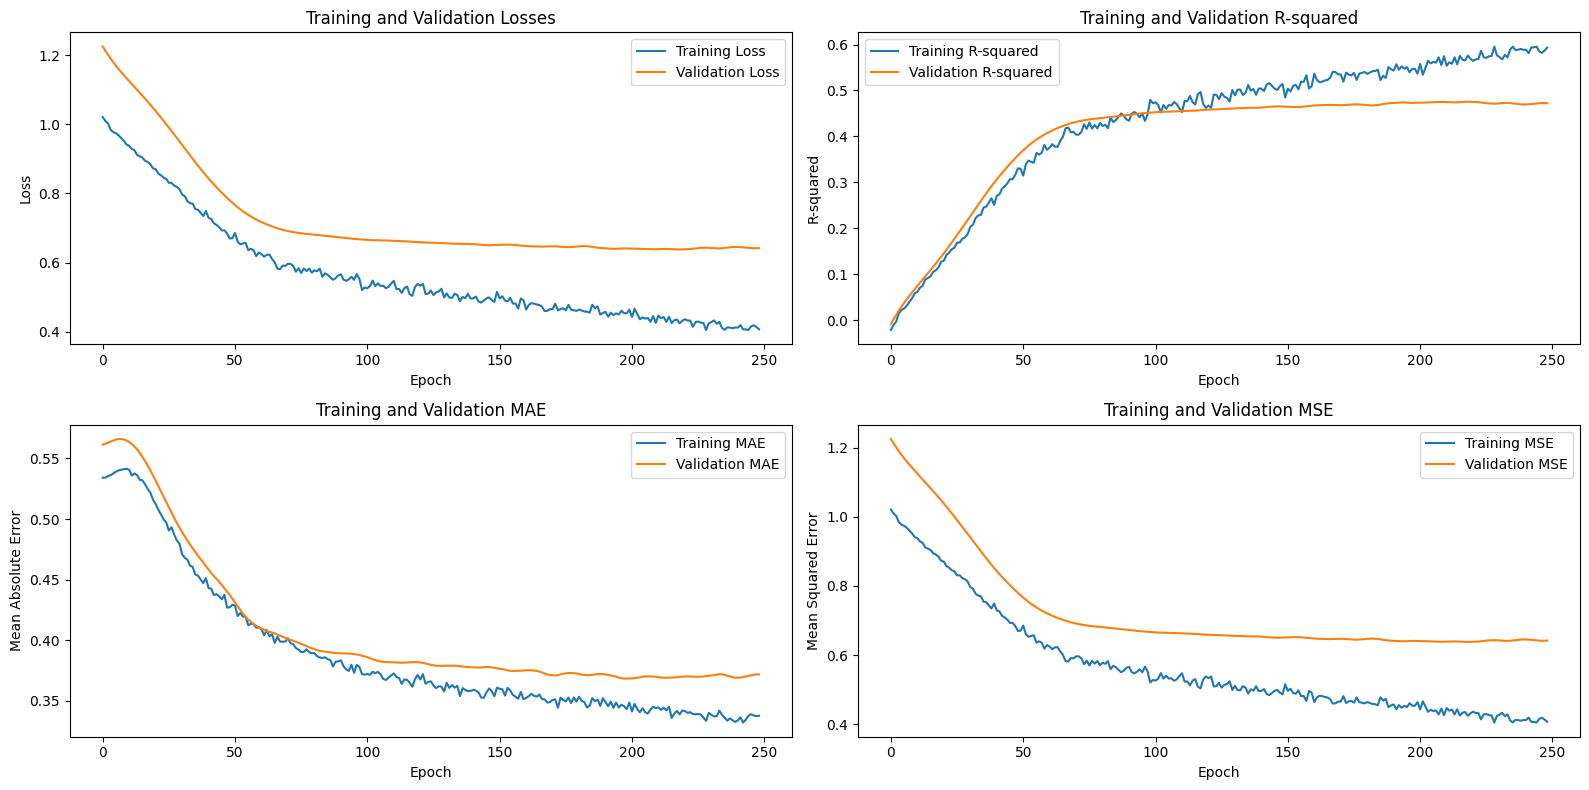

Test Loss: 0.4837644100189209, Test R-squared: 0.5036542621371958, Test MAE: 0.3656303286552429, Test MSE: 0.4837644100189209


In [46]:
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_LONDON.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_LONDON.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_LONDON.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)

    # !!! de prijs wordt nog bijgehoud als feature maar de node zijn eigen prijs wordt telkens gemasked zodat de nodes van de
    # prijzen van hun neighbours kunnen leren maar niet hun eigen prijs gebruiken
    def forward(self, x, edge_index):
        # Assuming 'price' is the last feature in the input tensor x
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Second convolutional layer with dropout
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Third convolutional layer
        x = self.conv3(x, edge_index)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 50, 60)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, out_channels=1, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    y_train_t = torch.tensor(train_prices_pegnn, dtype=torch.float).view(-1, 1)
    y_val_t = torch.tensor(val_prices_pegnn, dtype=torch.float).view(-1, 1)

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train_t)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val_t)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], out_channels=1, dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

y_train = torch.tensor(train_prices_pegnn, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn, dtype=torch.float).view(-1, 1)

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')



PE-GNN model
Hier kan het model terug ingeladen worden indien er een versie is opgeslagen.

Best parameters:  {'hidden_channels': 92, 'lr': 0.009525877655075697, 'k': 6}


Final training:   0%|          | 2/500 [00:00<00:38, 13.08it/s]

Epoch 1, Training Loss: 15.917579650878906, Training R-squared: 0.9994395210528413, Training MAE: 2.8471717834472656, Training MSE: 15.917580604553223
Epoch 1, Validation Loss: 22693.396484375, Validation R-squared: 0.6094890337510126, Validation MAE: 121.41632080078125, Validation MSE: 22693.39453125
Epoch 2, Training Loss: 6871.4814453125, Training R-squared: 0.7580460902077482, Training MAE: 79.67977905273438, Training MSE: 6871.4814453125
Epoch 2, Validation Loss: 9684.5712890625, Validation R-squared: 0.8333466042763171, Validation MAE: 63.06240463256836, Validation MSE: 9684.5703125
Epoch 3, Training Loss: 524.8209838867188, Training R-squared: 0.9815203632855962, Training MAE: 21.517683029174805, Training MSE: 524.8209838867188
Epoch 3, Validation Loss: 4495.3310546875, Validation R-squared: 0.9226437420421464, Validation MAE: 42.32233428955078, Validation MSE: 4495.3310546875


Final training:   1%|          | 6/500 [00:00<00:35, 13.87it/s]

Epoch 4, Training Loss: 1893.279296875, Training R-squared: 0.9333351392805946, Training MAE: 41.78708267211914, Training MSE: 1893.279296875
Epoch 4, Validation Loss: 4748.19677734375, Validation R-squared: 0.9182923849116003, Validation MAE: 52.67501449584961, Validation MSE: 4748.19677734375
Epoch 5, Training Loss: 3907.028564453125, Training R-squared: 0.8624283576425282, Training MAE: 60.267852783203125, Training MSE: 3907.029052734375
Epoch 5, Validation Loss: 4643.91064453125, Validation R-squared: 0.9200869677115345, Validation MAE: 43.90647888183594, Validation MSE: 4643.91064453125
Epoch 6, Training Loss: 2100.20556640625, Training R-squared: 0.926048995256976, Training MAE: 43.82090759277344, Training MSE: 2100.20556640625
Epoch 6, Validation Loss: 5973.09765625, Validation R-squared: 0.8972141432113674, Validation MAE: 37.603668212890625, Validation MSE: 5973.09716796875


Final training:   2%|▏         | 8/500 [00:00<00:36, 13.49it/s]

Epoch 7, Training Loss: 232.7820281982422, Training R-squared: 0.9918034386609749, Training MAE: 13.536966323852539, Training MSE: 232.78199768066406
Epoch 7, Validation Loss: 9347.7578125, Validation R-squared: 0.83914252324162, Validation MAE: 58.74917984008789, Validation MSE: 9347.7587890625
Epoch 8, Training Loss: 323.6675720214844, Training R-squared: 0.9886032373688644, Training MAE: 16.77066993713379, Training MSE: 323.6675720214844
Epoch 8, Validation Loss: 12648.4736328125, Validation R-squared: 0.7823433610699306, Validation MAE: 77.94081115722656, Validation MSE: 12648.4736328125
Epoch 9, Training Loss: 1425.1346435546875, Training R-squared: 0.9498191296097261, Training MAE: 36.084495544433594, Training MSE: 1425.1346435546875
Epoch 9, Validation Loss: 13740.8515625, Validation R-squared: 0.7635455875784486, Validation MAE: 83.16178131103516, Validation MSE: 13740.8515625


Final training:   2%|▏         | 12/500 [00:00<00:35, 13.73it/s]

Epoch 10, Training Loss: 1889.964111328125, Training R-squared: 0.9334518760351296, Training MAE: 41.43059158325195, Training MSE: 1889.9639892578125
Epoch 10, Validation Loss: 12449.0283203125, Validation R-squared: 0.7857754436870821, Validation MAE: 76.37670135498047, Validation MSE: 12449.029296875
Epoch 11, Training Loss: 1358.7474365234375, Training R-squared: 0.9521567156711964, Training MAE: 34.798702239990234, Training MSE: 1358.747314453125
Epoch 11, Validation Loss: 9878.9501953125, Validation R-squared: 0.8300016883648573, Validation MAE: 61.55228042602539, Validation MSE: 9878.951171875
Epoch 12, Training Loss: 483.8902893066406, Training R-squared: 0.9829615851598182, Training MAE: 19.990863800048828, Training MSE: 483.8902587890625
Epoch 12, Validation Loss: 7369.6904296875, Validation R-squared: 0.8731813866360014, Validation MAE: 45.05942916870117, Validation MSE: 7369.68994140625


Final training:   3%|▎         | 14/500 [00:01<00:34, 13.97it/s]

Epoch 13, Training Loss: 54.35941696166992, Training R-squared: 0.998085933312505, Training MAE: 5.730947971343994, Training MSE: 54.35941696166992
Epoch 13, Validation Loss: 5777.29541015625, Validation R-squared: 0.900583526093972, Validation MAE: 37.959564208984375, Validation MSE: 5777.29541015625
Epoch 14, Training Loss: 329.4663391113281, Training R-squared: 0.9883990564821168, Training MAE: 16.43259048461914, Training MSE: 329.4663391113281
Epoch 14, Validation Loss: 5156.52978515625, Validation R-squared: 0.9112657326871346, Validation MAE: 38.9520149230957, Validation MSE: 5156.5302734375
Epoch 15, Training Loss: 840.8353881835938, Training R-squared: 0.9703930778540862, Training MAE: 27.46747589111328, Training MSE: 840.8353881835938
Epoch 15, Validation Loss: 5134.04931640625, Validation R-squared: 0.9116525890554776, Validation MAE: 39.75910949707031, Validation MSE: 5134.04931640625


Final training:   4%|▎         | 18/500 [00:01<00:33, 14.25it/s]

Epoch 16, Training Loss: 962.6277465820312, Training R-squared: 0.9661046096236453, Training MAE: 29.439083099365234, Training MSE: 962.627685546875
Epoch 16, Validation Loss: 5542.3759765625, Validation R-squared: 0.9046260500425719, Validation MAE: 39.08417510986328, Validation MSE: 5542.3759765625
Epoch 17, Training Loss: 610.7822875976562, Training R-squared: 0.9784935511052151, Training MAE: 22.992908477783203, Training MSE: 610.7823486328125
Epoch 17, Validation Loss: 6471.076171875, Validation R-squared: 0.8886448544510929, Validation MAE: 40.54080581665039, Validation MSE: 6471.076171875
Epoch 18, Training Loss: 188.9099578857422, Training R-squared: 0.9933482316218591, Training MAE: 11.628174781799316, Training MSE: 188.9099578857422
Epoch 18, Validation Loss: 7874.48583984375, Validation R-squared: 0.8644947826196485, Validation MAE: 47.192710876464844, Validation MSE: 7874.486328125


Final training:   4%|▍         | 20/500 [00:01<00:34, 13.96it/s]

Epoch 19, Training Loss: 68.87515258789062, Training R-squared: 0.9975748150920515, Training MAE: 6.5905938148498535, Training MSE: 68.87515258789062
Epoch 19, Validation Loss: 9344.685546875, Validation R-squared: 0.839195380957922, Validation MAE: 55.95717239379883, Validation MSE: 9344.6865234375
Epoch 20, Training Loss: 258.23992919921875, Training R-squared: 0.990907032308828, Training MAE: 13.953140258789062, Training MSE: 258.23992919921875
Epoch 20, Validation Loss: 10304.7265625, Validation R-squared: 0.8226748729291393, Validation MAE: 61.69927215576172, Validation MSE: 10304.7265625
Epoch 21, Training Loss: 485.96942138671875, Training R-squared: 0.982888375283791, Training MAE: 19.878177642822266, Training MSE: 485.9694519042969
Epoch 21, Validation Loss: 10392.0693359375, Validation R-squared: 0.8211718873562524, Validation MAE: 62.255680084228516, Validation MSE: 10392.068359375


Final training:   5%|▍         | 24/500 [00:01<00:35, 13.36it/s]

Epoch 22, Training Loss: 514.002685546875, Training R-squared: 0.981901289992129, Training MAE: 20.54091453552246, Training MSE: 514.0026245117188
Epoch 22, Validation Loss: 9654.8681640625, Validation R-squared: 0.8338577645103912, Validation MAE: 57.91336441040039, Validation MSE: 9654.8662109375
Epoch 23, Training Loss: 334.7552795410156, Training R-squared: 0.9882128264317573, Training MAE: 16.162734985351562, Training MSE: 334.7552490234375
Epoch 23, Validation Loss: 8463.6181640625, Validation R-squared: 0.8543569190675819, Validation MAE: 50.65342330932617, Validation MSE: 8463.619140625
Epoch 24, Training Loss: 125.48320007324219, Training R-squared: 0.9955815714579922, Training MAE: 9.141181945800781, Training MSE: 125.48320007324219
Epoch 24, Validation Loss: 7274.17578125, Validation R-squared: 0.8748250054137988, Validation MAE: 43.7454833984375, Validation MSE: 7274.17529296875


Final training:   5%|▌         | 26/500 [00:01<00:34, 13.70it/s]

Epoch 25, Training Loss: 63.20061111450195, Training R-squared: 0.9977746233944425, Training MAE: 6.037639141082764, Training MSE: 63.20061111450195
Epoch 25, Validation Loss: 6407.55859375, Validation R-squared: 0.8897378731884026, Validation MAE: 39.823143005371094, Validation MSE: 6407.55859375
Epoch 26, Training Loss: 164.90777587890625, Training R-squared: 0.9941933807110005, Training MAE: 10.542959213256836, Training MSE: 164.90774536132812
Epoch 26, Validation Loss: 5969.59033203125, Validation R-squared: 0.8972744739223212, Validation MAE: 38.50592803955078, Validation MSE: 5969.5908203125
Epoch 27, Training Loss: 287.3383483886719, Training R-squared: 0.9898824391168362, Training MAE: 14.845039367675781, Training MSE: 287.3383483886719
Epoch 27, Validation Loss: 5938.83447265625, Validation R-squared: 0.8978037374586085, Validation MAE: 38.34989547729492, Validation MSE: 5938.83447265625


Final training:   6%|▌         | 30/500 [00:02<00:33, 14.02it/s]

Epoch 28, Training Loss: 288.5320739746094, Training R-squared: 0.989840405173107, Training MAE: 15.078268051147461, Training MSE: 288.5320739746094
Epoch 28, Validation Loss: 6282.6337890625, Validation R-squared: 0.8918875831577976, Validation MAE: 39.28594207763672, Validation MSE: 6282.63427734375
Epoch 29, Training Loss: 173.1842498779297, Training R-squared: 0.9939019550465521, Training MAE: 11.310808181762695, Training MSE: 173.18421936035156
Epoch 29, Validation Loss: 6953.16796875, Validation R-squared: 0.880348954897743, Validation MAE: 42.3487663269043, Validation MSE: 6953.16796875
Epoch 30, Training Loss: 63.51634979248047, Training R-squared: 0.9977635055514237, Training MAE: 6.13461971282959, Training MSE: 63.516353607177734
Epoch 30, Validation Loss: 7802.51904296875, Validation R-squared: 0.8657332048790557, Validation MAE: 47.08926010131836, Validation MSE: 7802.51904296875


Final training:   6%|▋         | 32/500 [00:02<00:34, 13.41it/s]

Epoch 31, Training Loss: 54.939579010009766, Training R-squared: 0.9980655050066639, Training MAE: 5.916208267211914, Training MSE: 54.93958282470703
Epoch 31, Validation Loss: 8565.880859375, Validation R-squared: 0.852597177171434, Validation MAE: 51.57127380371094, Validation MSE: 8565.880859375
Epoch 32, Training Loss: 126.99552154541016, Training R-squared: 0.9955283202736956, Training MAE: 9.404043197631836, Training MSE: 126.99552154541016
Epoch 32, Validation Loss: 8971.4560546875, Validation R-squared: 0.8456179701274509, Validation MAE: 53.85279083251953, Validation MSE: 8971.4560546875
Epoch 33, Training Loss: 185.32337951660156, Training R-squared: 0.9934745205498162, Training MAE: 11.552667617797852, Training MSE: 185.32337951660156
Epoch 33, Validation Loss: 8887.3134765625, Validation R-squared: 0.8470659328654495, Validation MAE: 53.204341888427734, Validation MSE: 8887.3134765625


Final training:   7%|▋         | 36/500 [00:02<00:35, 13.25it/s]

Epoch 34, Training Loss: 166.05105590820312, Training R-squared: 0.994153123256045, Training MAE: 10.861541748046875, Training MSE: 166.05105590820312
Epoch 34, Validation Loss: 8384.66015625, Validation R-squared: 0.8557156466804172, Validation MAE: 50.101356506347656, Validation MSE: 8384.6611328125
Epoch 35, Training Loss: 91.73041534423828, Training R-squared: 0.9967700515246539, Training MAE: 7.776834011077881, Training MSE: 91.73041534423828
Epoch 35, Validation Loss: 7681.609375, Validation R-squared: 0.8678138279089115, Validation MAE: 45.938446044921875, Validation MSE: 7681.60986328125
Epoch 36, Training Loss: 36.66448211669922, Training R-squared: 0.9987089951922759, Training MAE: 4.640765190124512, Training MSE: 36.664485931396484
Epoch 36, Validation Loss: 7021.0087890625, Validation R-squared: 0.8791815349564207, Validation MAE: 42.42705154418945, Validation MSE: 7021.0087890625


Final training:   8%|▊         | 38/500 [00:02<00:35, 13.07it/s]

Epoch 37, Training Loss: 46.6035041809082, Training R-squared: 0.9983590293932469, Training MAE: 5.333884239196777, Training MSE: 46.60350036621094
Epoch 37, Validation Loss: 6569.8310546875, Validation R-squared: 0.886945465392484, Validation MAE: 40.36614990234375, Validation MSE: 6569.8310546875
Epoch 38, Training Loss: 94.61339569091797, Training R-squared: 0.9966685380057072, Training MAE: 8.0286865234375, Training MSE: 94.61338806152344
Epoch 38, Validation Loss: 6397.05126953125, Validation R-squared: 0.889918675849726, Validation MAE: 39.66617965698242, Validation MSE: 6397.0517578125
Epoch 39, Training Loss: 117.6800765991211, Training R-squared: 0.9958563299297881, Training MAE: 9.007392883300781, Training MSE: 117.68006134033203
Epoch 39, Validation Loss: 6506.77001953125, Validation R-squared: 0.8880306325190868, Validation MAE: 40.160057067871094, Validation MSE: 6506.77001953125


Final training:   8%|▊         | 42/500 [00:03<00:34, 13.45it/s]

Epoch 40, Training Loss: 89.68746948242188, Training R-squared: 0.9968419861704062, Training MAE: 7.611365795135498, Training MSE: 89.68746948242188
Epoch 40, Validation Loss: 6858.5595703125, Validation R-squared: 0.8819769900709524, Validation MAE: 42.04957580566406, Validation MSE: 6858.5595703125
Epoch 41, Training Loss: 44.34648513793945, Training R-squared: 0.9984385017722507, Training MAE: 5.087131977081299, Training MSE: 44.34648895263672
Epoch 41, Validation Loss: 7351.9306640625, Validation R-squared: 0.8734869920988684, Validation MAE: 44.98152160644531, Validation MSE: 7351.93017578125
Epoch 42, Training Loss: 28.35784912109375, Training R-squared: 0.9990014828188288, Training MAE: 4.156811714172363, Training MSE: 28.35784912109375
Epoch 42, Validation Loss: 7824.73486328125, Validation R-squared: 0.8653509011199285, Validation MAE: 47.83908462524414, Validation MSE: 7824.73583984375


Final training:   9%|▉         | 44/500 [00:03<00:33, 13.45it/s]

Epoch 43, Training Loss: 48.47416687011719, Training R-squared: 0.9982931606752831, Training MAE: 5.77118444442749, Training MSE: 48.47416687011719
Epoch 43, Validation Loss: 8107.12646484375, Validation R-squared: 0.8604914833835807, Validation MAE: 49.397830963134766, Validation MSE: 8107.1259765625
Epoch 44, Training Loss: 71.74594116210938, Training R-squared: 0.9974737308991746, Training MAE: 7.137589931488037, Training MSE: 71.74594116210938
Epoch 44, Validation Loss: 8103.94091796875, Validation R-squared: 0.8605462978059781, Validation MAE: 49.10663986206055, Validation MSE: 8103.94091796875
Epoch 45, Training Loss: 68.52863311767578, Training R-squared: 0.9975870163285449, Training MAE: 6.821102142333984, Training MSE: 68.52864074707031
Epoch 45, Validation Loss: 7840.65283203125, Validation R-squared: 0.8650769844169366, Validation MAE: 47.28672409057617, Validation MSE: 7840.65283203125


Final training:  10%|▉         | 48/500 [00:03<00:32, 13.72it/s]

Epoch 46, Training Loss: 43.984989166259766, Training R-squared: 0.9984512305287301, Training MAE: 5.231081962585449, Training MSE: 43.984989166259766
Epoch 46, Validation Loss: 7439.45751953125, Validation R-squared: 0.8719808159735767, Validation MAE: 44.8250617980957, Validation MSE: 7439.45751953125
Epoch 47, Training Loss: 26.360410690307617, Training R-squared: 0.9990718152111158, Training MAE: 3.953195571899414, Training MSE: 26.360410690307617
Epoch 47, Validation Loss: 7050.18359375, Validation R-squared: 0.8786795031258474, Validation MAE: 42.701637268066406, Validation MSE: 7050.18359375
Epoch 48, Training Loss: 31.435880661010742, Training R-squared: 0.998893101326396, Training MAE: 4.36080265045166, Training MSE: 31.435876846313477
Epoch 48, Validation Loss: 6788.04833984375, Validation R-squared: 0.8831903500430204, Validation MAE: 41.3896369934082, Validation MSE: 6788.048828125


Final training:  10%|█         | 50/500 [00:03<00:32, 13.90it/s]

Epoch 49, Training Loss: 46.05990982055664, Training R-squared: 0.9983781698758744, Training MAE: 5.523073673248291, Training MSE: 46.059906005859375
Epoch 49, Validation Loss: 6710.17236328125, Validation R-squared: 0.8845304519761181, Validation MAE: 41.068851470947266, Validation MSE: 6710.171875
Epoch 50, Training Loss: 48.166229248046875, Training R-squared: 0.998304003682338, Training MAE: 5.608381748199463, Training MSE: 48.166229248046875
Epoch 50, Validation Loss: 6819.33740234375, Validation R-squared: 0.8826519233050224, Validation MAE: 41.77642059326172, Validation MSE: 6819.337890625
Epoch 51, Training Loss: 34.930782318115234, Training R-squared: 0.9987700412108033, Training MAE: 4.5463948249816895, Training MSE: 34.930782318115234
Epoch 51, Validation Loss: 7067.84814453125, Validation R-squared: 0.8783755286745165, Validation MAE: 43.37058639526367, Validation MSE: 7067.84814453125


Final training:  11%|█         | 54/500 [00:03<00:30, 14.60it/s]

Epoch 52, Training Loss: 23.098064422607422, Training R-squared: 0.9991866866791347, Training MAE: 3.6481738090515137, Training MSE: 23.098064422607422
Epoch 52, Validation Loss: 7362.015625, Validation R-squared: 0.8733134618048535, Validation MAE: 45.2797737121582, Validation MSE: 7362.01513671875
Epoch 53, Training Loss: 24.98278045654297, Training R-squared: 0.9991203233679057, Training MAE: 3.988128900527954, Training MSE: 24.98278045654297
Epoch 53, Validation Loss: 7588.18896484375, Validation R-squared: 0.8694214182630062, Validation MAE: 46.67139434814453, Validation MSE: 7588.18994140625
Epoch 54, Training Loss: 33.938446044921875, Training R-squared: 0.9988049826042082, Training MAE: 4.801497459411621, Training MSE: 33.938446044921875
Epoch 54, Validation Loss: 7661.3955078125, Validation R-squared: 0.8681616783869357, Validation MAE: 46.93604278564453, Validation MSE: 7661.3955078125
Epoch 55, Training Loss: 35.70585250854492, Training R-squared: 0.9987427498145189, Trainin

Final training:  12%|█▏        | 58/500 [00:04<00:30, 14.50it/s]

Epoch 56, Training Loss: 27.390056610107422, Training R-squared: 0.9990355599840911, Training MAE: 4.176353931427002, Training MSE: 27.390056610107422
Epoch 56, Validation Loss: 7357.39306640625, Validation R-squared: 0.8733929881247547, Validation MAE: 44.5908203125, Validation MSE: 7357.3935546875
Epoch 57, Training Loss: 19.46494483947754, Training R-squared: 0.9993146136960775, Training MAE: 3.3909876346588135, Training MSE: 19.46494483947754
Epoch 57, Validation Loss: 7127.658203125, Validation R-squared: 0.8773462912303085, Validation MAE: 43.164737701416016, Validation MSE: 7127.6591796875
Epoch 58, Training Loss: 20.629358291625977, Training R-squared: 0.9992736132191791, Training MAE: 3.4517722129821777, Training MSE: 20.629356384277344
Epoch 58, Validation Loss: 6960.45263671875, Validation R-squared: 0.8802236063375225, Validation MAE: 42.24296188354492, Validation MSE: 6960.4521484375


Final training:  12%|█▏        | 60/500 [00:04<00:30, 14.21it/s]

Epoch 59, Training Loss: 26.739530563354492, Training R-squared: 0.9990584658245459, Training MAE: 4.005059242248535, Training MSE: 26.739534378051758
Epoch 59, Validation Loss: 6904.892578125, Validation R-squared: 0.8811796760709151, Validation MAE: 41.98874282836914, Validation MSE: 6904.89306640625
Epoch 60, Training Loss: 27.861753463745117, Training R-squared: 0.9990189509895463, Training MAE: 4.089171409606934, Training MSE: 27.861753463745117
Epoch 60, Validation Loss: 6968.26123046875, Validation R-squared: 0.880089230857673, Validation MAE: 42.43984603881836, Validation MSE: 6968.26123046875
Epoch 61, Training Loss: 22.159971237182617, Training R-squared: 0.9992197182746866, Training MAE: 3.5611343383789062, Training MSE: 22.159969329833984
Epoch 61, Validation Loss: 7117.59130859375, Validation R-squared: 0.8775195297649471, Validation MAE: 43.461692810058594, Validation MSE: 7117.59130859375


Final training:  13%|█▎        | 64/500 [00:04<00:30, 14.40it/s]

Epoch 62, Training Loss: 17.143211364746094, Training R-squared: 0.9993963649573283, Training MAE: 3.13991641998291, Training MSE: 17.143211364746094
Epoch 62, Validation Loss: 7288.3037109375, Validation R-squared: 0.8745818844592578, Validation MAE: 44.63759231567383, Validation MSE: 7288.30419921875
Epoch 63, Training Loss: 18.25956153869629, Training R-squared: 0.9993570568228948, Training MAE: 3.3558058738708496, Training MSE: 18.259559631347656
Epoch 63, Validation Loss: 7407.490234375, Validation R-squared: 0.8725309172839104, Validation MAE: 45.42547607421875, Validation MSE: 7407.490234375
Epoch 64, Training Loss: 22.042476654052734, Training R-squared: 0.9992238554063696, Training MAE: 3.78271484375, Training MSE: 22.042476654052734
Epoch 64, Validation Loss: 7427.1123046875, Validation R-squared: 0.8721932534139945, Validation MAE: 45.4641227722168, Validation MSE: 7427.1123046875


Final training:  13%|█▎        | 66/500 [00:04<00:30, 14.33it/s]

Epoch 65, Training Loss: 22.198026657104492, Training R-squared: 0.9992183782465218, Training MAE: 3.792322874069214, Training MSE: 22.198026657104492
Epoch 65, Validation Loss: 7347.04443359375, Validation R-squared: 0.8735710826741504, Validation MAE: 44.797054290771484, Validation MSE: 7347.0439453125
Epoch 66, Training Loss: 18.42037582397461, Training R-squared: 0.9993513943598357, Training MAE: 3.3701744079589844, Training MSE: 18.42037582397461
Epoch 66, Validation Loss: 7211.27294921875, Validation R-squared: 0.8759074550470178, Validation MAE: 43.793880462646484, Validation MSE: 7211.2724609375
Epoch 67, Training Loss: 15.781100273132324, Training R-squared: 0.9994443266643586, Training MAE: 3.0272936820983887, Training MSE: 15.78110122680664
Epoch 67, Validation Loss: 7081.8701171875, Validation R-squared: 0.8781342324007235, Validation MAE: 42.91386795043945, Validation MSE: 7081.8701171875


Final training:  14%|█▍        | 70/500 [00:05<00:30, 14.15it/s]

Epoch 68, Training Loss: 16.964340209960938, Training R-squared: 0.99940266320627, Training MAE: 3.100142240524292, Training MSE: 16.964340209960938
Epoch 68, Validation Loss: 7009.9365234375, Validation R-squared: 0.8793720773372236, Validation MAE: 42.453712463378906, Validation MSE: 7009.9365234375
Epoch 69, Training Loss: 18.96339225769043, Training R-squared: 0.9993322740030788, Training MAE: 3.292194128036499, Training MSE: 18.96339225769043
Epoch 69, Validation Loss: 7018.2802734375, Validation R-squared: 0.8792285009238763, Validation MAE: 42.52096939086914, Validation MSE: 7018.27978515625
Epoch 70, Training Loss: 18.223983764648438, Training R-squared: 0.9993583094800631, Training MAE: 3.2205498218536377, Training MSE: 18.223983764648438
Epoch 70, Validation Loss: 7097.046875, Validation R-squared: 0.8778730687413164, Validation MAE: 43.05197525024414, Validation MSE: 7097.046875


Final training:  14%|█▍        | 72/500 [00:05<00:30, 14.22it/s]

Epoch 71, Training Loss: 15.752649307250977, Training R-squared: 0.9994453284952751, Training MAE: 2.9952447414398193, Training MSE: 15.75264835357666
Epoch 71, Validation Loss: 7208.68212890625, Validation R-squared: 0.8759520406880263, Validation MAE: 43.81808090209961, Validation MSE: 7208.68212890625
Epoch 72, Training Loss: 14.884933471679688, Training R-squared: 0.9994758818606944, Training MAE: 2.962412118911743, Training MSE: 14.884934425354004
Epoch 72, Validation Loss: 7302.52880859375, Validation R-squared: 0.8743371058077473, Validation MAE: 44.468936920166016, Validation MSE: 7302.52880859375
Epoch 73, Training Loss: 16.07210922241211, Training R-squared: 0.9994340798271797, Training MAE: 3.136787176132202, Training MSE: 16.07210922241211
Epoch 73, Validation Loss: 7337.30810546875, Validation R-squared: 0.8737386280770278, Validation MAE: 44.6961784362793, Validation MSE: 7337.3076171875


Final training:  15%|█▌        | 76/500 [00:05<00:29, 14.38it/s]

Epoch 74, Training Loss: 16.728187561035156, Training R-squared: 0.9994109784824708, Training MAE: 3.2218821048736572, Training MSE: 16.728187561035156
Epoch 74, Validation Loss: 7301.09130859375, Validation R-squared: 0.8743618266660005, Validation MAE: 44.41720962524414, Validation MSE: 7301.091796875
Epoch 75, Training Loss: 15.514018058776855, Training R-squared: 0.9994537309301965, Training MAE: 3.0716302394866943, Training MSE: 15.514019966125488
Epoch 75, Validation Loss: 7215.65869140625, Validation R-squared: 0.8758319756070666, Validation MAE: 43.80424499511719, Validation MSE: 7215.6591796875
Epoch 76, Training Loss: 14.106782913208008, Training R-squared: 0.9995032816234211, Training MAE: 2.873802661895752, Training MSE: 14.106782913208008
Epoch 76, Validation Loss: 7122.86865234375, Validation R-squared: 0.8774287224539181, Validation MAE: 43.166202545166016, Validation MSE: 7122.86865234375


Final training:  16%|█▌        | 78/500 [00:05<00:29, 14.38it/s]

Epoch 77, Training Loss: 14.246441841125488, Training R-squared: 0.9994983640666572, Training MAE: 2.8430826663970947, Training MSE: 14.246439933776855
Epoch 77, Validation Loss: 7063.21728515625, Validation R-squared: 0.8784552094521803, Validation MAE: 42.76601028442383, Validation MSE: 7063.21728515625
Epoch 78, Training Loss: 15.112279891967773, Training R-squared: 0.9994678767175398, Training MAE: 2.9131922721862793, Training MSE: 15.112279891967773
Epoch 78, Validation Loss: 7059.06640625, Validation R-squared: 0.8785266391583194, Validation MAE: 42.73089599609375, Validation MSE: 7059.06640625
Epoch 79, Training Loss: 14.924437522888184, Training R-squared: 0.9994744909194155, Training MAE: 2.8942041397094727, Training MSE: 14.924437522888184
Epoch 79, Validation Loss: 7107.78173828125, Validation R-squared: 0.8776883446034941, Validation MAE: 43.04386901855469, Validation MSE: 7107.78173828125


Final training:  16%|█▋        | 82/500 [00:05<00:29, 14.41it/s]

Epoch 80, Training Loss: 13.783864974975586, Training R-squared: 0.9995146520081795, Training MAE: 2.792491912841797, Training MSE: 13.783864974975586
Epoch 80, Validation Loss: 7184.32763671875, Validation R-squared: 0.876371130045395, Validation MAE: 43.54874038696289, Validation MSE: 7184.3271484375
Epoch 81, Training Loss: 13.240705490112305, Training R-squared: 0.9995337772757944, Training MAE: 2.7724714279174805, Training MSE: 13.240707397460938
Epoch 81, Validation Loss: 7252.39990234375, Validation R-squared: 0.8751997193338823, Validation MAE: 43.99650955200195, Validation MSE: 7252.400390625
Epoch 82, Training Loss: 13.713967323303223, Training R-squared: 0.9995171131437164, Training MAE: 2.8585357666015625, Training MSE: 13.713967323303223
Epoch 82, Validation Loss: 7281.25341796875, Validation R-squared: 0.8747032050378933, Validation MAE: 44.17204666137695, Validation MSE: 7281.25390625


Final training:  17%|█▋        | 84/500 [00:06<00:28, 14.45it/s]

Epoch 83, Training Loss: 14.03189468383789, Training R-squared: 0.9995059185597787, Training MAE: 2.904371738433838, Training MSE: 14.031892776489258
Epoch 83, Validation Loss: 7260.53173828125, Validation R-squared: 0.8750598031843042, Validation MAE: 44.006065368652344, Validation MSE: 7260.53076171875
Epoch 84, Training Loss: 13.468663215637207, Training R-squared: 0.9995257506149344, Training MAE: 2.8268768787384033, Training MSE: 13.468664169311523
Epoch 84, Validation Loss: 7204.12744140625, Validation R-squared: 0.8760304001882572, Validation MAE: 43.60953903198242, Validation MSE: 7204.1279296875
Epoch 85, Training Loss: 12.775768280029297, Training R-squared: 0.999550148406823, Training MAE: 2.720219612121582, Training MSE: 12.775768280029297
Epoch 85, Validation Loss: 7141.0810546875, Validation R-squared: 0.8771153267446047, Validation MAE: 43.1895866394043, Validation MSE: 7141.0810546875


Final training:  18%|█▊        | 88/500 [00:06<00:30, 13.60it/s]

Epoch 86, Training Loss: 12.783863067626953, Training R-squared: 0.9995498633436692, Training MAE: 2.6935956478118896, Training MSE: 12.783863067626953
Epoch 86, Validation Loss: 7100.13671875, Validation R-squared: 0.877819906810096, Validation MAE: 42.933292388916016, Validation MSE: 7100.13623046875
Epoch 87, Training Loss: 13.108847618103027, Training R-squared: 0.9995384202017714, Training MAE: 2.714921474456787, Training MSE: 13.108848571777344
Epoch 87, Validation Loss: 7097.0048828125, Validation R-squared: 0.8778737900749176, Validation MAE: 42.931270599365234, Validation MSE: 7097.0048828125
Epoch 88, Training Loss: 12.957110404968262, Training R-squared: 0.9995437630286209, Training MAE: 2.699251890182495, Training MSE: 12.957112312316895
Epoch 88, Validation Loss: 7128.9619140625, Validation R-squared: 0.87732385351604, Validation MAE: 43.158790588378906, Validation MSE: 7128.962890625


Final training:  18%|█▊        | 90/500 [00:06<00:29, 13.69it/s]

Epoch 89, Training Loss: 12.438502311706543, Training R-squared: 0.999562023968315, Training MAE: 2.659210205078125, Training MSE: 12.438502311706543
Epoch 89, Validation Loss: 7177.5166015625, Validation R-squared: 0.8764883333346616, Validation MAE: 43.490543365478516, Validation MSE: 7177.5166015625
Epoch 90, Training Loss: 12.227909088134766, Training R-squared: 0.9995694392054009, Training MAE: 2.6615164279937744, Training MSE: 12.227909088134766
Epoch 90, Validation Loss: 7217.75634765625, Validation R-squared: 0.8757958752533966, Validation MAE: 43.752098083496094, Validation MSE: 7217.7568359375
Epoch 91, Training Loss: 12.390571594238281, Training R-squared: 0.9995637117052554, Training MAE: 2.7016921043395996, Training MSE: 12.390570640563965
Epoch 91, Validation Loss: 7230.75390625, Validation R-squared: 0.875572217506298, Validation MAE: 43.81214141845703, Validation MSE: 7230.75390625


Final training:  19%|█▉        | 94/500 [00:06<00:32, 12.36it/s]

Epoch 92, Training Loss: 12.389406204223633, Training R-squared: 0.9995637527068901, Training MAE: 2.70283842086792, Training MSE: 12.389406204223633
Epoch 92, Validation Loss: 7212.7197265625, Validation R-squared: 0.8758825510535313, Validation MAE: 43.65460968017578, Validation MSE: 7212.72021484375
Epoch 93, Training Loss: 12.059253692626953, Training R-squared: 0.9995753777950657, Training MAE: 2.6490209102630615, Training MSE: 12.059253692626953
Epoch 93, Validation Loss: 7175.60107421875, Validation R-squared: 0.8765212967370287, Validation MAE: 43.377960205078125, Validation MSE: 7175.60107421875
Epoch 94, Training Loss: 11.81095027923584, Training R-squared: 0.9995841208788804, Training MAE: 2.6000235080718994, Training MSE: 11.81095027923584
Epoch 94, Validation Loss: 7139.27685546875, Validation R-squared: 0.8771463641569317, Validation MAE: 43.12791061401367, Validation MSE: 7139.27685546875


Final training:  19%|█▉        | 96/500 [00:07<00:33, 11.90it/s]

Epoch 95, Training Loss: 11.856963157653809, Training R-squared: 0.9995825006775305, Training MAE: 2.5892627239227295, Training MSE: 11.856963157653809
Epoch 95, Validation Loss: 7120.8388671875, Validation R-squared: 0.8774636511085385, Validation MAE: 43.017578125, Validation MSE: 7120.83837890625
Epoch 96, Training Loss: 11.890800476074219, Training R-squared: 0.9995813092241714, Training MAE: 2.587174892425537, Training MSE: 11.890802383422852
Epoch 96, Validation Loss: 7126.73876953125, Validation R-squared: 0.877362115852421, Validation MAE: 43.082454681396484, Validation MSE: 7126.73876953125
Epoch 97, Training Loss: 11.68031120300293, Training R-squared: 0.9995887208704358, Training MAE: 2.5680575370788574, Training MSE: 11.680310249328613
Epoch 97, Validation Loss: 7150.8349609375, Validation R-squared: 0.8769474723282958, Validation MAE: 43.27344512939453, Validation MSE: 7150.8349609375


Final training:  20%|██        | 100/500 [00:07<00:34, 11.71it/s]

Epoch 98, Training Loss: 11.445352554321289, Training R-squared: 0.9995969940635973, Training MAE: 2.555497646331787, Training MSE: 11.445352554321289
Epoch 98, Validation Loss: 7178.427734375, Validation R-squared: 0.8764726653339131, Validation MAE: 43.48130416870117, Validation MSE: 7178.4267578125
Epoch 99, Training Loss: 11.418187141418457, Training R-squared: 0.999597950663945, Training MAE: 2.570387363433838, Training MSE: 11.418185234069824
Epoch 99, Validation Loss: 7194.33349609375, Validation R-squared: 0.8761989484977883, Validation MAE: 43.59306335449219, Validation MSE: 7194.33349609375
Epoch 100, Training Loss: 11.450176239013672, Training R-squared: 0.9995968241749279, Training MAE: 2.5841495990753174, Training MSE: 11.450177192687988
Epoch 100, Validation Loss: 7190.9248046875, Validation R-squared: 0.8762576005799334, Validation MAE: 43.55385208129883, Validation MSE: 7190.9248046875


Final training:  20%|██        | 102/500 [00:07<00:33, 11.80it/s]

Epoch 101, Training Loss: 11.321249961853027, Training R-squared: 0.9996013638649959, Training MAE: 2.564857006072998, Training MSE: 11.321249961853027
Epoch 101, Validation Loss: 7171.65185546875, Validation R-squared: 0.8765892559309563, Validation MAE: 43.39555740356445, Validation MSE: 7171.65185546875
Epoch 102, Training Loss: 11.122169494628906, Training R-squared: 0.9996083737947675, Training MAE: 2.5270116329193115, Training MSE: 11.122169494628906
Epoch 102, Validation Loss: 7148.10791015625, Validation R-squared: 0.8769943906413755, Validation MAE: 43.210548400878906, Validation MSE: 7148.10888671875
Epoch 103, Training Loss: 11.050859451293945, Training R-squared: 0.9996108846969679, Training MAE: 2.5041067600250244, Training MSE: 11.050859451293945
Epoch 103, Validation Loss: 7132.96337890625, Validation R-squared: 0.8772550080484302, Validation MAE: 43.09436798095703, Validation MSE: 7132.9638671875


Final training:  21%|██        | 106/500 [00:07<00:33, 11.62it/s]

Epoch 104, Training Loss: 11.060554504394531, Training R-squared: 0.9996105432800195, Training MAE: 2.496675729751587, Training MSE: 11.060556411743164
Epoch 104, Validation Loss: 7133.1103515625, Validation R-squared: 0.877252472336306, Validation MAE: 43.097381591796875, Validation MSE: 7133.11083984375
Epoch 105, Training Loss: 10.979555130004883, Training R-squared: 0.9996133954430267, Training MAE: 2.487424850463867, Training MSE: 10.979555130004883
Epoch 105, Validation Loss: 7146.66455078125, Validation R-squared: 0.877019245312993, Validation MAE: 43.205013275146484, Validation MSE: 7146.66455078125
Epoch 106, Training Loss: 10.824565887451172, Training R-squared: 0.9996188527749658, Training MAE: 2.4769976139068604, Training MSE: 10.824564933776855
Epoch 106, Validation Loss: 7164.62451171875, Validation R-squared: 0.8767101783258958, Validation MAE: 43.34998321533203, Validation MSE: 7164.625


Final training:  22%|██▏       | 108/500 [00:08<00:34, 11.33it/s]

Epoch 107, Training Loss: 10.737288475036621, Training R-squared: 0.9996219259678856, Training MAE: 2.4772984981536865, Training MSE: 10.737287521362305
Epoch 107, Validation Loss: 7176.18603515625, Validation R-squared: 0.8765112227945978, Validation MAE: 43.44920349121094, Validation MSE: 7176.1865234375
Epoch 108, Training Loss: 10.718818664550781, Training R-squared: 0.9996225762764785, Training MAE: 2.484347105026245, Training MSE: 10.718818664550781
Epoch 108, Validation Loss: 7174.82177734375, Validation R-squared: 0.8765347026888138, Validation MAE: 43.449729919433594, Validation MSE: 7174.82177734375
Epoch 109, Training Loss: 10.654605865478516, Training R-squared: 0.9996248373211295, Training MAE: 2.4779255390167236, Training MSE: 10.654605865478516
Epoch 109, Validation Loss: 7161.69970703125, Validation R-squared: 0.8767605182337925, Validation MAE: 43.35734558105469, Validation MSE: 7161.69921875


Final training:  22%|██▏       | 112/500 [00:08<00:34, 11.31it/s]

Epoch 110, Training Loss: 10.534322738647461, Training R-squared: 0.9996290725900026, Training MAE: 2.456299066543579, Training MSE: 10.534324645996094
Epoch 110, Validation Loss: 7144.54345703125, Validation R-squared: 0.8770557429142093, Validation MAE: 43.228309631347656, Validation MSE: 7144.54296875
Epoch 111, Training Loss: 10.450428009033203, Training R-squared: 0.9996320266534443, Training MAE: 2.4357523918151855, Training MSE: 10.450428009033203
Epoch 111, Validation Loss: 7132.791015625, Validation R-squared: 0.8772579729389441, Validation MAE: 43.13395309448242, Validation MSE: 7132.791015625
Epoch 112, Training Loss: 10.41580867767334, Training R-squared: 0.9996332456460261, Training MAE: 2.4240386486053467, Training MSE: 10.415809631347656
Epoch 112, Validation Loss: 7132.232421875, Validation R-squared: 0.8772675905781113, Validation MAE: 43.1198844909668, Validation MSE: 7132.232421875


Final training:  23%|██▎       | 114/500 [00:08<00:34, 11.20it/s]

Epoch 113, Training Loss: 10.355440139770508, Training R-squared: 0.9996353713288958, Training MAE: 2.4152166843414307, Training MSE: 10.355439186096191
Epoch 113, Validation Loss: 7142.08935546875, Validation R-squared: 0.877097963934514, Validation MAE: 43.18439865112305, Validation MSE: 7142.08935546875
Epoch 114, Training Loss: 10.256136894226074, Training R-squared: 0.9996388678769214, Training MAE: 2.4074442386627197, Training MSE: 10.25613784790039
Epoch 114, Validation Loss: 7155.8955078125, Validation R-squared: 0.8768603894577519, Validation MAE: 43.28376388549805, Validation MSE: 7155.8955078125
Epoch 115, Training Loss: 10.179823875427246, Training R-squared: 0.999641555014611, Training MAE: 2.405501365661621, Training MSE: 10.179823875427246


Final training:  23%|██▎       | 116/500 [00:08<00:35, 10.80it/s]

Epoch 115, Validation Loss: 7165.375, Validation R-squared: 0.8766972663156434, Validation MAE: 43.357688903808594, Validation MSE: 7165.37548828125
Epoch 116, Training Loss: 10.138463020324707, Training R-squared: 0.9996430113869196, Training MAE: 2.4065871238708496, Training MSE: 10.13846206665039
Epoch 116, Validation Loss: 7165.197265625, Validation R-squared: 0.8767003293908937, Validation MAE: 43.36504364013672, Validation MSE: 7165.19677734375
Epoch 117, Training Loss: 10.08034610748291, Training R-squared: 0.9996450577143169, Training MAE: 2.400804042816162, Training MSE: 10.08034610748291
Epoch 117, Validation Loss: 7155.80078125, Validation R-squared: 0.8768620100339114, Validation MAE: 43.30560302734375, Validation MSE: 7155.80078125


Final training:  24%|██▍       | 120/500 [00:09<00:32, 11.59it/s]

Epoch 118, Training Loss: 9.994704246520996, Training R-squared: 0.99964807328203, Training MAE: 2.386295795440674, Training MSE: 9.994704246520996
Epoch 118, Validation Loss: 7142.7880859375, Validation R-squared: 0.8770859396078069, Validation MAE: 43.21684265136719, Validation MSE: 7142.78857421875
Epoch 119, Training Loss: 9.924614906311035, Training R-squared: 0.9996505412567572, Training MAE: 2.3713674545288086, Training MSE: 9.924613952636719
Epoch 119, Validation Loss: 7133.361328125, Validation R-squared: 0.8772481630055649, Validation MAE: 43.14946365356445, Validation MSE: 7133.361328125
Epoch 120, Training Loss: 9.879372596740723, Training R-squared: 0.9996521342803658, Training MAE: 2.360673189163208, Training MSE: 9.879372596740723
Epoch 120, Validation Loss: 7132.1474609375, Validation R-squared: 0.877269055990943, Validation MAE: 43.13752365112305, Validation MSE: 7132.14697265625


Final training:  24%|██▍       | 122/500 [00:09<00:30, 12.35it/s]

Epoch 121, Training Loss: 9.823013305664062, Training R-squared: 0.9996541187632562, Training MAE: 2.352719306945801, Training MSE: 9.823013305664062
Epoch 121, Validation Loss: 7138.86083984375, Validation R-squared: 0.8771535233714461, Validation MAE: 43.18082046508789, Validation MSE: 7138.8603515625
Epoch 122, Training Loss: 9.747435569763184, Training R-squared: 0.9996567799397598, Training MAE: 2.3462164402008057, Training MSE: 9.7474365234375
Epoch 122, Validation Loss: 7148.8349609375, Validation R-squared: 0.8769818958473606, Validation MAE: 43.24814987182617, Validation MSE: 7148.833984375
Epoch 123, Training Loss: 9.682332038879395, Training R-squared: 0.9996590723388261, Training MAE: 2.342982530593872, Training MSE: 9.682332038879395
Epoch 123, Validation Loss: 7155.9658203125, Validation R-squared: 0.8768591733528124, Validation MAE: 43.29701614379883, Validation MSE: 7155.96630859375


Final training:  25%|██▌       | 126/500 [00:09<00:29, 12.83it/s]

Epoch 124, Training Loss: 9.634040832519531, Training R-squared: 0.9996607727615271, Training MAE: 2.3408031463623047, Training MSE: 9.634040832519531
Epoch 124, Validation Loss: 7156.28515625, Validation R-squared: 0.8768536915917695, Validation MAE: 43.29896545410156, Validation MSE: 7156.28515625
Epoch 125, Training Loss: 9.578510284423828, Training R-squared: 0.999662728041239, Training MAE: 2.3342418670654297, Training MSE: 9.578510284423828
Epoch 125, Validation Loss: 7150.0908203125, Validation R-squared: 0.8769602842049784, Validation MAE: 43.25544357299805, Validation MSE: 7150.09033203125
Epoch 126, Training Loss: 9.511269569396973, Training R-squared: 0.9996650956947278, Training MAE: 2.3227806091308594, Training MSE: 9.511268615722656
Epoch 126, Validation Loss: 7141.38916015625, Validation R-squared: 0.8771100135479316, Validation MAE: 43.19437789916992, Validation MSE: 7141.38916015625


Final training:  26%|██▌       | 128/500 [00:09<00:29, 12.41it/s]

Epoch 127, Training Loss: 9.451638221740723, Training R-squared: 0.999667195371457, Training MAE: 2.310804605484009, Training MSE: 9.451638221740723
Epoch 127, Validation Loss: 7135.201171875, Validation R-squared: 0.8772165164197445, Validation MAE: 43.15130615234375, Validation MSE: 7135.2001953125
Epoch 128, Training Loss: 9.40212345123291, Training R-squared: 0.9996689388359462, Training MAE: 2.3014955520629883, Training MSE: 9.40212345123291
Epoch 128, Validation Loss: 7134.58544921875, Validation R-squared: 0.8772270954252378, Validation MAE: 43.14808654785156, Validation MSE: 7134.5859375
Epoch 129, Training Loss: 9.346870422363281, Training R-squared: 0.9996708843838273, Training MAE: 2.294365406036377, Training MSE: 9.346869468688965
Epoch 129, Validation Loss: 7139.04296875, Validation R-squared: 0.8771503900589606, Validation MAE: 43.18102264404297, Validation MSE: 7139.04296875


Final training:  26%|██▋       | 132/500 [00:10<00:27, 13.32it/s]

Epoch 130, Training Loss: 9.285327911376953, Training R-squared: 0.9996730513810009, Training MAE: 2.289116382598877, Training MSE: 9.285327911376953
Epoch 130, Validation Loss: 7145.166015625, Validation R-squared: 0.8770450268486136, Validation MAE: 43.2255744934082, Validation MSE: 7145.166015625
Epoch 131, Training Loss: 9.230287551879883, Training R-squared: 0.9996749894212924, Training MAE: 2.285858631134033, Training MSE: 9.230287551879883
Epoch 131, Validation Loss: 7148.9140625, Validation R-squared: 0.8769805317357745, Validation MAE: 43.252342224121094, Validation MSE: 7148.91357421875
Epoch 132, Training Loss: 9.18081283569336, Training R-squared: 0.9996767315165107, Training MAE: 2.281888246536255, Training MSE: 9.18081283569336
Epoch 132, Validation Loss: 7148.09521484375, Validation R-squared: 0.8769946193293905, Validation MAE: 43.24519348144531, Validation MSE: 7148.09521484375


Final training:  27%|██▋       | 134/500 [00:10<00:27, 13.54it/s]

Epoch 133, Training Loss: 9.1264009475708, Training R-squared: 0.9996786474149053, Training MAE: 2.274653434753418, Training MSE: 9.1264009475708
Epoch 133, Validation Loss: 7143.5361328125, Validation R-squared: 0.8770730714211505, Validation MAE: 43.20989227294922, Validation MSE: 7143.5361328125
Epoch 134, Training Loss: 9.068986892700195, Training R-squared: 0.9996806690221564, Training MAE: 2.2647368907928467, Training MSE: 9.068986892700195
Epoch 134, Validation Loss: 7138.28369140625, Validation R-squared: 0.8771634573809597, Validation MAE: 43.168968200683594, Validation MSE: 7138.28369140625
Epoch 135, Training Loss: 9.017160415649414, Training R-squared: 0.9996824939042138, Training MAE: 2.255009651184082, Training MSE: 9.017160415649414
Epoch 135, Validation Loss: 7135.5078125, Validation R-squared: 0.8772112224904809, Validation MAE: 43.14629364013672, Validation MSE: 7135.5078125


Final training:  28%|██▊       | 138/500 [00:10<00:26, 13.88it/s]

Epoch 136, Training Loss: 8.968270301818848, Training R-squared: 0.999684215421749, Training MAE: 2.2471237182617188, Training MSE: 8.968269348144531
Epoch 136, Validation Loss: 7136.52734375, Validation R-squared: 0.8771936854509729, Validation MAE: 43.152469635009766, Validation MSE: 7136.52685546875
Epoch 137, Training Loss: 8.915287971496582, Training R-squared: 0.9996860809428195, Training MAE: 2.2407021522521973, Training MSE: 8.915287971496582
Epoch 137, Validation Loss: 7140.15185546875, Validation R-squared: 0.87713131279505, Validation MAE: 43.17951583862305, Validation MSE: 7140.15087890625
Epoch 138, Training Loss: 8.861350059509277, Training R-squared: 0.9996879802165026, Training MAE: 2.235813617706299, Training MSE: 8.861349105834961
Epoch 138, Validation Loss: 7143.66162109375, Validation R-squared: 0.8770709202284463, Validation MAE: 43.20756530761719, Validation MSE: 7143.6611328125


Final training:  28%|██▊       | 140/500 [00:10<00:26, 13.71it/s]

Epoch 139, Training Loss: 8.811802864074707, Training R-squared: 0.9996897247912864, Training MAE: 2.231807231903076, Training MSE: 8.811803817749023
Epoch 139, Validation Loss: 7144.611328125, Validation R-squared: 0.8770545616048088, Validation MAE: 43.217586517333984, Validation MSE: 7144.61181640625
Epoch 140, Training Loss: 8.763453483581543, Training R-squared: 0.9996914272518997, Training MAE: 2.2267708778381348, Training MSE: 8.763453483581543
Epoch 140, Validation Loss: 7142.369140625, Validation R-squared: 0.8770931620957784, Validation MAE: 43.20339584350586, Validation MSE: 7142.36865234375
Epoch 141, Training Loss: 8.712201118469238, Training R-squared: 0.9996932319324217, Training MAE: 2.2195000648498535, Training MSE: 8.712200164794922
Epoch 141, Validation Loss: 7138.41796875, Validation R-squared: 0.8771611493317579, Validation MAE: 43.17457962036133, Validation MSE: 7138.41748046875


Final training:  29%|██▉       | 144/500 [00:10<00:25, 13.96it/s]

Epoch 142, Training Loss: 8.661238670349121, Training R-squared: 0.9996950263498378, Training MAE: 2.211035966873169, Training MSE: 8.661239624023438
Epoch 142, Validation Loss: 7135.22998046875, Validation R-squared: 0.8772160103236765, Validation MAE: 43.149009704589844, Validation MSE: 7135.22998046875
Epoch 143, Training Loss: 8.613435745239258, Training R-squared: 0.9996967095901703, Training MAE: 2.2031619548797607, Training MSE: 8.613435745239258
Epoch 143, Validation Loss: 7134.62109375, Validation R-squared: 0.8772264911792536, Validation MAE: 43.14104461669922, Validation MSE: 7134.62109375
Epoch 144, Training Loss: 8.56563949584961, Training R-squared: 0.9996983925490426, Training MAE: 2.196301221847534, Training MSE: 8.56563949584961
Epoch 144, Validation Loss: 7136.63134765625, Validation R-squared: 0.8771918803031113, Validation MAE: 43.15266799926758, Validation MSE: 7136.6318359375


Final training:  29%|██▉       | 146/500 [00:11<00:25, 13.86it/s]

Epoch 145, Training Loss: 8.516172409057617, Training R-squared: 0.9997001343534739, Training MAE: 2.1904489994049072, Training MSE: 8.516172409057617
Epoch 145, Validation Loss: 7139.61572265625, Validation R-squared: 0.8771405391743654, Validation MAE: 43.17341232299805, Validation MSE: 7139.615234375
Epoch 146, Training Loss: 8.467838287353516, Training R-squared: 0.9997018362643687, Training MAE: 2.18552565574646, Training MSE: 8.467838287353516
Epoch 146, Validation Loss: 7141.3994140625, Validation R-squared: 0.8771098491036522, Validation MAE: 43.187904357910156, Validation MSE: 7141.39892578125
Epoch 147, Training Loss: 8.421480178833008, Training R-squared: 0.9997034685986992, Training MAE: 2.180743932723999, Training MSE: 8.421480178833008
Epoch 147, Validation Loss: 7140.72607421875, Validation R-squared: 0.8771214243615597, Validation MAE: 43.18616485595703, Validation MSE: 7140.7265625


Final training:  30%|███       | 150/500 [00:11<00:24, 14.11it/s]

Epoch 148, Training Loss: 8.374770164489746, Training R-squared: 0.9997051133138191, Training MAE: 2.1749954223632812, Training MSE: 8.374771118164062
Epoch 148, Validation Loss: 7137.98828125, Validation R-squared: 0.8771685443092164, Validation MAE: 43.16939926147461, Validation MSE: 7137.98779296875
Epoch 149, Training Loss: 8.327498435974121, Training R-squared: 0.9997067777901381, Training MAE: 2.1681718826293945, Training MSE: 8.327498435974121
Epoch 149, Validation Loss: 7134.88818359375, Validation R-squared: 0.877221884865239, Validation MAE: 43.148475646972656, Validation MSE: 7134.88818359375
Epoch 150, Training Loss: 8.281637191772461, Training R-squared: 0.9997083926904317, Training MAE: 2.1611273288726807, Training MSE: 8.281636238098145
Epoch 150, Validation Loss: 7133.24658203125, Validation R-squared: 0.8772501333012135, Validation MAE: 43.13605499267578, Validation MSE: 7133.2470703125


Final training:  30%|███       | 152/500 [00:11<00:24, 14.06it/s]

Epoch 151, Training Loss: 8.236842155456543, Training R-squared: 0.9997099699397938, Training MAE: 2.1544930934906006, Training MSE: 8.236842155456543
Epoch 151, Validation Loss: 7133.81982421875, Validation R-squared: 0.8772402726493818, Validation MAE: 43.1381950378418, Validation MSE: 7133.8193359375
Epoch 152, Training Loss: 8.191446304321289, Training R-squared: 0.9997115684046125, Training MAE: 2.148571491241455, Training MSE: 8.191445350646973
Epoch 152, Validation Loss: 7135.89111328125, Validation R-squared: 0.8772046291263881, Validation MAE: 43.15092086791992, Validation MSE: 7135.8916015625
Epoch 153, Training Loss: 8.146153450012207, Training R-squared: 0.99971316323858, Training MAE: 2.143355369567871, Training MSE: 8.14615249633789
Epoch 153, Validation Loss: 7137.86767578125, Validation R-squared: 0.8771706176952825, Validation MAE: 43.1639518737793, Validation MSE: 7137.8681640625


Final training:  31%|███       | 156/500 [00:11<00:24, 14.16it/s]

Epoch 154, Training Loss: 8.102091789245605, Training R-squared: 0.9997147146724867, Training MAE: 2.1383981704711914, Training MSE: 8.102092742919922
Epoch 154, Validation Loss: 7138.328125, Validation R-squared: 0.87716269726274, Validation MAE: 43.16761779785156, Validation MSE: 7138.328125
Epoch 155, Training Loss: 8.058551788330078, Training R-squared: 0.9997162477794959, Training MAE: 2.1330554485321045, Training MSE: 8.058551788330078
Epoch 155, Validation Loss: 7136.9609375, Validation R-squared: 0.8771862214654507, Validation MAE: 43.159297943115234, Validation MSE: 7136.9609375
Epoch 156, Training Loss: 8.014663696289062, Training R-squared: 0.9997177931426154, Training MAE: 2.1269781589508057, Training MSE: 8.014663696289062
Epoch 156, Validation Loss: 7134.63818359375, Validation R-squared: 0.8772262001589664, Validation MAE: 43.1444206237793, Validation MSE: 7134.63818359375


Final training:  32%|███▏      | 158/500 [00:11<00:24, 14.11it/s]

Epoch 157, Training Loss: 7.971165180206299, Training R-squared: 0.9997193247519746, Training MAE: 2.1205050945281982, Training MSE: 7.971166133880615
Epoch 157, Validation Loss: 7132.779296875, Validation R-squared: 0.8772581824111678, Validation MAE: 43.1323356628418, Validation MSE: 7132.77880859375
Epoch 158, Training Loss: 7.928499221801758, Training R-squared: 0.9997208271107895, Training MAE: 2.1141982078552246, Training MSE: 7.9284987449646
Epoch 158, Validation Loss: 7132.3427734375, Validation R-squared: 0.8772656743660356, Validation MAE: 43.12954330444336, Validation MSE: 7132.34423828125
Epoch 159, Training Loss: 7.885951995849609, Training R-squared: 0.9997223252460123, Training MAE: 2.108407735824585, Training MSE: 7.885951995849609
Epoch 159, Validation Loss: 7133.29833984375, Validation R-squared: 0.8772492366977034, Validation MAE: 43.13597106933594, Validation MSE: 7133.298828125


Final training:  32%|███▏      | 162/500 [00:12<00:24, 13.53it/s]

Epoch 160, Training Loss: 7.843339920043945, Training R-squared: 0.9997238256532526, Training MAE: 2.1031625270843506, Training MSE: 7.8433403968811035
Epoch 160, Validation Loss: 7134.7099609375, Validation R-squared: 0.8772249609629919, Validation MAE: 43.14541244506836, Validation MSE: 7134.70947265625
Epoch 161, Training Loss: 7.801337718963623, Training R-squared: 0.999725304617946, Training MAE: 2.098223924636841, Training MSE: 7.8013386726379395
Epoch 161, Validation Loss: 7135.431640625, Validation R-squared: 0.8772125264887205, Validation MAE: 43.15019607543945, Validation MSE: 7135.43212890625
Epoch 162, Training Loss: 7.759870529174805, Training R-squared: 0.9997267647560252, Training MAE: 2.0931007862091064, Training MSE: 7.759869575500488
Epoch 162, Validation Loss: 7134.9140625, Validation R-squared: 0.8772214384303012, Validation MAE: 43.146541595458984, Validation MSE: 7134.91455078125


Final training:  33%|███▎      | 164/500 [00:12<00:24, 13.86it/s]

Epoch 163, Training Loss: 7.718400478363037, Training R-squared: 0.999728224969112, Training MAE: 2.0874743461608887, Training MSE: 7.718399524688721
Epoch 163, Validation Loss: 7133.4755859375, Validation R-squared: 0.8772462024781452, Validation MAE: 43.13662338256836, Validation MSE: 7133.47509765625
Epoch 164, Training Loss: 7.6771159172058105, Training R-squared: 0.9997296786551392, Training MAE: 2.081453800201416, Training MSE: 7.6771159172058105
Epoch 164, Validation Loss: 7132.037109375, Validation R-squared: 0.8772709595669353, Validation MAE: 43.12677001953125, Validation MSE: 7132.03662109375
Epoch 165, Training Loss: 7.6364426612854, Training R-squared: 0.9997311107976995, Training MAE: 2.075474500656128, Training MSE: 7.6364426612854
Epoch 165, Validation Loss: 7131.4140625, Validation R-squared: 0.8772816716436569, Validation MAE: 43.12263107299805, Validation MSE: 7131.4140625


Final training:  34%|███▎      | 168/500 [00:12<00:24, 13.76it/s]

Epoch 166, Training Loss: 7.596019744873047, Training R-squared: 0.9997325341464204, Training MAE: 2.0698413848876953, Training MSE: 7.596019744873047
Epoch 166, Validation Loss: 7131.783203125, Validation R-squared: 0.8772753234648119, Validation MAE: 43.1254768371582, Validation MSE: 7131.783203125
Epoch 167, Training Loss: 7.555603981018066, Training R-squared: 0.9997339572215495, Training MAE: 2.064636707305908, Training MSE: 7.555603981018066
Epoch 167, Validation Loss: 7132.6181640625, Validation R-squared: 0.877260962152451, Validation MAE: 43.13168716430664, Validation MSE: 7132.6171875
Epoch 168, Training Loss: 7.515540599822998, Training R-squared: 0.9997353679150501, Training MAE: 2.059708595275879, Training MSE: 7.515540599822998
Epoch 168, Validation Loss: 7133.11083984375, Validation R-squared: 0.8772524749777759, Validation MAE: 43.1356086730957, Validation MSE: 7133.11083984375


Final training:  34%|███▍      | 170/500 [00:12<00:23, 13.90it/s]

Epoch 169, Training Loss: 7.475853443145752, Training R-squared: 0.9997367653443557, Training MAE: 2.0547070503234863, Training MSE: 7.475853443145752
Epoch 169, Validation Loss: 7132.78564453125, Validation R-squared: 0.8772580707707228, Validation MAE: 43.133792877197266, Validation MSE: 7132.78564453125
Epoch 170, Training Loss: 7.436286449432373, Training R-squared: 0.9997381585701139, Training MAE: 2.0493478775024414, Training MSE: 7.436286449432373
Epoch 170, Validation Loss: 7131.77587890625, Validation R-squared: 0.8772754359227763, Validation MAE: 43.12696838378906, Validation MSE: 7131.77685546875
Epoch 171, Training Loss: 7.396914005279541, Training R-squared: 0.9997395449328825, Training MAE: 2.0436813831329346, Training MSE: 7.396913528442383
Epoch 171, Validation Loss: 7130.7001953125, Validation R-squared: 0.8772939579470279, Validation MAE: 43.11941909790039, Validation MSE: 7130.7001953125


Final training:  35%|███▍      | 174/500 [00:13<00:23, 13.94it/s]

Epoch 172, Training Loss: 7.357962131500244, Training R-squared: 0.9997409164821048, Training MAE: 2.0379855632781982, Training MSE: 7.357962131500244
Epoch 172, Validation Loss: 7130.1708984375, Validation R-squared: 0.8773030674303609, Validation MAE: 43.1154899597168, Validation MSE: 7130.1708984375
Epoch 173, Training Loss: 7.319281101226807, Training R-squared: 0.999742278454989, Training MAE: 2.032534599304199, Training MSE: 7.319282054901123
Epoch 173, Validation Loss: 7130.37158203125, Validation R-squared: 0.8772996054254819, Validation MAE: 43.11668014526367, Validation MSE: 7130.3720703125
Epoch 174, Training Loss: 7.280701637268066, Training R-squared: 0.9997436368864997, Training MAE: 2.0274271965026855, Training MSE: 7.280701637268066
Epoch 174, Validation Loss: 7130.953125, Validation R-squared: 0.8772896151796525, Validation MAE: 43.120750427246094, Validation MSE: 7130.95263671875


Final training:  35%|███▌      | 176/500 [00:13<00:23, 13.87it/s]

Epoch 175, Training Loss: 7.242342472076416, Training R-squared: 0.9997449875841504, Training MAE: 2.0225296020507812, Training MSE: 7.242342472076416
Epoch 175, Validation Loss: 7131.2890625, Validation R-squared: 0.87728381873924, Validation MAE: 43.123477935791016, Validation MSE: 7131.2890625
Epoch 176, Training Loss: 7.204297065734863, Training R-squared: 0.9997463272386532, Training MAE: 2.017594814300537, Training MSE: 7.204296112060547
Epoch 176, Validation Loss: 7131.0048828125, Validation R-squared: 0.8772887079945937, Validation MAE: 43.122127532958984, Validation MSE: 7131.0048828125
Epoch 177, Training Loss: 7.16640567779541, Training R-squared: 0.999747661404724, Training MAE: 2.012417793273926, Training MSE: 7.166406154632568
Epoch 177, Validation Loss: 7130.1787109375, Validation R-squared: 0.8773029288458728, Validation MAE: 43.11701583862305, Validation MSE: 7130.17919921875


Final training:  36%|███▌      | 180/500 [00:13<00:23, 13.54it/s]

Epoch 178, Training Loss: 7.128669261932373, Training R-squared: 0.9997489901704829, Training MAE: 2.006995677947998, Training MSE: 7.128669261932373
Epoch 178, Validation Loss: 7129.28955078125, Validation R-squared: 0.8773182261887098, Validation MAE: 43.11122512817383, Validation MSE: 7129.2900390625
Epoch 179, Training Loss: 7.091237545013428, Training R-squared: 0.9997503081930197, Training MAE: 2.0015318393707275, Training MSE: 7.0912370681762695
Epoch 179, Validation Loss: 7128.8251953125, Validation R-squared: 0.8773262227906891, Validation MAE: 43.10805130004883, Validation MSE: 7128.8251953125
Epoch 180, Training Loss: 7.054005146026611, Training R-squared: 0.9997516191705844, Training MAE: 1.996235728263855, Training MSE: 7.054005146026611
Epoch 180, Validation Loss: 7128.91796875, Validation R-squared: 0.8773246234140297, Validation MAE: 43.108516693115234, Validation MSE: 7128.91796875


Final training:  36%|███▋      | 182/500 [00:13<00:23, 13.53it/s]

Epoch 181, Training Loss: 7.016952991485596, Training R-squared: 0.9997529238418604, Training MAE: 1.9911677837371826, Training MSE: 7.016952991485596
Epoch 181, Validation Loss: 7129.30615234375, Validation R-squared: 0.877317938783019, Validation MAE: 43.11103439331055, Validation MSE: 7129.30712890625
Epoch 182, Training Loss: 6.980123519897461, Training R-squared: 0.9997542206393942, Training MAE: 1.9862496852874756, Training MSE: 6.980123519897461
Epoch 182, Validation Loss: 7129.54052734375, Validation R-squared: 0.877313919407074, Validation MAE: 43.11267852783203, Validation MSE: 7129.5400390625
Epoch 183, Training Loss: 6.943541526794434, Training R-squared: 0.999755508724481, Training MAE: 1.9813097715377808, Training MSE: 6.943542957305908
Epoch 183, Validation Loss: 7129.3212890625, Validation R-squared: 0.8773176837852291, Validation MAE: 43.1114616394043, Validation MSE: 7129.32080078125


Final training:  37%|███▋      | 186/500 [00:13<00:22, 14.06it/s]

Epoch 184, Training Loss: 6.907121658325195, Training R-squared: 0.9997567911448548, Training MAE: 1.9762132167816162, Training MSE: 6.907122611999512
Epoch 184, Validation Loss: 7128.7021484375, Validation R-squared: 0.8773283384869364, Validation MAE: 43.107669830322266, Validation MSE: 7128.7021484375
Epoch 185, Training Loss: 6.8708815574646, Training R-squared: 0.999758067212201, Training MAE: 1.9709718227386475, Training MSE: 6.8708815574646
Epoch 185, Validation Loss: 7128.00732421875, Validation R-squared: 0.8773402907644954, Validation MAE: 43.10334777832031, Validation MSE: 7128.0068359375
Epoch 186, Training Loss: 6.834857940673828, Training R-squared: 0.9997593356559461, Training MAE: 1.9657026529312134, Training MSE: 6.834857940673828
Epoch 186, Validation Loss: 7127.5986328125, Validation R-squared: 0.8773473207912403, Validation MAE: 43.100833892822266, Validation MSE: 7127.59912109375


Final training:  38%|███▊      | 188/500 [00:14<00:22, 13.76it/s]

Epoch 187, Training Loss: 6.799002170562744, Training R-squared: 0.9997605981703691, Training MAE: 1.9605517387390137, Training MSE: 6.799002647399902
Epoch 187, Validation Loss: 7127.6015625, Validation R-squared: 0.8773472722094122, Validation MAE: 43.100914001464844, Validation MSE: 7127.60205078125
Epoch 188, Training Loss: 6.763266086578369, Training R-squared: 0.999761856481032, Training MAE: 1.9555593729019165, Training MSE: 6.763266086578369
Epoch 188, Validation Loss: 7127.8203125, Validation R-squared: 0.8773435169947387, Validation MAE: 43.10232162475586, Validation MSE: 7127.81982421875
Epoch 189, Training Loss: 6.727698802947998, Training R-squared: 0.99976310887153, Training MAE: 1.9506453275680542, Training MSE: 6.727699279785156
Epoch 189, Validation Loss: 7127.94677734375, Validation R-squared: 0.8773413346925221, Validation MAE: 43.103031158447266, Validation MSE: 7127.94677734375


Final training:  38%|███▊      | 192/500 [00:14<00:22, 13.54it/s]

Epoch 190, Training Loss: 6.69230842590332, Training R-squared: 0.9997643549962755, Training MAE: 1.9456924200057983, Training MSE: 6.69230842590332
Epoch 190, Validation Loss: 7127.763671875, Validation R-squared: 0.8773444940090138, Validation MAE: 43.101688385009766, Validation MSE: 7127.763671875
Epoch 191, Training Loss: 6.657088756561279, Training R-squared: 0.9997655951670573, Training MAE: 1.9406367540359497, Training MSE: 6.657087802886963
Epoch 191, Validation Loss: 7127.2890625, Validation R-squared: 0.8773526549754582, Validation MAE: 43.098514556884766, Validation MSE: 7127.2890625
Epoch 192, Training Loss: 6.622072219848633, Training R-squared: 0.9997668280932113, Training MAE: 1.9354969263076782, Training MSE: 6.622072696685791
Epoch 192, Validation Loss: 7126.76806640625, Validation R-squared: 0.8773616210618483, Validation MAE: 43.095149993896484, Validation MSE: 7126.76806640625


Final training:  39%|███▉      | 194/500 [00:14<00:22, 13.61it/s]

Epoch 193, Training Loss: 6.587209701538086, Training R-squared: 0.9997680556855254, Training MAE: 1.9303646087646484, Training MSE: 6.5872087478637695
Epoch 193, Validation Loss: 7126.4326171875, Validation R-squared: 0.8773673985646125, Validation MAE: 43.093109130859375, Validation MSE: 7126.4326171875
Epoch 194, Training Loss: 6.55251932144165, Training R-squared: 0.9997692771382091, Training MAE: 1.9253286123275757, Training MSE: 6.552520275115967
Epoch 194, Validation Loss: 7126.353515625, Validation R-squared: 0.8773687521482907, Validation MAE: 43.092750549316406, Validation MSE: 7126.35400390625
Epoch 195, Training Loss: 6.517979621887207, Training R-squared: 0.9997704933611414, Training MAE: 1.920398473739624, Training MSE: 6.517979145050049
Epoch 195, Validation Loss: 7126.41064453125, Validation R-squared: 0.877367771258112, Validation MAE: 43.093196868896484, Validation MSE: 7126.41064453125


Final training:  40%|███▉      | 198/500 [00:14<00:21, 13.80it/s]

Epoch 196, Training Loss: 6.483633041381836, Training R-squared: 0.9997717027623089, Training MAE: 1.915514349937439, Training MSE: 6.4836320877075195
Epoch 196, Validation Loss: 7126.39501953125, Validation R-squared: 0.8773680423739205, Validation MAE: 43.093082427978516, Validation MSE: 7126.39501953125
Epoch 197, Training Loss: 6.449507713317871, Training R-squared: 0.9997729043414056, Training MAE: 1.9106090068817139, Training MSE: 6.449507713317871
Epoch 197, Validation Loss: 7126.169921875, Validation R-squared: 0.877371909883568, Validation MAE: 43.091529846191406, Validation MSE: 7126.169921875
Epoch 198, Training Loss: 6.415607929229736, Training R-squared: 0.9997740980134492, Training MAE: 1.9056364297866821, Training MSE: 6.415607452392578
Epoch 198, Validation Loss: 7125.78271484375, Validation R-squared: 0.8773785762204258, Validation MAE: 43.088897705078125, Validation MSE: 7125.783203125


Final training:  40%|████      | 200/500 [00:14<00:21, 13.86it/s]

Epoch 199, Training Loss: 6.381847858428955, Training R-squared: 0.9997752867167735, Training MAE: 1.9006173610687256, Training MSE: 6.381848335266113
Epoch 199, Validation Loss: 7125.39892578125, Validation R-squared: 0.8773851845192633, Validation MAE: 43.086326599121094, Validation MSE: 7125.3984375
Epoch 200, Training Loss: 6.348274230957031, Training R-squared: 0.9997764689194413, Training MAE: 1.8956197500228882, Training MSE: 6.348273277282715
Epoch 200, Validation Loss: 7125.15234375, Validation R-squared: 0.877389425003269, Validation MAE: 43.084739685058594, Validation MSE: 7125.15185546875
Epoch 201, Training Loss: 6.314899921417236, Training R-squared: 0.9997776440561188, Training MAE: 1.8906923532485962, Training MSE: 6.3149003982543945
Epoch 201, Validation Loss: 7125.08056640625, Validation R-squared: 0.8773906640456088, Validation MAE: 43.08431625366211, Validation MSE: 7125.080078125


Final training:  41%|████      | 204/500 [00:15<00:22, 13.33it/s]

Epoch 202, Training Loss: 6.281704425811768, Training R-squared: 0.9997788129250925, Training MAE: 1.8858474493026733, Training MSE: 6.281704425811768
Epoch 202, Validation Loss: 7125.0732421875, Validation R-squared: 0.877390793130802, Validation MAE: 43.08427047729492, Validation MSE: 7125.0732421875
Epoch 203, Training Loss: 6.24868106842041, Training R-squared: 0.9997799757317475, Training MAE: 1.8810276985168457, Training MSE: 6.24868106842041
Epoch 203, Validation Loss: 7124.9765625, Validation R-squared: 0.8773924354649422, Validation MAE: 43.0836181640625, Validation MSE: 7124.97705078125
Epoch 204, Training Loss: 6.215855598449707, Training R-squared: 0.9997811315165636, Training MAE: 1.8761903047561646, Training MSE: 6.215856075286865
Epoch 204, Validation Loss: 7124.7431640625, Validation R-squared: 0.8773964613051837, Validation MAE: 43.082000732421875, Validation MSE: 7124.744140625


Final training:  41%|████      | 206/500 [00:15<00:21, 13.70it/s]

Epoch 205, Training Loss: 6.183206558227539, Training R-squared: 0.9997822811345094, Training MAE: 1.8713089227676392, Training MSE: 6.183207035064697
Epoch 205, Validation Loss: 7124.42822265625, Validation R-squared: 0.8774018952165005, Validation MAE: 43.07985305786133, Validation MSE: 7124.42822265625
Epoch 206, Training Loss: 6.150770664215088, Training R-squared: 0.9997834232768644, Training MAE: 1.866430640220642, Training MSE: 6.15077018737793
Epoch 206, Validation Loss: 7124.13818359375, Validation R-squared: 0.8774068782362706, Validation MAE: 43.07790756225586, Validation MSE: 7124.13818359375
Epoch 207, Training Loss: 6.118513584136963, Training R-squared: 0.9997845590816159, Training MAE: 1.861586570739746, Training MSE: 6.118513584136963
Epoch 207, Validation Loss: 7123.951171875, Validation R-squared: 0.87741009353945, Validation MAE: 43.07667922973633, Validation MSE: 7123.951171875


Final training:  42%|████▏     | 210/500 [00:15<00:20, 14.02it/s]

Epoch 208, Training Loss: 6.086418628692627, Training R-squared: 0.9997856891798175, Training MAE: 1.8568012714385986, Training MSE: 6.086418628692627
Epoch 208, Validation Loss: 7123.85595703125, Validation R-squared: 0.8774117328748184, Validation MAE: 43.076045989990234, Validation MSE: 7123.85546875
Epoch 209, Training Loss: 6.054500579833984, Training R-squared: 0.9997868130713246, Training MAE: 1.8520641326904297, Training MSE: 6.054500102996826
Epoch 209, Validation Loss: 7123.77392578125, Validation R-squared: 0.8774131478501515, Validation MAE: 43.07547378540039, Validation MSE: 7123.77294921875
Epoch 210, Training Loss: 6.022696018218994, Training R-squared: 0.9997879329330855, Training MAE: 1.8473317623138428, Training MSE: 6.022696495056152
Epoch 210, Validation Loss: 7123.6201171875, Validation R-squared: 0.8774157946982258, Validation MAE: 43.07437515258789, Validation MSE: 7123.61962890625


Final training:  42%|████▏     | 212/500 [00:15<00:21, 13.58it/s]

Epoch 211, Training Loss: 5.9910173416137695, Training R-squared: 0.999789048386235, Training MAE: 1.8425706624984741, Training MSE: 5.9910173416137695
Epoch 211, Validation Loss: 7123.390625, Validation R-squared: 0.8774197370031143, Validation MAE: 43.072757720947266, Validation MSE: 7123.390625
Epoch 212, Training Loss: 5.959496974945068, Training R-squared: 0.9997901582683367, Training MAE: 1.8377948999404907, Training MSE: 5.959496974945068
Epoch 212, Validation Loss: 7123.1240234375, Validation R-squared: 0.8774243271244402, Validation MAE: 43.07096862792969, Validation MSE: 7123.1240234375
Epoch 213, Training Loss: 5.928127765655518, Training R-squared: 0.9997912628178723, Training MAE: 1.8330268859863281, Training MSE: 5.928127765655518
Epoch 213, Validation Loss: 7122.88818359375, Validation R-squared: 0.8774283920957856, Validation MAE: 43.06943893432617, Validation MSE: 7122.8876953125


Final training:  43%|████▎     | 216/500 [00:16<00:22, 12.87it/s]

Epoch 214, Training Loss: 5.896929740905762, Training R-squared: 0.9997923613510775, Training MAE: 1.8282870054244995, Training MSE: 5.896929740905762
Epoch 214, Validation Loss: 7122.72265625, Validation R-squared: 0.8774312291388928, Validation MAE: 43.06842041015625, Validation MSE: 7122.72314453125
Epoch 215, Training Loss: 5.8659186363220215, Training R-squared: 0.9997934533001099, Training MAE: 1.8235914707183838, Training MSE: 5.865918159484863
Epoch 215, Validation Loss: 7122.61181640625, Validation R-squared: 0.8774331369583286, Validation MAE: 43.0677490234375, Validation MSE: 7122.61181640625
Epoch 216, Training Loss: 5.835052013397217, Training R-squared: 0.9997945401335545, Training MAE: 1.8189326524734497, Training MSE: 5.835052013397217
Epoch 216, Validation Loss: 7122.486328125, Validation R-squared: 0.8774353009582728, Validation MAE: 43.0669059753418, Validation MSE: 7122.48583984375


Final training:  44%|████▎     | 218/500 [00:16<00:21, 13.30it/s]

Epoch 217, Training Loss: 5.804346561431885, Training R-squared: 0.9997956213184906, Training MAE: 1.814281940460205, Training MSE: 5.804346561431885
Epoch 217, Validation Loss: 7122.29052734375, Validation R-squared: 0.877438665803853, Validation MAE: 43.06554412841797, Validation MSE: 7122.29052734375
Epoch 218, Training Loss: 5.773761749267578, Training R-squared: 0.999796698253958, Training MAE: 1.809601902961731, Training MSE: 5.773761749267578
Epoch 218, Validation Loss: 7122.0341796875, Validation R-squared: 0.8774430860006349, Validation MAE: 43.063777923583984, Validation MSE: 7122.0341796875
Epoch 219, Training Loss: 5.7432942390441895, Training R-squared: 0.9997977710399607, Training MAE: 1.8049049377441406, Training MSE: 5.7432942390441895
Epoch 219, Validation Loss: 7121.76220703125, Validation R-squared: 0.8774477611113208, Validation MAE: 43.06196594238281, Validation MSE: 7121.76220703125


Final training:  44%|████▍     | 222/500 [00:16<00:20, 13.64it/s]

Epoch 220, Training Loss: 5.712967395782471, Training R-squared: 0.9997988388811934, Training MAE: 1.800228238105774, Training MSE: 5.712967872619629
Epoch 220, Validation Loss: 7121.52978515625, Validation R-squared: 0.8774517479407652, Validation MAE: 43.06048583984375, Validation MSE: 7121.53076171875
Epoch 221, Training Loss: 5.682764530181885, Training R-squared: 0.9997999023702367, Training MAE: 1.7955856323242188, Training MSE: 5.682764530181885
Epoch 221, Validation Loss: 7121.3623046875, Validation R-squared: 0.8774546382872004, Validation MAE: 43.05942153930664, Validation MSE: 7121.36279296875
Epoch 222, Training Loss: 5.652688980102539, Training R-squared: 0.9998009613786699, Training MAE: 1.7909762859344482, Training MSE: 5.652688980102539
Epoch 222, Validation Loss: 7121.21923828125, Validation R-squared: 0.8774571114146749, Validation MAE: 43.058509826660156, Validation MSE: 7121.21923828125


Final training:  45%|████▍     | 224/500 [00:16<00:19, 13.87it/s]

Epoch 223, Training Loss: 5.622783660888672, Training R-squared: 0.9998020143807038, Training MAE: 1.7863866090774536, Training MSE: 5.622783660888672
Epoch 223, Validation Loss: 7121.05419921875, Validation R-squared: 0.8774599522062209, Validation MAE: 43.057411193847656, Validation MSE: 7121.05419921875
Epoch 224, Training Loss: 5.5930304527282715, Training R-squared: 0.9998030620368122, Training MAE: 1.7817894220352173, Training MSE: 5.593029975891113
Epoch 224, Validation Loss: 7120.84814453125, Validation R-squared: 0.8774634968443339, Validation MAE: 43.0560417175293, Validation MSE: 7120.84765625
Epoch 225, Training Loss: 5.56347131729126, Training R-squared: 0.9998041028389721, Training MAE: 1.7771894931793213, Training MSE: 5.56347131729126
Epoch 225, Validation Loss: 7120.61572265625, Validation R-squared: 0.8774674908556716, Validation MAE: 43.054508209228516, Validation MSE: 7120.6162109375


Final training:  46%|████▌     | 228/500 [00:17<00:20, 13.34it/s]

Epoch 226, Training Loss: 5.534082889556885, Training R-squared: 0.9998051376691933, Training MAE: 1.7725924253463745, Training MSE: 5.534082889556885
Epoch 226, Validation Loss: 7120.3837890625, Validation R-squared: 0.8774714843656951, Validation MAE: 43.0529899597168, Validation MSE: 7120.38330078125
Epoch 227, Training Loss: 5.504841327667236, Training R-squared: 0.9998061673057408, Training MAE: 1.768008828163147, Training MSE: 5.50484037399292
Epoch 227, Validation Loss: 7120.18798828125, Validation R-squared: 0.8774748602560718, Validation MAE: 43.05169677734375, Validation MSE: 7120.1875
Epoch 228, Training Loss: 5.475756645202637, Training R-squared: 0.9998071914081703, Training MAE: 1.7634518146514893, Training MSE: 5.475756645202637
Epoch 228, Validation Loss: 7120.0361328125, Validation R-squared: 0.8774774706129445, Validation MAE: 43.05072021484375, Validation MSE: 7120.03564453125


Final training:  46%|████▌     | 230/500 [00:17<00:20, 13.46it/s]

Epoch 229, Training Loss: 5.446857929229736, Training R-squared: 0.9998082089405467, Training MAE: 1.7589361667633057, Training MSE: 5.446857929229736
Epoch 229, Validation Loss: 7119.89306640625, Validation R-squared: 0.8774799278403487, Validation MAE: 43.04974365234375, Validation MSE: 7119.89306640625
Epoch 230, Training Loss: 5.418088912963867, Training R-squared: 0.9998092219624373, Training MAE: 1.7544257640838623, Training MSE: 5.418088912963867
Epoch 230, Validation Loss: 7119.72509765625, Validation R-squared: 0.8774828221791414, Validation MAE: 43.048545837402344, Validation MSE: 7119.72509765625
Epoch 231, Training Loss: 5.389477729797363, Training R-squared: 0.999810229388165, Training MAE: 1.7499109506607056, Training MSE: 5.389477729797363
Epoch 231, Validation Loss: 7119.517578125, Validation R-squared: 0.8774863794729434, Validation MAE: 43.04707336425781, Validation MSE: 7119.51806640625


Final training:  47%|████▋     | 234/500 [00:17<00:19, 13.37it/s]

Epoch 232, Training Loss: 5.361021518707275, Training R-squared: 0.9998112313660282, Training MAE: 1.7453904151916504, Training MSE: 5.361021995544434
Epoch 232, Validation Loss: 7119.2958984375, Validation R-squared: 0.8774902026792085, Validation MAE: 43.04553985595703, Validation MSE: 7119.2958984375
Epoch 233, Training Loss: 5.332704067230225, Training R-squared: 0.9998122284757289, Training MAE: 1.7408771514892578, Training MSE: 5.332703590393066
Epoch 233, Validation Loss: 7119.08642578125, Validation R-squared: 0.8774937977054338, Validation MAE: 43.04412841796875, Validation MSE: 7119.0869140625
Epoch 234, Training Loss: 5.304532051086426, Training R-squared: 0.999813220436953, Training MAE: 1.736379861831665, Training MSE: 5.304532051086426
Epoch 234, Validation Loss: 7118.90576171875, Validation R-squared: 0.8774969091782785, Validation MAE: 43.04292297363281, Validation MSE: 7118.90576171875


Final training:  47%|████▋     | 236/500 [00:17<00:19, 13.65it/s]

Epoch 235, Training Loss: 5.276500225067139, Training R-squared: 0.9998142074910039, Training MAE: 1.731906533241272, Training MSE: 5.276500225067139
Epoch 235, Validation Loss: 7118.75146484375, Validation R-squared: 0.8774995733793869, Validation MAE: 43.041873931884766, Validation MSE: 7118.7509765625
Epoch 236, Training Loss: 5.248599529266357, Training R-squared: 0.9998151899006275, Training MAE: 1.7274534702301025, Training MSE: 5.248599529266357
Epoch 236, Validation Loss: 7118.60302734375, Validation R-squared: 0.8775021256006861, Validation MAE: 43.04084396362305, Validation MSE: 7118.60302734375
Epoch 237, Training Loss: 5.220834732055664, Training R-squared: 0.999816167537165, Training MAE: 1.7230143547058105, Training MSE: 5.220834732055664
Epoch 237, Validation Loss: 7118.4267578125, Validation R-squared: 0.8775051536182368, Validation MAE: 43.03958511352539, Validation MSE: 7118.4267578125


Final training:  48%|████▊     | 240/500 [00:17<00:19, 13.27it/s]

Epoch 238, Training Loss: 5.193236351013184, Training R-squared: 0.9998171392968288, Training MAE: 1.7185688018798828, Training MSE: 5.193236827850342
Epoch 238, Validation Loss: 7118.234375, Validation R-squared: 0.8775084692297859, Validation MAE: 43.0382080078125, Validation MSE: 7118.234375
Epoch 239, Training Loss: 5.165761947631836, Training R-squared: 0.9998181067101987, Training MAE: 1.7141166925430298, Training MSE: 5.165761947631836
Epoch 239, Validation Loss: 7118.0458984375, Validation R-squared: 0.877511708955864, Validation MAE: 43.036888122558594, Validation MSE: 7118.0458984375
Epoch 240, Training Loss: 5.138455390930176, Training R-squared: 0.9998190682054318, Training MAE: 1.709689974784851, Training MSE: 5.138455867767334
Epoch 240, Validation Loss: 7117.86083984375, Validation R-squared: 0.8775149013678308, Validation MAE: 43.035640716552734, Validation MSE: 7117.86083984375


Final training:  48%|████▊     | 242/500 [00:18<00:19, 13.39it/s]

Epoch 241, Training Loss: 5.1112871170043945, Training R-squared: 0.9998200248582791, Training MAE: 1.7052781581878662, Training MSE: 5.1112871170043945
Epoch 241, Validation Loss: 7117.693359375, Validation R-squared: 0.8775177736157345, Validation MAE: 43.03453826904297, Validation MSE: 7117.69384765625
Epoch 242, Training Loss: 5.084211826324463, Training R-squared: 0.9998209782231035, Training MAE: 1.700878381729126, Training MSE: 5.084211826324463
Epoch 242, Validation Loss: 7117.546875, Validation R-squared: 0.8775203069973859, Validation MAE: 43.0335693359375, Validation MSE: 7117.54638671875
Epoch 243, Training Loss: 5.057299613952637, Training R-squared: 0.9998219258349267, Training MAE: 1.6965059041976929, Training MSE: 5.0572991371154785
Epoch 243, Validation Loss: 7117.4140625, Validation R-squared: 0.8775225863556135, Validation MAE: 43.03266525268555, Validation MSE: 7117.4140625


Final training:  49%|████▉     | 246/500 [00:18<00:18, 13.72it/s]

Epoch 244, Training Loss: 5.03052282333374, Training R-squared: 0.9998228686759807, Training MAE: 1.6921412944793701, Training MSE: 5.03052282333374
Epoch 244, Validation Loss: 7117.271484375, Validation R-squared: 0.877525035668632, Validation MAE: 43.0316162109375, Validation MSE: 7117.27099609375
Epoch 245, Training Loss: 5.0038981437683105, Training R-squared: 0.9998238061567213, Training MAE: 1.6877814531326294, Training MSE: 5.003898620605469
Epoch 245, Validation Loss: 7117.10400390625, Validation R-squared: 0.8775279186133201, Validation MAE: 43.0303840637207, Validation MSE: 7117.10400390625
Epoch 246, Training Loss: 4.977389812469482, Training R-squared: 0.9998247395469599, Training MAE: 1.6834176778793335, Training MSE: 4.977389812469482
Epoch 246, Validation Loss: 7116.923828125, Validation R-squared: 0.8775310192837745, Validation MAE: 43.02909469604492, Validation MSE: 7116.923828125


Final training:  50%|████▉     | 248/500 [00:18<00:18, 13.94it/s]

Epoch 247, Training Loss: 4.951016426086426, Training R-squared: 0.9998256681698952, Training MAE: 1.6790636777877808, Training MSE: 4.951016902923584
Epoch 247, Validation Loss: 7116.7529296875, Validation R-squared: 0.8775339541797837, Validation MAE: 43.02796173095703, Validation MSE: 7116.7529296875
Epoch 248, Training Loss: 4.924767017364502, Training R-squared: 0.9998265924737153, Training MAE: 1.6747334003448486, Training MSE: 4.924767017364502
Epoch 248, Validation Loss: 7116.58544921875, Validation R-squared: 0.8775368356323003, Validation MAE: 43.02690505981445, Validation MSE: 7116.5859375
Epoch 249, Training Loss: 4.898629665374756, Training R-squared: 0.9998275127938644, Training MAE: 1.6704092025756836, Training MSE: 4.898629665374756
Epoch 249, Validation Loss: 7116.41650390625, Validation R-squared: 0.8775397533482479, Validation MAE: 43.02582931518555, Validation MSE: 7116.416015625


Final training:  50%|█████     | 252/500 [00:18<00:17, 13.90it/s]

Epoch 250, Training Loss: 4.872618675231934, Training R-squared: 0.9998284286883722, Training MAE: 1.6660875082015991, Training MSE: 4.872618675231934
Epoch 250, Validation Loss: 7116.2509765625, Validation R-squared: 0.8775426093523931, Validation MAE: 43.02474594116211, Validation MSE: 7116.25
Epoch 251, Training Loss: 4.846750736236572, Training R-squared: 0.9998293395365819, Training MAE: 1.6617666482925415, Training MSE: 4.846750259399414
Epoch 251, Validation Loss: 7116.1015625, Validation R-squared: 0.8775451724125916, Validation MAE: 43.0236930847168, Validation MSE: 7116.10107421875
Epoch 252, Training Loss: 4.821010589599609, Training R-squared: 0.9998302458634526, Training MAE: 1.657460331916809, Training MSE: 4.821010589599609
Epoch 252, Validation Loss: 7115.95703125, Validation R-squared: 0.8775476632986653, Validation MAE: 43.02262878417969, Validation MSE: 7115.95703125


Final training:  51%|█████     | 254/500 [00:18<00:17, 13.76it/s]

Epoch 253, Training Loss: 4.795412540435791, Training R-squared: 0.9998311471958404, Training MAE: 1.6531705856323242, Training MSE: 4.795412540435791
Epoch 253, Validation Loss: 7115.8017578125, Validation R-squared: 0.8775503197309915, Validation MAE: 43.02152633666992, Validation MSE: 7115.802734375
Epoch 254, Training Loss: 4.769953727722168, Training R-squared: 0.9998320436438982, Training MAE: 1.6488994359970093, Training MSE: 4.769953727722168
Epoch 254, Validation Loss: 7115.6484375, Validation R-squared: 0.8775529659817167, Validation MAE: 43.02045440673828, Validation MSE: 7115.6484375
Epoch 255, Training Loss: 4.744612216949463, Training R-squared: 0.9998329359607275, Training MAE: 1.644639015197754, Training MSE: 4.744612216949463
Epoch 255, Validation Loss: 7115.4931640625, Validation R-squared: 0.8775556423343982, Validation MAE: 43.01940155029297, Validation MSE: 7115.4931640625


Final training:  52%|█████▏    | 258/500 [00:19<00:19, 12.46it/s]

Epoch 256, Training Loss: 4.719411373138428, Training R-squared: 0.9998338233071985, Training MAE: 1.6403857469558716, Training MSE: 4.719411373138428
Epoch 256, Validation Loss: 7115.3330078125, Validation R-squared: 0.8775583945792669, Validation MAE: 43.018341064453125, Validation MSE: 7115.3330078125
Epoch 257, Training Loss: 4.694331645965576, Training R-squared: 0.9998347063853206, Training MAE: 1.6361409425735474, Training MSE: 4.694332122802734
Epoch 257, Validation Loss: 7115.18603515625, Validation R-squared: 0.8775609300106838, Validation MAE: 43.0173454284668, Validation MSE: 7115.185546875
Epoch 258, Training Loss: 4.669358730316162, Training R-squared: 0.9998355857297151, Training MAE: 1.6319090127944946, Training MSE: 4.669358730316162
Epoch 258, Validation Loss: 7115.0419921875, Validation R-squared: 0.8775634072167763, Validation MAE: 43.016334533691406, Validation MSE: 7115.0419921875


Final training:  52%|█████▏    | 260/500 [00:19<00:19, 12.21it/s]

Epoch 259, Training Loss: 4.6445136070251465, Training R-squared: 0.9998364605478763, Training MAE: 1.6276878118515015, Training MSE: 4.644514083862305
Epoch 259, Validation Loss: 7114.90087890625, Validation R-squared: 0.8775658272396374, Validation MAE: 43.015323638916016, Validation MSE: 7114.90087890625
Epoch 260, Training Loss: 4.619793891906738, Training R-squared: 0.9998373309758876, Training MAE: 1.6234753131866455, Training MSE: 4.61979341506958
Epoch 260, Validation Loss: 7114.74560546875, Validation R-squared: 0.8775684996874118, Validation MAE: 43.01422882080078, Validation MSE: 7114.74560546875
Epoch 261, Training Loss: 4.595204830169678, Training R-squared: 0.999838196784216, Training MAE: 1.6192631721496582, Training MSE: 4.595204830169678
Epoch 261, Validation Loss: 7114.58740234375, Validation R-squared: 0.87757122294546, Validation MAE: 43.013160705566406, Validation MSE: 7114.5869140625


Final training:  53%|█████▎    | 264/500 [00:19<00:19, 11.89it/s]

Epoch 262, Training Loss: 4.570750713348389, Training R-squared: 0.9998390578506569, Training MAE: 1.6150603294372559, Training MSE: 4.570750713348389
Epoch 262, Validation Loss: 7114.43701171875, Validation R-squared: 0.8775738133022797, Validation MAE: 43.01216506958008, Validation MSE: 7114.43701171875
Epoch 263, Training Loss: 4.546421051025391, Training R-squared: 0.9998399145263603, Training MAE: 1.610869288444519, Training MSE: 4.546421051025391
Epoch 263, Validation Loss: 7114.2919921875, Validation R-squared: 0.8775763158305387, Validation MAE: 43.0112190246582, Validation MSE: 7114.29150390625
Epoch 264, Training Loss: 4.522214889526367, Training R-squared: 0.9998407668603672, Training MAE: 1.606687307357788, Training MSE: 4.522214889526367
Epoch 264, Validation Loss: 7114.14453125, Validation R-squared: 0.8775788493463765, Validation MAE: 43.01022720336914, Validation MSE: 7114.14404296875


Final training:  53%|█████▎    | 266/500 [00:19<00:19, 11.87it/s]

Epoch 265, Training Loss: 4.498144149780273, Training R-squared: 0.9998416144326946, Training MAE: 1.6025193929672241, Training MSE: 4.498143672943115
Epoch 265, Validation Loss: 7113.99169921875, Validation R-squared: 0.8775814815510623, Validation MAE: 43.00917053222656, Validation MSE: 7113.9912109375
Epoch 266, Training Loss: 4.474177837371826, Training R-squared: 0.9998424583099854, Training MAE: 1.5983556509017944, Training MSE: 4.474177837371826
Epoch 266, Validation Loss: 7113.826171875, Validation R-squared: 0.8775843307183477, Validation MAE: 43.00802993774414, Validation MSE: 7113.826171875
Epoch 267, Training Loss: 4.4503302574157715, Training R-squared: 0.9998432980273715, Training MAE: 1.594207525253296, Training MSE: 4.450329780578613
Epoch 267, Validation Loss: 7113.68701171875, Validation R-squared: 0.877586710892117, Validation MAE: 43.00705337524414, Validation MSE: 7113.6875


Final training:  54%|█████▍    | 270/500 [00:20<00:19, 11.57it/s]

Epoch 268, Training Loss: 4.426595211029053, Training R-squared: 0.9998441337424777, Training MAE: 1.59007728099823, Training MSE: 4.426595687866211
Epoch 268, Validation Loss: 7113.5576171875, Validation R-squared: 0.8775889490519111, Validation MAE: 43.006134033203125, Validation MSE: 7113.5576171875
Epoch 269, Training Loss: 4.402990341186523, Training R-squared: 0.9998449649241836, Training MAE: 1.5859633684158325, Training MSE: 4.402990341186523
Epoch 269, Validation Loss: 7113.41943359375, Validation R-squared: 0.8775913284804757, Validation MAE: 43.00517654418945, Validation MSE: 7113.4189453125
Epoch 270, Training Loss: 4.379508018493652, Training R-squared: 0.9998457917533223, Training MAE: 1.5818603038787842, Training MSE: 4.379508018493652
Epoch 270, Validation Loss: 7113.2666015625, Validation R-squared: 0.8775939542691568, Validation MAE: 43.0041618347168, Validation MSE: 7113.2666015625


Final training:  54%|█████▍    | 272/500 [00:20<00:19, 11.64it/s]

Epoch 271, Training Loss: 4.3561553955078125, Training R-squared: 0.9998466140281866, Training MAE: 1.5777667760849, Training MSE: 4.3561553955078125
Epoch 271, Validation Loss: 7113.11279296875, Validation R-squared: 0.877596598604291, Validation MAE: 43.00313949584961, Validation MSE: 7113.11279296875
Epoch 272, Training Loss: 4.3329243659973145, Training R-squared: 0.9998474320333965, Training MAE: 1.57368004322052, Training MSE: 4.332923889160156
Epoch 272, Validation Loss: 7112.94384765625, Validation R-squared: 0.8775995039734249, Validation MAE: 43.00205612182617, Validation MSE: 7112.94384765625
Epoch 273, Training Loss: 4.309806823730469, Training R-squared: 0.9998482460269597, Training MAE: 1.5695973634719849, Training MSE: 4.309806823730469
Epoch 273, Validation Loss: 7112.77099609375, Validation R-squared: 0.8776024812430155, Validation MAE: 43.000938415527344, Validation MSE: 7112.771484375


Final training:  55%|█████▍    | 274/500 [00:20<00:20, 11.29it/s]

Epoch 274, Training Loss: 4.286801338195801, Training R-squared: 0.9998490560977631, Training MAE: 1.565524697303772, Training MSE: 4.286800861358643
Epoch 274, Validation Loss: 7112.60693359375, Validation R-squared: 0.8776052983097992, Validation MAE: 42.999839782714844, Validation MSE: 7112.607421875
Epoch 275, Training Loss: 4.263912200927734, Training R-squared: 0.999849862046821, Training MAE: 1.561464786529541, Training MSE: 4.263912200927734
Epoch 275, Validation Loss: 7112.4697265625, Validation R-squared: 0.8776076694499442, Validation MAE: 42.99886703491211, Validation MSE: 7112.4697265625
Epoch 276, Training Loss: 4.2411394119262695, Training R-squared: 0.9998506638881528, Training MAE: 1.5574185848236084, Training MSE: 4.241139888763428


Final training:  56%|█████▌    | 278/500 [00:21<00:19, 11.29it/s]

Epoch 276, Validation Loss: 7112.3427734375, Validation R-squared: 0.8776098488532524, Validation MAE: 42.99790573120117, Validation MSE: 7112.34228515625
Epoch 277, Training Loss: 4.218489170074463, Training R-squared: 0.9998514614524321, Training MAE: 1.5533876419067383, Training MSE: 4.218489170074463
Epoch 277, Validation Loss: 7112.21240234375, Validation R-squared: 0.877612101446641, Validation MAE: 42.996917724609375, Validation MSE: 7112.2119140625
Epoch 278, Training Loss: 4.195945739746094, Training R-squared: 0.9998522552164288, Training MAE: 1.5493650436401367, Training MSE: 4.195945739746094
Epoch 278, Validation Loss: 7112.06494140625, Validation R-squared: 0.877614633460514, Validation MAE: 42.99588394165039, Validation MSE: 7112.06494140625


Final training:  56%|█████▌    | 280/500 [00:21<00:19, 11.26it/s]

Epoch 279, Training Loss: 4.173537254333496, Training R-squared: 0.9998530442598387, Training MAE: 1.5453612804412842, Training MSE: 4.173537254333496
Epoch 279, Validation Loss: 7111.91357421875, Validation R-squared: 0.8776172282654862, Validation MAE: 42.99489212036133, Validation MSE: 7111.91455078125
Epoch 280, Training Loss: 4.151250839233398, Training R-squared: 0.9998538290012332, Training MAE: 1.5413702726364136, Training MSE: 4.151250839233398
Epoch 280, Validation Loss: 7111.7626953125, Validation R-squared: 0.8776198314742107, Validation MAE: 42.99388885498047, Validation MSE: 7111.76318359375
Epoch 281, Training Loss: 4.129067897796631, Training R-squared: 0.9998546100870782, Training MAE: 1.5373865365982056, Training MSE: 4.129067897796631


Final training:  56%|█████▋    | 282/500 [00:21<00:20, 10.88it/s]

Epoch 281, Validation Loss: 7111.62060546875, Validation R-squared: 0.8776222855835072, Validation MAE: 42.9929313659668, Validation MSE: 7111.6201171875
Epoch 282, Training Loss: 4.10701322555542, Training R-squared: 0.9998553866641879, Training MAE: 1.5334103107452393, Training MSE: 4.10701322555542
Epoch 282, Validation Loss: 7111.48583984375, Validation R-squared: 0.877624603749571, Validation MAE: 42.99198532104492, Validation MSE: 7111.4853515625
Epoch 283, Training Loss: 4.085094451904297, Training R-squared: 0.9998561584272511, Training MAE: 1.5294461250305176, Training MSE: 4.085094928741455
Epoch 283, Validation Loss: 7111.34716796875, Validation R-squared: 0.8776269840288897, Validation MAE: 42.99100875854492, Validation MSE: 7111.34716796875


Final training:  57%|█████▋    | 286/500 [00:21<00:16, 12.92it/s]

Epoch 284, Training Loss: 4.0633111000061035, Training R-squared: 0.9998569254903913, Training MAE: 1.525498867034912, Training MSE: 4.063310623168945
Epoch 284, Validation Loss: 7111.18798828125, Validation R-squared: 0.8776297229568973, Validation MAE: 42.989906311035156, Validation MSE: 7111.18798828125
Epoch 285, Training Loss: 4.041668891906738, Training R-squared: 0.9998576875148634, Training MAE: 1.5215693712234497, Training MSE: 4.041668891906738
Epoch 285, Validation Loss: 7111.021484375, Validation R-squared: 0.8776325849000606, Validation MAE: 42.98873519897461, Validation MSE: 7111.02197265625
Epoch 286, Training Loss: 4.0201416015625, Training R-squared: 0.9998584455306153, Training MAE: 1.517652153968811, Training MSE: 4.020141124725342
Epoch 286, Validation Loss: 7110.873046875, Validation R-squared: 0.8776351372397257, Validation MAE: 42.9876594543457, Validation MSE: 7110.87353515625
Epoch 287, Training Loss: 3.998727560043335, Training R-squared: 0.9998591995345573, T

Final training:  58%|█████▊    | 290/500 [00:21<00:15, 13.90it/s]

Epoch 288, Training Loss: 3.9774346351623535, Training R-squared: 0.9998599492809407, Training MAE: 1.509852647781372, Training MSE: 3.9774348735809326
Epoch 288, Validation Loss: 7110.63916015625, Validation R-squared: 0.8776391732796724, Validation MAE: 42.98584747314453, Validation MSE: 7110.638671875
Epoch 289, Training Loss: 3.9562604427337646, Training R-squared: 0.9998606948483162, Training MAE: 1.5059623718261719, Training MSE: 3.9562604427337646
Epoch 289, Validation Loss: 7110.49072265625, Validation R-squared: 0.8776417266901322, Validation MAE: 42.98479080200195, Validation MSE: 7110.49072265625
Epoch 290, Training Loss: 3.9351806640625, Training R-squared: 0.999861437113713, Training MAE: 1.5020804405212402, Training MSE: 3.9351806640625
Epoch 290, Validation Loss: 7110.326171875, Validation R-squared: 0.8776445556064091, Validation MAE: 42.983680725097656, Validation MSE: 7110.326171875


Final training:  58%|█████▊    | 292/500 [00:22<00:14, 13.96it/s]

Epoch 291, Training Loss: 3.914210557937622, Training R-squared: 0.9998621754940578, Training MAE: 1.4982153177261353, Training MSE: 3.914210319519043
Epoch 291, Validation Loss: 7110.15966796875, Validation R-squared: 0.8776474244832803, Validation MAE: 42.98257064819336, Validation MSE: 7110.1591796875
Epoch 292, Training Loss: 3.8933467864990234, Training R-squared: 0.9998629101288616, Training MAE: 1.4943654537200928, Training MSE: 3.8933467864990234
Epoch 292, Validation Loss: 7110.0244140625, Validation R-squared: 0.877649744463507, Validation MAE: 42.981624603271484, Validation MSE: 7110.0244140625
Epoch 293, Training Loss: 3.872587203979492, Training R-squared: 0.9998636410969582, Training MAE: 1.4905284643173218, Training MSE: 3.872587203979492
Epoch 293, Validation Loss: 7109.90576171875, Validation R-squared: 0.8776517860228861, Validation MAE: 42.98068618774414, Validation MSE: 7109.90576171875


Final training:  59%|█████▉    | 296/500 [00:22<00:15, 13.31it/s]

Epoch 294, Training Loss: 3.8519504070281982, Training R-squared: 0.9998643677418243, Training MAE: 1.4866870641708374, Training MSE: 3.8519508838653564
Epoch 294, Validation Loss: 7109.79150390625, Validation R-squared: 0.8776537557196804, Validation MAE: 42.979732513427734, Validation MSE: 7109.791015625
Epoch 295, Training Loss: 3.8314220905303955, Training R-squared: 0.999865090576744, Training MAE: 1.4828497171401978, Training MSE: 3.8314225673675537
Epoch 295, Validation Loss: 7109.66357421875, Validation R-squared: 0.8776559559627722, Validation MAE: 42.97873306274414, Validation MSE: 7109.6640625
Epoch 296, Training Loss: 3.8110227584838867, Training R-squared: 0.9998658088673672, Training MAE: 1.4790265560150146, Training MSE: 3.8110227584838867
Epoch 296, Validation Loss: 7109.50341796875, Validation R-squared: 0.8776587037668575, Validation MAE: 42.97760009765625, Validation MSE: 7109.50390625


Final training:  60%|█████▉    | 298/500 [00:22<00:15, 13.19it/s]

Epoch 297, Training Loss: 3.790724992752075, Training R-squared: 0.9998665235828258, Training MAE: 1.4752178192138672, Training MSE: 3.790724992752075
Epoch 297, Validation Loss: 7109.31982421875, Validation R-squared: 0.8776618685896221, Validation MAE: 42.976375579833984, Validation MSE: 7109.31982421875
Epoch 298, Training Loss: 3.7705321311950684, Training R-squared: 0.9998672345932648, Training MAE: 1.4714205265045166, Training MSE: 3.7705326080322266
Epoch 298, Validation Loss: 7109.14599609375, Validation R-squared: 0.8776648710767364, Validation MAE: 42.97520065307617, Validation MSE: 7109.1455078125
Epoch 299, Training Loss: 3.750434160232544, Training R-squared: 0.9998679422690265, Training MAE: 1.467632532119751, Training MSE: 3.750434160232544
Epoch 299, Validation Loss: 7109.00439453125, Validation R-squared: 0.8776672958378093, Validation MAE: 42.9742317199707, Validation MSE: 7109.0048828125


Final training:  60%|██████    | 302/500 [00:22<00:14, 13.78it/s]

Epoch 300, Training Loss: 3.7304582595825195, Training R-squared: 0.9998686456543023, Training MAE: 1.463857889175415, Training MSE: 3.7304582595825195
Epoch 300, Validation Loss: 7108.9013671875, Validation R-squared: 0.877669065083887, Validation MAE: 42.973453521728516, Validation MSE: 7108.90185546875
Epoch 301, Training Loss: 3.7105772495269775, Training R-squared: 0.9998693456938305, Training MAE: 1.4600995779037476, Training MSE: 3.7105767726898193
Epoch 301, Validation Loss: 7108.8056640625, Validation R-squared: 0.8776707186496628, Validation MAE: 42.97270584106445, Validation MSE: 7108.80615234375
Epoch 302, Training Loss: 3.6907994747161865, Training R-squared: 0.9998700420824596, Training MAE: 1.4563541412353516, Training MSE: 3.6907997131347656
Epoch 302, Validation Loss: 7108.66064453125, Validation R-squared: 0.8776732138977376, Validation MAE: 42.97166442871094, Validation MSE: 7108.6611328125


Final training:  61%|██████    | 304/500 [00:22<00:14, 13.60it/s]

Epoch 303, Training Loss: 3.671128988265991, Training R-squared: 0.9998707347257706, Training MAE: 1.4526063203811646, Training MSE: 3.671128511428833
Epoch 303, Validation Loss: 7108.4951171875, Validation R-squared: 0.8776760695998872, Validation MAE: 42.970462799072266, Validation MSE: 7108.4951171875
Epoch 304, Training Loss: 3.651573657989502, Training R-squared: 0.9998714232780387, Training MAE: 1.448866367340088, Training MSE: 3.651573896408081
Epoch 304, Validation Loss: 7108.34033203125, Validation R-squared: 0.8776787347932762, Validation MAE: 42.96932601928711, Validation MSE: 7108.33984375
Epoch 305, Training Loss: 3.6321146488189697, Training R-squared: 0.9998721084513826, Training MAE: 1.4451392889022827, Training MSE: 3.632114887237549
Epoch 305, Validation Loss: 7108.228515625, Validation R-squared: 0.8776806590510411, Validation MAE: 42.96845245361328, Validation MSE: 7108.22802734375


Final training:  62%|██████▏   | 308/500 [00:23<00:14, 13.41it/s]

Epoch 306, Training Loss: 3.6127548217773438, Training R-squared: 0.9998727901383533, Training MAE: 1.441429853439331, Training MSE: 3.612755298614502
Epoch 306, Validation Loss: 7108.13232421875, Validation R-squared: 0.8776823013406405, Validation MAE: 42.96767044067383, Validation MSE: 7108.1328125
Epoch 307, Training Loss: 3.5934808254241943, Training R-squared: 0.9998734687925513, Training MAE: 1.4377244710922241, Training MSE: 3.5934810638427734
Epoch 307, Validation Loss: 7108.0302734375, Validation R-squared: 0.8776840660228667, Validation MAE: 42.96683883666992, Validation MSE: 7108.02978515625
Epoch 308, Training Loss: 3.5743138790130615, Training R-squared: 0.9998741436964557, Training MAE: 1.4340211153030396, Training MSE: 3.5743138790130615
Epoch 308, Validation Loss: 7107.88720703125, Validation R-squared: 0.877686529598352, Validation MAE: 42.96578598022461, Validation MSE: 7107.88720703125


Final training:  62%|██████▏   | 310/500 [00:23<00:13, 14.08it/s]

Epoch 309, Training Loss: 3.5552356243133545, Training R-squared: 0.9998748154514835, Training MAE: 1.4303157329559326, Training MSE: 3.555236339569092
Epoch 309, Validation Loss: 7107.7216796875, Validation R-squared: 0.8776893706431796, Validation MAE: 42.9646110534668, Validation MSE: 7107.7216796875
Epoch 310, Training Loss: 3.5362637042999268, Training R-squared: 0.9998754834990824, Training MAE: 1.4266175031661987, Training MSE: 3.5362637042999268
Epoch 310, Validation Loss: 7107.57470703125, Validation R-squared: 0.8776918991784084, Validation MAE: 42.96357727050781, Validation MSE: 7107.5751953125
Epoch 311, Training Loss: 3.517392158508301, Training R-squared: 0.9998761479855214, Training MAE: 1.4229358434677124, Training MSE: 3.517392635345459
Epoch 311, Validation Loss: 7107.46728515625, Validation R-squared: 0.8776937352584617, Validation MAE: 42.962772369384766, Validation MSE: 7107.46826171875


Final training:  63%|██████▎   | 314/500 [00:23<00:13, 13.75it/s]

Epoch 312, Training Loss: 3.498624324798584, Training R-squared: 0.9998768088260324, Training MAE: 1.4192802906036377, Training MSE: 3.498624324798584
Epoch 312, Validation Loss: 7107.38232421875, Validation R-squared: 0.8776952184212411, Validation MAE: 42.96205520629883, Validation MSE: 7107.3818359375
Epoch 313, Training Loss: 3.47995924949646, Training R-squared: 0.9998774660438298, Training MAE: 1.4156354665756226, Training MSE: 3.47995924949646
Epoch 313, Validation Loss: 7107.27392578125, Validation R-squared: 0.8776970634857175, Validation MAE: 42.961151123046875, Validation MSE: 7107.27490234375
Epoch 314, Training Loss: 3.461388349533081, Training R-squared: 0.9998781199481465, Training MAE: 1.4119856357574463, Training MSE: 3.46138858795166
Epoch 314, Validation Loss: 7107.130859375, Validation R-squared: 0.8776995437363038, Validation MAE: 42.96002960205078, Validation MSE: 7107.130859375


Final training:  63%|██████▎   | 316/500 [00:23<00:13, 13.90it/s]

Epoch 315, Training Loss: 3.442902088165283, Training R-squared: 0.999878770885487, Training MAE: 1.4083319902420044, Training MSE: 3.442902088165283
Epoch 315, Validation Loss: 7106.97021484375, Validation R-squared: 0.8777023056515839, Validation MAE: 42.95882034301758, Validation MSE: 7106.970703125
Epoch 316, Training Loss: 3.4244930744171143, Training R-squared: 0.9998794190899905, Training MAE: 1.4046804904937744, Training MSE: 3.424492835998535
Epoch 316, Validation Loss: 7106.81787109375, Validation R-squared: 0.8777049138073949, Validation MAE: 42.957725524902344, Validation MSE: 7106.818359375
Epoch 317, Training Loss: 3.406169891357422, Training R-squared: 0.9998800642568338, Training MAE: 1.4010478258132935, Training MSE: 3.406170606613159
Epoch 317, Validation Loss: 7106.70947265625, Validation R-squared: 0.8777067865323813, Validation MAE: 42.95692825317383, Validation MSE: 7106.7099609375


Final training:  64%|██████▍   | 320/500 [00:24<00:12, 14.01it/s]

Epoch 318, Training Loss: 3.3879499435424805, Training R-squared: 0.999880705831183, Training MAE: 1.3974378108978271, Training MSE: 3.3879494667053223
Epoch 318, Validation Loss: 7106.6337890625, Validation R-squared: 0.8777080969386966, Validation MAE: 42.95634841918945, Validation MSE: 7106.63330078125
Epoch 319, Training Loss: 3.3698322772979736, Training R-squared: 0.9998813437644043, Training MAE: 1.3938403129577637, Training MSE: 3.369832754135132
Epoch 319, Validation Loss: 7106.52783203125, Validation R-squared: 0.8777099200118976, Validation MAE: 42.9555778503418, Validation MSE: 7106.52734375
Epoch 320, Training Loss: 3.351796865463257, Training R-squared: 0.9998819788174639, Training MAE: 1.3902376890182495, Training MSE: 3.351796865463257
Epoch 320, Validation Loss: 7106.3701171875, Validation R-squared: 0.8777126233133128, Validation MAE: 42.95445251464844, Validation MSE: 7106.37060546875


Final training:  64%|██████▍   | 322/500 [00:24<00:12, 14.10it/s]

Epoch 321, Training Loss: 3.333871841430664, Training R-squared: 0.9998826099896312, Training MAE: 1.3866279125213623, Training MSE: 3.333871841430664
Epoch 321, Validation Loss: 7106.20654296875, Validation R-squared: 0.8777154376097138, Validation MAE: 42.95328140258789, Validation MSE: 7106.20703125
Epoch 322, Training Loss: 3.316037654876709, Training R-squared: 0.9998832379507412, Training MAE: 1.3830221891403198, Training MSE: 3.31603741645813
Epoch 322, Validation Loss: 7106.07568359375, Validation R-squared: 0.877717704218697, Validation MAE: 42.95234298706055, Validation MSE: 7106.07568359375
Epoch 323, Training Loss: 3.2983131408691406, Training R-squared: 0.9998838620479059, Training MAE: 1.3794410228729248, Training MSE: 3.2983131408691406
Epoch 323, Validation Loss: 7105.98095703125, Validation R-squared: 0.8777193297193223, Validation MAE: 42.951656341552734, Validation MSE: 7105.98095703125


Final training:  65%|██████▌   | 326/500 [00:24<00:12, 13.66it/s]

Epoch 324, Training Loss: 3.280683994293213, Training R-squared: 0.9998844827956985, Training MAE: 1.375880241394043, Training MSE: 3.280684232711792
Epoch 324, Validation Loss: 7105.896484375, Validation R-squared: 0.8777207649779103, Validation MAE: 42.95106506347656, Validation MSE: 7105.89794921875
Epoch 325, Training Loss: 3.2631592750549316, Training R-squared: 0.9998850998628318, Training MAE: 1.3723411560058594, Training MSE: 3.2631595134735107
Epoch 325, Validation Loss: 7105.78955078125, Validation R-squared: 0.8777226108564677, Validation MAE: 42.95033645629883, Validation MSE: 7105.7900390625
Epoch 326, Training Loss: 3.2457401752471924, Training R-squared: 0.9998857132110174, Training MAE: 1.368807315826416, Training MSE: 3.2457401752471924
Epoch 326, Validation Loss: 7105.658203125, Validation R-squared: 0.8777248826993144, Validation MAE: 42.949432373046875, Validation MSE: 7105.658203125


Final training:  66%|██████▌   | 328/500 [00:24<00:12, 13.28it/s]

Epoch 327, Training Loss: 3.228408098220825, Training R-squared: 0.9998863234985125, Training MAE: 1.3652714490890503, Training MSE: 3.228408098220825
Epoch 327, Validation Loss: 7105.5263671875, Validation R-squared: 0.8777271588480036, Validation MAE: 42.94847869873047, Validation MSE: 7105.52587890625
Epoch 328, Training Loss: 3.2111942768096924, Training R-squared: 0.9998869296157353, Training MAE: 1.361740231513977, Training MSE: 3.2111942768096924
Epoch 328, Validation Loss: 7105.4072265625, Validation R-squared: 0.8777292001347368, Validation MAE: 42.94759750366211, Validation MSE: 7105.4072265625
Epoch 329, Training Loss: 3.1940643787384033, Training R-squared: 0.9998875327916998, Training MAE: 1.3582125902175903, Training MSE: 3.1940643787384033
Epoch 329, Validation Loss: 7105.2939453125, Validation R-squared: 0.8777311521665103, Validation MAE: 42.94674301147461, Validation MSE: 7105.29345703125


Final training:  66%|██████▋   | 332/500 [00:24<00:12, 13.61it/s]

Epoch 330, Training Loss: 3.1770358085632324, Training R-squared: 0.9998881323851445, Training MAE: 1.3546971082687378, Training MSE: 3.1770358085632324
Epoch 330, Validation Loss: 7105.18603515625, Validation R-squared: 0.8777329999668704, Validation MAE: 42.94593811035156, Validation MSE: 7105.18603515625
Epoch 331, Training Loss: 3.160104751586914, Training R-squared: 0.9998887285573792, Training MAE: 1.3512036800384521, Training MSE: 3.160104751586914
Epoch 331, Validation Loss: 7105.0732421875, Validation R-squared: 0.8777349544504995, Validation MAE: 42.94508361816406, Validation MSE: 7105.0732421875
Epoch 332, Training Loss: 3.143275737762451, Training R-squared: 0.9998893211236783, Training MAE: 1.3477258682250977, Training MSE: 3.143275737762451
Epoch 332, Validation Loss: 7104.9521484375, Validation R-squared: 0.8777370251259967, Validation MAE: 42.94419479370117, Validation MSE: 7104.9521484375


Final training:  67%|██████▋   | 334/500 [00:25<00:12, 13.47it/s]

Epoch 333, Training Loss: 3.126535415649414, Training R-squared: 0.999889910565826, Training MAE: 1.3442528247833252, Training MSE: 3.126535415649414
Epoch 333, Validation Loss: 7104.82861328125, Validation R-squared: 0.8777391519670379, Validation MAE: 42.94327163696289, Validation MSE: 7104.8291015625
Epoch 334, Training Loss: 3.109886646270752, Training R-squared: 0.9998904968003304, Training MAE: 1.3407827615737915, Training MSE: 3.109886646270752
Epoch 334, Validation Loss: 7104.69873046875, Validation R-squared: 0.8777413932780624, Validation MAE: 42.94232177734375, Validation MSE: 7104.69873046875
Epoch 335, Training Loss: 3.0933427810668945, Training R-squared: 0.9998910793205298, Training MAE: 1.33732271194458, Training MSE: 3.0933430194854736
Epoch 335, Validation Loss: 7104.5859375, Validation R-squared: 0.8777433362713145, Validation MAE: 42.94147491455078, Validation MSE: 7104.5859375


Final training:  68%|██████▊   | 338/500 [00:25<00:11, 13.94it/s]

Epoch 336, Training Loss: 3.0768849849700928, Training R-squared: 0.9998916588245723, Training MAE: 1.3338732719421387, Training MSE: 3.0768849849700928
Epoch 336, Validation Loss: 7104.478515625, Validation R-squared: 0.877745192400788, Validation MAE: 42.94068908691406, Validation MSE: 7104.47802734375
Epoch 337, Training Loss: 3.0605201721191406, Training R-squared: 0.9998922350475244, Training MAE: 1.330440640449524, Training MSE: 3.0605201721191406
Epoch 337, Validation Loss: 7104.37451171875, Validation R-squared: 0.8777469708496393, Validation MAE: 42.939910888671875, Validation MSE: 7104.37451171875
Epoch 338, Training Loss: 3.0442206859588623, Training R-squared: 0.9998928089817826, Training MAE: 1.327012062072754, Training MSE: 3.0442206859588623
Epoch 338, Validation Loss: 7104.259765625, Validation R-squared: 0.8777489467089362, Validation MAE: 42.939029693603516, Validation MSE: 7104.259765625


Final training:  68%|██████▊   | 340/500 [00:25<00:11, 14.11it/s]

Epoch 339, Training Loss: 3.0280117988586426, Training R-squared: 0.9998933797234396, Training MAE: 1.3235929012298584, Training MSE: 3.0280117988586426
Epoch 339, Validation Loss: 7104.12548828125, Validation R-squared: 0.8777512598323508, Validation MAE: 42.93798828125, Validation MSE: 7104.125
Epoch 340, Training Loss: 3.0118892192840576, Training R-squared: 0.9998939474003198, Training MAE: 1.3201748132705688, Training MSE: 3.011889696121216
Epoch 340, Validation Loss: 7103.98779296875, Validation R-squared: 0.877753625780839, Validation MAE: 42.936946868896484, Validation MSE: 7103.98779296875
Epoch 341, Training Loss: 2.9958362579345703, Training R-squared: 0.9998945126601951, Training MAE: 1.3167564868927002, Training MSE: 2.995836019515991
Epoch 341, Validation Loss: 7103.865234375, Validation R-squared: 0.8777557313424652, Validation MAE: 42.936031341552734, Validation MSE: 7103.86572265625


Final training:  69%|██████▉   | 344/500 [00:25<00:11, 13.43it/s]

Epoch 342, Training Loss: 2.9798715114593506, Training R-squared: 0.9998950747977154, Training MAE: 1.3133472204208374, Training MSE: 2.9798717498779297
Epoch 342, Validation Loss: 7103.7578125, Validation R-squared: 0.8777575762584069, Validation MAE: 42.935264587402344, Validation MSE: 7103.7578125
Epoch 343, Training Loss: 2.9639945030212402, Training R-squared: 0.9998956338481106, Training MAE: 1.3099454641342163, Training MSE: 2.9639945030212402
Epoch 343, Validation Loss: 7103.65234375, Validation R-squared: 0.8777593893107043, Validation MAE: 42.934539794921875, Validation MSE: 7103.65283203125
Epoch 344, Training Loss: 2.94821834564209, Training R-squared: 0.9998961893521234, Training MAE: 1.306559681892395, Training MSE: 2.94821834564209
Epoch 344, Validation Loss: 7103.53564453125, Validation R-squared: 0.8777614000183034, Validation MAE: 42.933746337890625, Validation MSE: 7103.5361328125


Final training:  69%|██████▉   | 346/500 [00:26<00:11, 13.35it/s]

Epoch 345, Training Loss: 2.9325180053710938, Training R-squared: 0.9998967421765698, Training MAE: 1.3031799793243408, Training MSE: 2.932518243789673
Epoch 345, Validation Loss: 7103.404296875, Validation R-squared: 0.8777636687617383, Validation MAE: 42.93281555175781, Validation MSE: 7103.404296875
Epoch 346, Training Loss: 2.9169065952301025, Training R-squared: 0.9998972918829643, Training MAE: 1.2998104095458984, Training MSE: 2.9169063568115234
Epoch 346, Validation Loss: 7103.27880859375, Validation R-squared: 0.8777658192429775, Validation MAE: 42.931880950927734, Validation MSE: 7103.279296875
Epoch 347, Training Loss: 2.9013760089874268, Training R-squared: 0.9998978387255477, Training MAE: 1.2964447736740112, Training MSE: 2.901376247406006
Epoch 347, Validation Loss: 7103.16748046875, Validation R-squared: 0.8777677350367878, Validation MAE: 42.9310302734375, Validation MSE: 7103.16796875


Final training:  70%|███████   | 350/500 [00:26<00:11, 13.21it/s]

Epoch 348, Training Loss: 2.885918617248535, Training R-squared: 0.9998983829994392, Training MAE: 1.293087363243103, Training MSE: 2.885918617248535
Epoch 348, Validation Loss: 7103.052734375, Validation R-squared: 0.8777697301190559, Validation MAE: 42.930152893066406, Validation MSE: 7103.0517578125
Epoch 349, Training Loss: 2.870551347732544, Training R-squared: 0.9998989240929199, Training MAE: 1.2897363901138306, Training MSE: 2.870551824569702
Epoch 349, Validation Loss: 7102.9189453125, Validation R-squared: 0.8777720200711766, Validation MAE: 42.9291877746582, Validation MSE: 7102.91845703125
Epoch 350, Training Loss: 2.8552494049072266, Training R-squared: 0.999899462914013, Training MAE: 1.2863891124725342, Training MSE: 2.8552494049072266
Epoch 350, Validation Loss: 7102.78662109375, Validation R-squared: 0.8777742921759658, Validation MAE: 42.92826461791992, Validation MSE: 7102.787109375


Final training:  70%|███████   | 352/500 [00:26<00:11, 12.92it/s]

Epoch 351, Training Loss: 2.840036153793335, Training R-squared: 0.999899998590195, Training MAE: 1.2830570936203003, Training MSE: 2.840035915374756
Epoch 351, Validation Loss: 7102.65869140625, Validation R-squared: 0.8777764996120684, Validation MAE: 42.927406311035156, Validation MSE: 7102.6591796875
Epoch 352, Training Loss: 2.8249001502990723, Training R-squared: 0.9999005315538936, Training MAE: 1.279741644859314, Training MSE: 2.824899673461914
Epoch 352, Validation Loss: 7102.548828125, Validation R-squared: 0.8777783729874072, Validation MAE: 42.926666259765625, Validation MSE: 7102.54931640625
Epoch 353, Training Loss: 2.809842348098755, Training R-squared: 0.9999010617450756, Training MAE: 1.2764376401901245, Training MSE: 2.809842348098755
Epoch 353, Validation Loss: 7102.4453125, Validation R-squared: 0.8777801655841158, Validation MAE: 42.92591094970703, Validation MSE: 7102.4453125


Final training:  71%|███████   | 356/500 [00:26<00:10, 13.09it/s]

Epoch 354, Training Loss: 2.794847011566162, Training R-squared: 0.9999015897631769, Training MAE: 1.2731300592422485, Training MSE: 2.794847011566162
Epoch 354, Validation Loss: 7102.3291015625, Validation R-squared: 0.8777821639010603, Validation MAE: 42.925045013427734, Validation MSE: 7102.32958984375
Epoch 355, Training Loss: 2.779914379119873, Training R-squared: 0.999902115551268, Training MAE: 1.269819974899292, Training MSE: 2.779914379119873
Epoch 355, Validation Loss: 7102.20263671875, Validation R-squared: 0.8777843470954815, Validation MAE: 42.924137115478516, Validation MSE: 7102.20263671875
Epoch 356, Training Loss: 2.765077590942383, Training R-squared: 0.9999026379774998, Training MAE: 1.2665185928344727, Training MSE: 2.765077590942383
Epoch 356, Validation Loss: 7102.072265625, Validation R-squared: 0.8777865787788709, Validation MAE: 42.923248291015625, Validation MSE: 7102.0732421875


Final training:  72%|███████▏  | 358/500 [00:26<00:10, 13.46it/s]

Epoch 357, Training Loss: 2.750311851501465, Training R-squared: 0.9999031578921872, Training MAE: 1.2632319927215576, Training MSE: 2.750312089920044
Epoch 357, Validation Loss: 7101.94970703125, Validation R-squared: 0.8777887059229567, Validation MAE: 42.92241287231445, Validation MSE: 7101.94970703125
Epoch 358, Training Loss: 2.73561429977417, Training R-squared: 0.9999036754263411, Training MAE: 1.259963035583496, Training MSE: 2.7356138229370117
Epoch 358, Validation Loss: 7101.84765625, Validation R-squared: 0.877790448135521, Validation MAE: 42.92168045043945, Validation MSE: 7101.84814453125
Epoch 359, Training Loss: 2.7209908962249756, Training R-squared: 0.9999041903321259, Training MAE: 1.2567050457000732, Training MSE: 2.7209908962249756
Epoch 359, Validation Loss: 7101.7568359375, Validation R-squared: 0.8777920132210887, Validation MAE: 42.920936584472656, Validation MSE: 7101.7568359375


Final training:  72%|███████▏  | 362/500 [00:27<00:10, 12.98it/s]

Epoch 360, Training Loss: 2.7064309120178223, Training R-squared: 0.999904703002487, Training MAE: 1.2534414529800415, Training MSE: 2.7064309120178223
Epoch 360, Validation Loss: 7101.64697265625, Validation R-squared: 0.87779390903025, Validation MAE: 42.9200553894043, Validation MSE: 7101.64697265625
Epoch 361, Training Loss: 2.6919476985931396, Training R-squared: 0.9999052129844127, Training MAE: 1.250175952911377, Training MSE: 2.6919474601745605
Epoch 361, Validation Loss: 7101.52587890625, Validation R-squared: 0.8777959925933257, Validation MAE: 42.91913604736328, Validation MSE: 7101.525390625
Epoch 362, Training Loss: 2.677551507949829, Training R-squared: 0.9999057198871604, Training MAE: 1.2469196319580078, Training MSE: 2.677551507949829
Epoch 362, Validation Loss: 7101.39404296875, Validation R-squared: 0.877798251925073, Validation MAE: 42.91822814941406, Validation MSE: 7101.39404296875


Final training:  73%|███████▎  | 364/500 [00:27<00:10, 13.41it/s]

Epoch 363, Training Loss: 2.6632304191589355, Training R-squared: 0.9999062241529544, Training MAE: 1.2436693906784058, Training MSE: 2.6632304191589355
Epoch 363, Validation Loss: 7101.27783203125, Validation R-squared: 0.8778002552316878, Validation MAE: 42.917476654052734, Validation MSE: 7101.27783203125
Epoch 364, Training Loss: 2.6489951610565186, Training R-squared: 0.9999067253888465, Training MAE: 1.240431547164917, Training MSE: 2.6489951610565186
Epoch 364, Validation Loss: 7101.171875, Validation R-squared: 0.8778020809115542, Validation MAE: 42.916751861572266, Validation MSE: 7101.171875
Epoch 365, Training Loss: 2.6348228454589844, Training R-squared: 0.999907224419809, Training MAE: 1.2371952533721924, Training MSE: 2.6348228454589844
Epoch 365, Validation Loss: 7101.06201171875, Validation R-squared: 0.877803970989812, Validation MAE: 42.91593933105469, Validation MSE: 7101.06201171875


Final training:  74%|███████▎  | 368/500 [00:27<00:09, 13.30it/s]

Epoch 366, Training Loss: 2.620723009109497, Training R-squared: 0.9999077208945462, Training MAE: 1.2339589595794678, Training MSE: 2.620723009109497
Epoch 366, Validation Loss: 7100.94384765625, Validation R-squared: 0.8778059947816973, Validation MAE: 42.91501998901367, Validation MSE: 7100.9443359375
Epoch 367, Training Loss: 2.606703996658325, Training R-squared: 0.9999082145200064, Training MAE: 1.2307335138320923, Training MSE: 2.606703996658325
Epoch 367, Validation Loss: 7100.82763671875, Validation R-squared: 0.8778080150640605, Validation MAE: 42.91405487060547, Validation MSE: 7100.8271484375
Epoch 368, Training Loss: 2.592766523361206, Training R-squared: 0.9999087052813924, Training MAE: 1.2275229692459106, Training MSE: 2.592766523361206
Epoch 368, Validation Loss: 7100.7177734375, Validation R-squared: 0.8778098903257556, Validation MAE: 42.913169860839844, Validation MSE: 7100.71826171875


Final training:  74%|███████▍  | 370/500 [00:27<00:09, 13.62it/s]

Epoch 369, Training Loss: 2.5789263248443604, Training R-squared: 0.999909192599089, Training MAE: 1.2243343591690063, Training MSE: 2.5789265632629395
Epoch 369, Validation Loss: 7100.625, Validation R-squared: 0.8778114949607811, Validation MAE: 42.91246032714844, Validation MSE: 7100.625
Epoch 370, Training Loss: 2.5651652812957764, Training R-squared: 0.9999096771545368, Training MAE: 1.2211658954620361, Training MSE: 2.5651650428771973
Epoch 370, Validation Loss: 7100.52978515625, Validation R-squared: 0.8778131410736707, Validation MAE: 42.91177749633789, Validation MSE: 7100.52978515625
Epoch 371, Training Loss: 2.5514848232269287, Training R-squared: 0.9999101588555384, Training MAE: 1.2180030345916748, Training MSE: 2.5514848232269287
Epoch 371, Validation Loss: 7100.416015625, Validation R-squared: 0.8778150933913297, Validation MAE: 42.91094970703125, Validation MSE: 7100.416015625


Final training:  75%|███████▍  | 374/500 [00:28<00:09, 13.99it/s]

Epoch 372, Training Loss: 2.537891387939453, Training R-squared: 0.9999106375101148, Training MAE: 1.2148330211639404, Training MSE: 2.537890911102295
Epoch 372, Validation Loss: 7100.283203125, Validation R-squared: 0.877817378904088, Validation MAE: 42.90999221801758, Validation MSE: 7100.28271484375
Epoch 373, Training Loss: 2.5243802070617676, Training R-squared: 0.9999111132415917, Training MAE: 1.2116624116897583, Training MSE: 2.5243804454803467
Epoch 373, Validation Loss: 7100.16015625, Validation R-squared: 0.8778194945535853, Validation MAE: 42.90911865234375, Validation MSE: 7100.16064453125
Epoch 374, Training Loss: 2.5109500885009766, Training R-squared: 0.9999115861433824, Training MAE: 1.2085115909576416, Training MSE: 2.5109500885009766
Epoch 374, Validation Loss: 7100.05859375, Validation R-squared: 0.8778212443248667, Validation MAE: 42.90835189819336, Validation MSE: 7100.05859375


Final training:  75%|███████▌  | 376/500 [00:28<00:08, 13.91it/s]

Epoch 375, Training Loss: 2.4975850582122803, Training R-squared: 0.9999120567395602, Training MAE: 1.2053664922714233, Training MSE: 2.4975850582122803
Epoch 375, Validation Loss: 7099.97412109375, Validation R-squared: 0.8778226972728547, Validation MAE: 42.907630920410156, Validation MSE: 7099.97412109375
Epoch 376, Training Loss: 2.4843027591705322, Training R-squared: 0.999912524422692, Training MAE: 1.2022285461425781, Training MSE: 2.4843029975891113
Epoch 376, Validation Loss: 7099.8828125, Validation R-squared: 0.8778242485292225, Validation MAE: 42.90685272216797, Validation MSE: 7099.8837890625
Epoch 377, Training Loss: 2.4710941314697266, Training R-squared: 0.9999129895239457, Training MAE: 1.1990934610366821, Training MSE: 2.4710941314697266
Epoch 377, Validation Loss: 7099.763671875, Validation R-squared: 0.877826327801625, Validation MAE: 42.90589141845703, Validation MSE: 7099.76318359375


Final training:  76%|███████▌  | 380/500 [00:28<00:08, 13.94it/s]

Epoch 378, Training Loss: 2.457958698272705, Training R-squared: 0.9999134520414219, Training MAE: 1.1959589719772339, Training MSE: 2.457958698272705
Epoch 378, Validation Loss: 7099.63818359375, Validation R-squared: 0.8778284881249593, Validation MAE: 42.90493392944336, Validation MSE: 7099.63720703125
Epoch 379, Training Loss: 2.444887638092041, Training R-squared: 0.9999139122860493, Training MAE: 1.192825198173523, Training MSE: 2.444887638092041
Epoch 379, Validation Loss: 7099.52392578125, Validation R-squared: 0.8778304356245741, Validation MAE: 42.904109954833984, Validation MSE: 7099.52392578125
Epoch 380, Training Loss: 2.4318974018096924, Training R-squared: 0.999914369681472, Training MAE: 1.1897083520889282, Training MSE: 2.4318976402282715
Epoch 380, Validation Loss: 7099.42041015625, Validation R-squared: 0.8778322225166877, Validation MAE: 42.903343200683594, Validation MSE: 7099.419921875


Final training:  76%|███████▋  | 382/500 [00:28<00:08, 14.12it/s]

Epoch 381, Training Loss: 2.418973922729492, Training R-squared: 0.9999148247481332, Training MAE: 1.1866053342819214, Training MSE: 2.418973922729492
Epoch 381, Validation Loss: 7099.31689453125, Validation R-squared: 0.8778340085755976, Validation MAE: 42.9025764465332, Validation MSE: 7099.31689453125
Epoch 382, Training Loss: 2.40613055229187, Training R-squared: 0.9999152769749682, Training MAE: 1.1835107803344727, Training MSE: 2.40613055229187
Epoch 382, Validation Loss: 7099.19970703125, Validation R-squared: 0.8778360202650406, Validation MAE: 42.90166473388672, Validation MSE: 7099.2001953125
Epoch 383, Training Loss: 2.3933513164520264, Training R-squared: 0.9999157269528455, Training MAE: 1.180411458015442, Training MSE: 2.3933513164520264
Epoch 383, Validation Loss: 7099.07421875, Validation R-squared: 0.8778381741867849, Validation MAE: 42.90068054199219, Validation MSE: 7099.07470703125


Final training:  77%|███████▋  | 386/500 [00:28<00:08, 13.91it/s]

Epoch 384, Training Loss: 2.380638599395752, Training R-squared: 0.9999161745808518, Training MAE: 1.1773103475570679, Training MSE: 2.380638599395752
Epoch 384, Validation Loss: 7098.955078125, Validation R-squared: 0.8778402342297841, Validation MAE: 42.89976501464844, Validation MSE: 7098.955078125
Epoch 385, Training Loss: 2.3680028915405273, Training R-squared: 0.99991661950481, Training MAE: 1.174225926399231, Training MSE: 2.3680026531219482
Epoch 385, Validation Loss: 7098.85009765625, Validation R-squared: 0.8778420291822019, Validation MAE: 42.89900207519531, Validation MSE: 7098.8505859375
Epoch 386, Training Loss: 2.355442523956299, Training R-squared: 0.9999170617666004, Training MAE: 1.1711676120758057, Training MSE: 2.355442523956299
Epoch 386, Validation Loss: 7098.75439453125, Validation R-squared: 0.877843679125647, Validation MAE: 42.89830017089844, Validation MSE: 7098.7548828125


Final training:  78%|███████▊  | 388/500 [00:29<00:08, 13.76it/s]

Epoch 387, Training Loss: 2.342970609664917, Training R-squared: 0.9999175009135283, Training MAE: 1.1681245565414429, Training MSE: 2.342970609664917
Epoch 387, Validation Loss: 7098.662109375, Validation R-squared: 0.8778452875303598, Validation MAE: 42.897579193115234, Validation MSE: 7098.6611328125
Epoch 388, Training Loss: 2.330561876296997, Training R-squared: 0.9999179378554104, Training MAE: 1.1650828123092651, Training MSE: 2.330561637878418
Epoch 388, Validation Loss: 7098.5537109375, Validation R-squared: 0.8778471426704566, Validation MAE: 42.89670181274414, Validation MSE: 7098.55322265625
Epoch 389, Training Loss: 2.3182260990142822, Training R-squared: 0.9999183722075766, Training MAE: 1.162041425704956, Training MSE: 2.3182260990142822
Epoch 389, Validation Loss: 7098.431640625, Validation R-squared: 0.8778492289595956, Validation MAE: 42.8957633972168, Validation MSE: 7098.43212890625


Final training:  78%|███████▊  | 392/500 [00:29<00:08, 13.44it/s]

Epoch 390, Training Loss: 2.3059704303741455, Training R-squared: 0.9999188037440766, Training MAE: 1.1590100526809692, Training MSE: 2.3059704303741455
Epoch 390, Validation Loss: 7098.31787109375, Validation R-squared: 0.8778511932104018, Validation MAE: 42.894935607910156, Validation MSE: 7098.31787109375
Epoch 391, Training Loss: 2.2937815189361572, Training R-squared: 0.999919232937043, Training MAE: 1.1559919118881226, Training MSE: 2.293781280517578
Epoch 391, Validation Loss: 7098.2080078125, Validation R-squared: 0.8778530940143967, Validation MAE: 42.894187927246094, Validation MSE: 7098.2080078125
Epoch 392, Training Loss: 2.2816498279571533, Training R-squared: 0.9999196601129019, Training MAE: 1.1529868841171265, Training MSE: 2.281649589538574
Epoch 392, Validation Loss: 7098.09326171875, Validation R-squared: 0.8778550632467876, Validation MAE: 42.89339828491211, Validation MSE: 7098.0927734375


Final training:  79%|███████▉  | 394/500 [00:29<00:07, 13.50it/s]

Epoch 393, Training Loss: 2.269592523574829, Training R-squared: 0.9999200846611432, Training MAE: 1.1499871015548706, Training MSE: 2.269592523574829
Epoch 393, Validation Loss: 7097.9765625, Validation R-squared: 0.8778570745132067, Validation MAE: 42.89253234863281, Validation MSE: 7097.97607421875
Epoch 394, Training Loss: 2.2576115131378174, Training R-squared: 0.9999205065232631, Training MAE: 1.1469950675964355, Training MSE: 2.2576117515563965
Epoch 394, Validation Loss: 7097.87353515625, Validation R-squared: 0.8778588473356779, Validation MAE: 42.891727447509766, Validation MSE: 7097.873046875
Epoch 395, Training Loss: 2.245713710784912, Training R-squared: 0.9999209254610835, Training MAE: 1.144016146659851, Training MSE: 2.245713710784912
Epoch 395, Validation Loss: 7097.7861328125, Validation R-squared: 0.8778603462155894, Validation MAE: 42.89101791381836, Validation MSE: 7097.7861328125


Final training:  80%|███████▉  | 398/500 [00:29<00:07, 13.17it/s]

Epoch 396, Training Loss: 2.2338781356811523, Training R-squared: 0.9999213422168971, Training MAE: 1.141050100326538, Training MSE: 2.2338778972625732
Epoch 396, Validation Loss: 7097.6865234375, Validation R-squared: 0.8778620558647956, Validation MAE: 42.8902587890625, Validation MSE: 7097.68701171875
Epoch 397, Training Loss: 2.22210431098938, Training R-squared: 0.9999217567808611, Training MAE: 1.1381022930145264, Training MSE: 2.22210431098938
Epoch 397, Validation Loss: 7097.56689453125, Validation R-squared: 0.8778641135112372, Validation MAE: 42.88935852050781, Validation MSE: 7097.56689453125
Epoch 398, Training Loss: 2.210414171218872, Training R-squared: 0.9999221684086541, Training MAE: 1.1351603269577026, Training MSE: 2.210414171218872
Epoch 398, Validation Loss: 7097.447265625, Validation R-squared: 0.8778661649503895, Validation MAE: 42.888465881347656, Validation MSE: 7097.4482421875


Final training:  80%|████████  | 400/500 [00:30<00:07, 13.29it/s]

Epoch 399, Training Loss: 2.1987907886505127, Training R-squared: 0.9999225776772991, Training MAE: 1.1322240829467773, Training MSE: 2.1987907886505127
Epoch 399, Validation Loss: 7097.33837890625, Validation R-squared: 0.8778680370392807, Validation MAE: 42.887611389160156, Validation MSE: 7097.3388671875
Epoch 400, Training Loss: 2.187227725982666, Training R-squared: 0.9999229848266775, Training MAE: 1.1292957067489624, Training MSE: 2.187227964401245
Epoch 400, Validation Loss: 7097.25, Validation R-squared: 0.8778695743422076, Validation MAE: 42.886898040771484, Validation MSE: 7097.24951171875
Epoch 401, Training Loss: 2.1757333278656006, Training R-squared: 0.9999233895713574, Training MAE: 1.1263842582702637, Training MSE: 2.1757330894470215
Epoch 401, Validation Loss: 7097.15283203125, Validation R-squared: 0.8778712315278312, Validation MAE: 42.886146545410156, Validation MSE: 7097.15283203125


Final training:  81%|████████  | 404/500 [00:30<00:07, 12.74it/s]

Epoch 402, Training Loss: 2.1642885208129883, Training R-squared: 0.9999237925513839, Training MAE: 1.123477816581726, Training MSE: 2.1642885208129883
Epoch 402, Validation Loss: 7097.03955078125, Validation R-squared: 0.8778731841841027, Validation MAE: 42.88530349731445, Validation MSE: 7097.03955078125
Epoch 403, Training Loss: 2.1529016494750977, Training R-squared: 0.9999241934984165, Training MAE: 1.1205799579620361, Training MSE: 2.1529016494750977
Epoch 403, Validation Loss: 7096.9208984375, Validation R-squared: 0.8778752288740203, Validation MAE: 42.88446807861328, Validation MSE: 7096.9208984375
Epoch 404, Training Loss: 2.141558885574341, Training R-squared: 0.999924592882432, Training MAE: 1.1176886558532715, Training MSE: 2.141558885574341
Epoch 404, Validation Loss: 7096.80810546875, Validation R-squared: 0.8778771759696432, Validation MAE: 42.8836784362793, Validation MSE: 7096.80810546875


Final training:  81%|████████  | 406/500 [00:30<00:07, 12.62it/s]

Epoch 405, Training Loss: 2.1302809715270996, Training R-squared: 0.9999249900008571, Training MAE: 1.1148055791854858, Training MSE: 2.1302809715270996
Epoch 405, Validation Loss: 7096.705078125, Validation R-squared: 0.8778789497012078, Validation MAE: 42.8829460144043, Validation MSE: 7096.70458984375
Epoch 406, Training Loss: 2.1190598011016846, Training R-squared: 0.9999253851104949, Training MAE: 1.1119282245635986, Training MSE: 2.1190598011016846
Epoch 406, Validation Loss: 7096.599609375, Validation R-squared: 0.8778807706317556, Validation MAE: 42.88216781616211, Validation MSE: 7096.599609375
Epoch 407, Training Loss: 2.107907772064209, Training R-squared: 0.9999257777826629, Training MAE: 1.109057903289795, Training MSE: 2.107908248901367
Epoch 407, Validation Loss: 7096.48876953125, Validation R-squared: 0.877882678405806, Validation MAE: 42.88136291503906, Validation MSE: 7096.48828125


Final training:  82%|████████▏ | 410/500 [00:30<00:06, 13.15it/s]

Epoch 408, Training Loss: 2.0968122482299805, Training R-squared: 0.9999261684861918, Training MAE: 1.106194019317627, Training MSE: 2.0968122482299805
Epoch 408, Validation Loss: 7096.37451171875, Validation R-squared: 0.8778846393935962, Validation MAE: 42.88056182861328, Validation MSE: 7096.3740234375
Epoch 409, Training Loss: 2.085770606994629, Training R-squared: 0.9999265572707053, Training MAE: 1.1033471822738647, Training MSE: 2.085770606994629
Epoch 409, Validation Loss: 7096.255859375, Validation R-squared: 0.877886671667347, Validation MAE: 42.8797492980957, Validation MSE: 7096.255859375
Epoch 410, Training Loss: 2.0747883319854736, Training R-squared: 0.9999269439645037, Training MAE: 1.1005078554153442, Training MSE: 2.0747883319854736
Epoch 410, Validation Loss: 7096.1484375, Validation R-squared: 0.8778885274485839, Validation MAE: 42.87896728515625, Validation MSE: 7096.1484375


Final training:  82%|████████▏ | 412/500 [00:30<00:06, 13.53it/s]

Epoch 411, Training Loss: 2.06386137008667, Training R-squared: 0.9999273287170364, Training MAE: 1.0976688861846924, Training MSE: 2.063861608505249
Epoch 411, Validation Loss: 7096.05908203125, Validation R-squared: 0.8778900833698293, Validation MAE: 42.87827682495117, Validation MSE: 7096.05810546875
Epoch 412, Training Loss: 2.052987575531006, Training R-squared: 0.9999277116016748, Training MAE: 1.0948365926742554, Training MSE: 2.052987813949585
Epoch 412, Validation Loss: 7095.9619140625, Validation R-squared: 0.877891739187638, Validation MAE: 42.877586364746094, Validation MSE: 7095.9619140625
Epoch 413, Training Loss: 2.0421628952026367, Training R-squared: 0.9999280927499297, Training MAE: 1.092015027999878, Training MSE: 2.042163133621216
Epoch 413, Validation Loss: 7095.8583984375, Validation R-squared: 0.8778935112130201, Validation MAE: 42.876895904541016, Validation MSE: 7095.85888671875


Final training:  83%|████████▎ | 416/500 [00:31<00:05, 14.13it/s]

Epoch 414, Training Loss: 2.0313961505889893, Training R-squared: 0.9999284718667901, Training MAE: 1.089199423789978, Training MSE: 2.0313961505889893
Epoch 414, Validation Loss: 7095.748046875, Validation R-squared: 0.8778954190079502, Validation MAE: 42.87614822387695, Validation MSE: 7095.7470703125
Epoch 415, Training Loss: 2.0206711292266846, Training R-squared: 0.9999288495122566, Training MAE: 1.0863852500915527, Training MSE: 2.0206711292266846
Epoch 415, Validation Loss: 7095.63134765625, Validation R-squared: 0.8778974217578721, Validation MAE: 42.87532043457031, Validation MSE: 7095.63134765625
Epoch 416, Training Loss: 2.010009765625, Training R-squared: 0.9999292249075887, Training MAE: 1.08356773853302, Training MSE: 2.010009765625
Epoch 416, Validation Loss: 7095.51611328125, Validation R-squared: 0.8778994148219548, Validation MAE: 42.87449645996094, Validation MSE: 7095.515625


Final training:  84%|████████▎ | 418/500 [00:31<00:06, 13.65it/s]

Epoch 417, Training Loss: 1.9994100332260132, Training R-squared: 0.9999295981425299, Training MAE: 1.0807632207870483, Training MSE: 1.9994100332260132
Epoch 417, Validation Loss: 7095.40234375, Validation R-squared: 0.8779013616958073, Validation MAE: 42.87371826171875, Validation MSE: 7095.40234375
Epoch 418, Training Loss: 1.9888644218444824, Training R-squared: 0.999929969466038, Training MAE: 1.0779685974121094, Training MSE: 1.9888643026351929
Epoch 418, Validation Loss: 7095.2939453125, Validation R-squared: 0.8779032316199866, Validation MAE: 42.87297821044922, Validation MSE: 7095.2939453125
Epoch 419, Training Loss: 1.9783668518066406, Training R-squared: 0.999930339097381, Training MAE: 1.0751831531524658, Training MSE: 1.9783668518066406
Epoch 419, Validation Loss: 7095.1884765625, Validation R-squared: 0.8779050452230703, Validation MAE: 42.872283935546875, Validation MSE: 7095.1884765625


Final training:  84%|████████▍ | 422/500 [00:31<00:06, 12.46it/s]

Epoch 420, Training Loss: 1.967929482460022, Training R-squared: 0.9999307066101825, Training MAE: 1.0724080801010132, Training MSE: 1.967929482460022
Epoch 420, Validation Loss: 7095.07177734375, Validation R-squared: 0.8779070518508096, Validation MAE: 42.87150573730469, Validation MSE: 7095.07177734375
Epoch 421, Training Loss: 1.9575551748275757, Training R-squared: 0.9999310719055726, Training MAE: 1.0696390867233276, Training MSE: 1.9575550556182861
Epoch 421, Validation Loss: 7094.951171875, Validation R-squared: 0.8779091308164645, Validation MAE: 42.87068176269531, Validation MSE: 7094.951171875
Epoch 422, Training Loss: 1.9472323656082153, Training R-squared: 0.9999314353886776, Training MAE: 1.0668712854385376, Training MSE: 1.9472321271896362
Epoch 422, Validation Loss: 7094.8486328125, Validation R-squared: 0.8779109005406582, Validation MAE: 42.86995315551758, Validation MSE: 7094.8486328125


Final training:  85%|████████▍ | 424/500 [00:31<00:06, 12.11it/s]

Epoch 423, Training Loss: 1.9369663000106812, Training R-squared: 0.9999317968580302, Training MAE: 1.064110517501831, Training MSE: 1.9369664192199707
Epoch 423, Validation Loss: 7094.7470703125, Validation R-squared: 0.8779126400616295, Validation MAE: 42.86924362182617, Validation MSE: 7094.7470703125
Epoch 424, Training Loss: 1.9267514944076538, Training R-squared: 0.9999321565407788, Training MAE: 1.0613529682159424, Training MSE: 1.9267516136169434
Epoch 424, Validation Loss: 7094.64453125, Validation R-squared: 0.8779143963448376, Validation MAE: 42.86853790283203, Validation MSE: 7094.64501953125
Epoch 425, Training Loss: 1.9166048765182495, Training R-squared: 0.999932513820921, Training MAE: 1.0586029291152954, Training MSE: 1.9166048765182495
Epoch 425, Validation Loss: 7094.5302734375, Validation R-squared: 0.8779163708362522, Validation MAE: 42.86778259277344, Validation MSE: 7094.52978515625


Final training:  86%|████████▌ | 428/500 [00:32<00:05, 12.15it/s]

Epoch 426, Training Loss: 1.9065204858779907, Training R-squared: 0.9999328689054264, Training MAE: 1.0558652877807617, Training MSE: 1.9065204858779907
Epoch 426, Validation Loss: 7094.4169921875, Validation R-squared: 0.8779183265060184, Validation MAE: 42.867042541503906, Validation MSE: 7094.41650390625
Epoch 427, Training Loss: 1.8964929580688477, Training R-squared: 0.9999332219860361, Training MAE: 1.0531415939331055, Training MSE: 1.896492838859558
Epoch 427, Validation Loss: 7094.3154296875, Validation R-squared: 0.8779200578636709, Validation MAE: 42.86635971069336, Validation MSE: 7094.3154296875
Epoch 428, Training Loss: 1.8865234851837158, Training R-squared: 0.9999335730246687, Training MAE: 1.0504285097122192, Training MSE: 1.8865234851837158
Epoch 428, Validation Loss: 7094.21337890625, Validation R-squared: 0.8779218245066505, Validation MAE: 42.86567306518555, Validation MSE: 7094.21337890625


Final training:  86%|████████▌ | 430/500 [00:32<00:05, 12.24it/s]

Epoch 429, Training Loss: 1.8766087293624878, Training R-squared: 0.999933922129006, Training MAE: 1.0477280616760254, Training MSE: 1.8766088485717773
Epoch 429, Validation Loss: 7094.0986328125, Validation R-squared: 0.8779238083876935, Validation MAE: 42.86488342285156, Validation MSE: 7094.09814453125
Epoch 430, Training Loss: 1.8667540550231934, Training R-squared: 0.9999342691305684, Training MAE: 1.0450325012207031, Training MSE: 1.8667540550231934
Epoch 430, Validation Loss: 7093.97216796875, Validation R-squared: 0.8779259722531726, Validation MAE: 42.86405563354492, Validation MSE: 7093.97216796875
Epoch 431, Training Loss: 1.8569501638412476, Training R-squared: 0.9999346143443233, Training MAE: 1.0423438549041748, Training MSE: 1.8569499254226685
Epoch 431, Validation Loss: 7093.85302734375, Validation R-squared: 0.8779280325855552, Validation MAE: 42.863258361816406, Validation MSE: 7093.8525390625


Final training:  87%|████████▋ | 434/500 [00:32<00:05, 11.93it/s]

Epoch 432, Training Loss: 1.8471804857254028, Training R-squared: 0.9999349583442949, Training MAE: 1.0396513938903809, Training MSE: 1.8471804857254028
Epoch 432, Validation Loss: 7093.7470703125, Validation R-squared: 0.8779298460734081, Validation MAE: 42.8625373840332, Validation MSE: 7093.74755859375
Epoch 433, Training Loss: 1.8374781608581543, Training R-squared: 0.9999352999714572, Training MAE: 1.036967396736145, Training MSE: 1.8374781608581543
Epoch 433, Validation Loss: 7093.65478515625, Validation R-squared: 0.8779314396038325, Validation MAE: 42.861900329589844, Validation MSE: 7093.654296875
Epoch 434, Training Loss: 1.8278248310089111, Training R-squared: 0.9999356398846768, Training MAE: 1.0342909097671509, Training MSE: 1.8278247117996216
Epoch 434, Validation Loss: 7093.54248046875, Validation R-squared: 0.8779333683634882, Validation MAE: 42.861141204833984, Validation MSE: 7093.54296875


Final training:  87%|████████▋ | 436/500 [00:32<00:05, 11.92it/s]

Epoch 435, Training Loss: 1.8182284832000732, Training R-squared: 0.999935977774484, Training MAE: 1.0316182374954224, Training MSE: 1.8182284832000732
Epoch 435, Validation Loss: 7093.412109375, Validation R-squared: 0.8779356186355816, Validation MAE: 42.86029052734375, Validation MSE: 7093.412109375
Epoch 436, Training Loss: 1.8086811304092407, Training R-squared: 0.9999363139575725, Training MAE: 1.028948426246643, Training MSE: 1.8086811304092407
Epoch 436, Validation Loss: 7093.28515625, Validation R-squared: 0.8779377930857608, Validation MAE: 42.8594856262207, Validation MSE: 7093.28515625
Epoch 437, Training Loss: 1.7991863489151, Training R-squared: 0.9999366482809285, Training MAE: 1.0262908935546875, Training MSE: 1.7991862297058105
Epoch 437, Validation Loss: 7093.18017578125, Validation R-squared: 0.8779396129290054, Validation MAE: 42.858795166015625, Validation MSE: 7093.1796875


Final training:  88%|████████▊ | 440/500 [00:33<00:04, 12.09it/s]

Epoch 438, Training Loss: 1.7897486686706543, Training R-squared: 0.9999369805910284, Training MAE: 1.023646354675293, Training MSE: 1.7897486686706543
Epoch 438, Validation Loss: 7093.08984375, Validation R-squared: 0.8779411487694114, Validation MAE: 42.858184814453125, Validation MSE: 7093.08984375
Epoch 439, Training Loss: 1.780371069908142, Training R-squared: 0.9999373107946345, Training MAE: 1.0210106372833252, Training MSE: 1.7803709506988525
Epoch 439, Validation Loss: 7092.9931640625, Validation R-squared: 0.8779428257068517, Validation MAE: 42.8575325012207, Validation MSE: 7092.9931640625
Epoch 440, Training Loss: 1.771045207977295, Training R-squared: 0.9999376391611877, Training MAE: 1.0183826684951782, Training MSE: 1.771045207977295
Epoch 440, Validation Loss: 7092.87939453125, Validation R-squared: 0.8779447872975253, Validation MAE: 42.85676956176758, Validation MSE: 7092.87890625


Final training:  88%|████████▊ | 442/500 [00:33<00:04, 11.93it/s]

Epoch 441, Training Loss: 1.7617719173431396, Training R-squared: 0.9999379656870161, Training MAE: 1.015761375427246, Training MSE: 1.7617719173431396
Epoch 441, Validation Loss: 7092.76904296875, Validation R-squared: 0.8779466815177625, Validation MAE: 42.856040954589844, Validation MSE: 7092.76904296875
Epoch 442, Training Loss: 1.7525502443313599, Training R-squared: 0.9999382903966009, Training MAE: 1.0131474733352661, Training MSE: 1.7525502443313599
Epoch 442, Validation Loss: 7092.666015625, Validation R-squared: 0.8779484477579247, Validation MAE: 42.855350494384766, Validation MSE: 7092.66650390625
Epoch 443, Training Loss: 1.7433909177780151, Training R-squared: 0.9999386129092721, Training MAE: 1.0105376243591309, Training MSE: 1.7433909177780151
Epoch 443, Validation Loss: 7092.5673828125, Validation R-squared: 0.8779501578980515, Validation MAE: 42.85469436645508, Validation MSE: 7092.56689453125


Final training:  89%|████████▉ | 446/500 [00:33<00:04, 11.70it/s]

Epoch 444, Training Loss: 1.7342876195907593, Training R-squared: 0.9999389334493975, Training MAE: 1.007935881614685, Training MSE: 1.7342876195907593
Epoch 444, Validation Loss: 7092.45458984375, Validation R-squared: 0.8779521015968735, Validation MAE: 42.853965759277344, Validation MSE: 7092.4541015625
Epoch 445, Training Loss: 1.7252393960952759, Training R-squared: 0.999939252049511, Training MAE: 1.0053417682647705, Training MSE: 1.7252393960952759
Epoch 445, Validation Loss: 7092.337890625, Validation R-squared: 0.8779540944014026, Validation MAE: 42.85321044921875, Validation MSE: 7092.337890625
Epoch 446, Training Loss: 1.7162458896636963, Training R-squared: 0.9999395687221401, Training MAE: 1.002761721611023, Training MSE: 1.7162457704544067
Epoch 446, Validation Loss: 7092.23095703125, Validation R-squared: 0.8779559488425903, Validation MAE: 42.85251235961914, Validation MSE: 7092.22998046875


Final training:  90%|████████▉ | 448/500 [00:33<00:04, 11.57it/s]

Epoch 447, Training Loss: 1.7073029279708862, Training R-squared: 0.9999398836159245, Training MAE: 1.0001909732818604, Training MSE: 1.7073029279708862
Epoch 447, Validation Loss: 7092.134765625, Validation R-squared: 0.8779575933869291, Validation MAE: 42.85186767578125, Validation MSE: 7092.134765625
Epoch 448, Training Loss: 1.6984033584594727, Training R-squared: 0.9999401969872445, Training MAE: 0.9976241588592529, Training MSE: 1.698403000831604
Epoch 448, Validation Loss: 7092.0390625, Validation R-squared: 0.877959245911037, Validation MAE: 42.851219177246094, Validation MSE: 7092.0390625
Epoch 449, Training Loss: 1.6895519495010376, Training R-squared: 0.9999405086513166, Training MAE: 0.9950594305992126, Training MSE: 1.6895520687103271
Epoch 449, Validation Loss: 7091.92578125, Validation R-squared: 0.8779611903383354, Validation MAE: 42.850460052490234, Validation MSE: 7091.92578125


Final training:  90%|█████████ | 452/500 [00:34<00:03, 12.09it/s]

Epoch 450, Training Loss: 1.680753231048584, Training R-squared: 0.9999408184633548, Training MAE: 0.9924977421760559, Training MSE: 1.680753231048584
Epoch 450, Validation Loss: 7091.80615234375, Validation R-squared: 0.8779632482909147, Validation MAE: 42.849674224853516, Validation MSE: 7091.806640625
Epoch 451, Training Loss: 1.672012209892273, Training R-squared: 0.9999411262431042, Training MAE: 0.9899510145187378, Training MSE: 1.6720123291015625
Epoch 451, Validation Loss: 7091.6884765625, Validation R-squared: 0.8779652705374178, Validation MAE: 42.848941802978516, Validation MSE: 7091.68896484375
Epoch 452, Training Loss: 1.6633238792419434, Training R-squared: 0.999941432171808, Training MAE: 0.9874205589294434, Training MSE: 1.6633238792419434
Epoch 452, Validation Loss: 7091.583984375, Validation R-squared: 0.8779670675357989, Validation MAE: 42.84828186035156, Validation MSE: 7091.58447265625


Final training:  91%|█████████ | 454/500 [00:34<00:03, 12.69it/s]

Epoch 453, Training Loss: 1.6546858549118042, Training R-squared: 0.9999417363347427, Training MAE: 0.9848985075950623, Training MSE: 1.6546858549118042
Epoch 453, Validation Loss: 7091.48876953125, Validation R-squared: 0.8779687102734913, Validation MAE: 42.84765625, Validation MSE: 7091.48828125
Epoch 454, Training Loss: 1.6461025476455688, Training R-squared: 0.9999420385578079, Training MAE: 0.98238605260849, Training MSE: 1.6461026668548584
Epoch 454, Validation Loss: 7091.39013671875, Validation R-squared: 0.8779704111947907, Validation MAE: 42.84695053100586, Validation MSE: 7091.39013671875
Epoch 455, Training Loss: 1.6375625133514404, Training R-squared: 0.9999423392677386, Training MAE: 0.9798766374588013, Training MSE: 1.6375625133514404
Epoch 455, Validation Loss: 7091.28173828125, Validation R-squared: 0.8779722800784375, Validation MAE: 42.84622573852539, Validation MSE: 7091.28076171875


Final training:  92%|█████████▏| 458/500 [00:34<00:03, 12.56it/s]

Epoch 456, Training Loss: 1.6290802955627441, Training R-squared: 0.9999426379391835, Training MAE: 0.9773810505867004, Training MSE: 1.629080057144165
Epoch 456, Validation Loss: 7091.16796875, Validation R-squared: 0.8779742257126115, Validation MAE: 42.84551239013672, Validation MSE: 7091.16845703125
Epoch 457, Training Loss: 1.6206330060958862, Training R-squared: 0.9999429353799635, Training MAE: 0.9748913049697876, Training MSE: 1.6206327676773071
Epoch 457, Validation Loss: 7091.0595703125, Validation R-squared: 0.8779761062466326, Validation MAE: 42.84479522705078, Validation MSE: 7091.05859375
Epoch 458, Training Loss: 1.6122266054153442, Training R-squared: 0.9999432313836805, Training MAE: 0.9724094867706299, Training MSE: 1.6122266054153442
Epoch 458, Validation Loss: 7090.96044921875, Validation R-squared: 0.8779778040729558, Validation MAE: 42.8441162109375, Validation MSE: 7090.96044921875


Final training:  92%|█████████▏| 460/500 [00:34<00:03, 13.09it/s]

Epoch 459, Training Loss: 1.6038668155670166, Training R-squared: 0.9999435257299115, Training MAE: 0.9699326157569885, Training MSE: 1.6038671731948853
Epoch 459, Validation Loss: 7090.857421875, Validation R-squared: 0.8779795723770442, Validation MAE: 42.84339141845703, Validation MSE: 7090.857421875
Epoch 460, Training Loss: 1.5955629348754883, Training R-squared: 0.9999438181285468, Training MAE: 0.9674624800682068, Training MSE: 1.5955628156661987
Epoch 460, Validation Loss: 7090.75244140625, Validation R-squared: 0.877981379693516, Validation MAE: 42.84266662597656, Validation MSE: 7090.751953125
Epoch 461, Training Loss: 1.5873154401779175, Training R-squared: 0.9999441085257396, Training MAE: 0.964998185634613, Training MSE: 1.5873157978057861
Epoch 461, Validation Loss: 7090.65185546875, Validation R-squared: 0.8779831117098403, Validation MAE: 42.841983795166016, Validation MSE: 7090.65185546875


Final training:  93%|█████████▎| 464/500 [00:35<00:02, 12.99it/s]

Epoch 462, Training Loss: 1.5791047811508179, Training R-squared: 0.9999443976468915, Training MAE: 0.9625457525253296, Training MSE: 1.5791046619415283
Epoch 462, Validation Loss: 7090.55078125, Validation R-squared: 0.8779848427336945, Validation MAE: 42.84132766723633, Validation MSE: 7090.55126953125
Epoch 463, Training Loss: 1.5709501504898071, Training R-squared: 0.9999446847802257, Training MAE: 0.9601059556007385, Training MSE: 1.5709501504898071
Epoch 463, Validation Loss: 7090.4541015625, Validation R-squared: 0.8779865204742991, Validation MAE: 42.8406867980957, Validation MSE: 7090.4541015625
Epoch 464, Training Loss: 1.5628608465194702, Training R-squared: 0.9999449696164275, Training MAE: 0.9576796889305115, Training MSE: 1.5628607273101807
Epoch 464, Validation Loss: 7090.3515625, Validation R-squared: 0.8779882853072749, Validation MAE: 42.8399772644043, Validation MSE: 7090.35107421875


Final training:  93%|█████████▎| 466/500 [00:35<00:02, 13.38it/s]

Epoch 465, Training Loss: 1.5548087358474731, Training R-squared: 0.9999452531410665, Training MAE: 0.9552571773529053, Training MSE: 1.5548086166381836
Epoch 465, Validation Loss: 7090.24560546875, Validation R-squared: 0.877990107984628, Validation MAE: 42.83922576904297, Validation MSE: 7090.2451171875
Epoch 466, Training Loss: 1.5467984676361084, Training R-squared: 0.9999455351939202, Training MAE: 0.9528424739837646, Training MSE: 1.5467983484268188
Epoch 466, Validation Loss: 7090.14990234375, Validation R-squared: 0.8779917544902193, Validation MAE: 42.83855438232422, Validation MSE: 7090.14990234375
Epoch 467, Training Loss: 1.5388356447219849, Training R-squared: 0.9999458155722887, Training MAE: 0.9504386186599731, Training MSE: 1.5388356447219849
Epoch 467, Validation Loss: 7090.064453125, Validation R-squared: 0.8779932204635505, Validation MAE: 42.83799362182617, Validation MSE: 7090.06396484375


Final training:  94%|█████████▍| 470/500 [00:35<00:02, 13.18it/s]

Epoch 468, Training Loss: 1.5309267044067383, Training R-squared: 0.9999460940534144, Training MAE: 0.9480496644973755, Training MSE: 1.5309267044067383
Epoch 468, Validation Loss: 7089.9765625, Validation R-squared: 0.8779947440370801, Validation MAE: 42.83744430541992, Validation MSE: 7089.97607421875
Epoch 469, Training Loss: 1.5230578184127808, Training R-squared: 0.9999463711311974, Training MAE: 0.9456660151481628, Training MSE: 1.5230578184127808
Epoch 469, Validation Loss: 7089.861328125, Validation R-squared: 0.877996711659115, Validation MAE: 42.83671188354492, Validation MSE: 7089.86083984375
Epoch 470, Training Loss: 1.5152417421340942, Training R-squared: 0.9999466463460045, Training MAE: 0.9432894587516785, Training MSE: 1.5152415037155151
Epoch 470, Validation Loss: 7089.73779296875, Validation R-squared: 0.8779988359360339, Validation MAE: 42.83589172363281, Validation MSE: 7089.73779296875


Final training:  94%|█████████▍| 472/500 [00:35<00:02, 13.09it/s]

Epoch 471, Training Loss: 1.5074787139892578, Training R-squared: 0.999946919693172, Training MAE: 0.9409242868423462, Training MSE: 1.5074784755706787
Epoch 471, Validation Loss: 7089.63037109375, Validation R-squared: 0.8780006907019209, Validation MAE: 42.83515548706055, Validation MSE: 7089.6298828125
Epoch 472, Training Loss: 1.4997727870941162, Training R-squared: 0.9999471910234298, Training MAE: 0.9385743737220764, Training MSE: 1.4997727870941162
Epoch 472, Validation Loss: 7089.5390625, Validation R-squared: 0.8780022611795433, Validation MAE: 42.834537506103516, Validation MSE: 7089.5390625
Epoch 473, Training Loss: 1.4921116828918457, Training R-squared: 0.9999474607832413, Training MAE: 0.9362363815307617, Training MSE: 1.4921116828918457
Epoch 473, Validation Loss: 7089.4580078125, Validation R-squared: 0.8780036574963187, Validation MAE: 42.834007263183594, Validation MSE: 7089.4580078125


Final training:  95%|█████████▌| 476/500 [00:36<00:01, 13.56it/s]

Epoch 474, Training Loss: 1.4845000505447388, Training R-squared: 0.9999477287980736, Training MAE: 0.9339100122451782, Training MSE: 1.4845000505447388
Epoch 474, Validation Loss: 7089.34228515625, Validation R-squared: 0.8780056331549224, Validation MAE: 42.8332405090332, Validation MSE: 7089.3427734375
Epoch 475, Training Loss: 1.4769376516342163, Training R-squared: 0.9999479950776331, Training MAE: 0.9315871000289917, Training MSE: 1.4769376516342163
Epoch 475, Validation Loss: 7089.2265625, Validation R-squared: 0.8780076477158588, Validation MAE: 42.832462310791016, Validation MSE: 7089.22607421875
Epoch 476, Training Loss: 1.469412922859192, Training R-squared: 0.9999482600359197, Training MAE: 0.9292700886726379, Training MSE: 1.4694130420684814
Epoch 476, Validation Loss: 7089.13232421875, Validation R-squared: 0.8780092560177023, Validation MAE: 42.83182907104492, Validation MSE: 7089.13232421875


Final training:  96%|█████████▌| 478/500 [00:36<00:01, 13.55it/s]

Epoch 477, Training Loss: 1.4619300365447998, Training R-squared: 0.9999485235235945, Training MAE: 0.9269638657569885, Training MSE: 1.4619300365447998
Epoch 477, Validation Loss: 7089.04541015625, Validation R-squared: 0.8780107618307156, Validation MAE: 42.831233978271484, Validation MSE: 7089.044921875
Epoch 478, Training Loss: 1.4544910192489624, Training R-squared: 0.9999487854546945, Training MAE: 0.9246659874916077, Training MSE: 1.4544909000396729
Epoch 478, Validation Loss: 7088.95458984375, Validation R-squared: 0.8780123299350832, Validation MAE: 42.83060836791992, Validation MSE: 7088.9541015625
Epoch 479, Training Loss: 1.4470833539962769, Training R-squared: 0.9999490462857897, Training MAE: 0.9223712682723999, Training MSE: 1.4470833539962769
Epoch 479, Validation Loss: 7088.85498046875, Validation R-squared: 0.8780140314394236, Validation MAE: 42.82991409301758, Validation MSE: 7088.85498046875


Final training:  96%|█████████▋| 482/500 [00:36<00:01, 13.78it/s]

Epoch 480, Training Loss: 1.4397249221801758, Training R-squared: 0.9999493053863115, Training MAE: 0.9200800657272339, Training MSE: 1.4397249221801758
Epoch 480, Validation Loss: 7088.75634765625, Validation R-squared: 0.8780157217376866, Validation MAE: 42.82925033569336, Validation MSE: 7088.7568359375
Epoch 481, Training Loss: 1.4324028491973877, Training R-squared: 0.9999495632112015, Training MAE: 0.9178001880645752, Training MSE: 1.4324026107788086
Epoch 481, Validation Loss: 7088.66162109375, Validation R-squared: 0.8780173585409004, Validation MAE: 42.828617095947266, Validation MSE: 7088.662109375
Epoch 482, Training Loss: 1.425123691558838, Training R-squared: 0.999949819512454, Training MAE: 0.9155322909355164, Training MSE: 1.4251238107681274
Epoch 482, Validation Loss: 7088.55908203125, Validation R-squared: 0.8780191220516984, Validation MAE: 42.82792282104492, Validation MSE: 7088.55908203125


Final training:  97%|█████████▋| 484/500 [00:36<00:01, 13.83it/s]

Epoch 483, Training Loss: 1.417884111404419, Training R-squared: 0.9999500744340547, Training MAE: 0.9132685661315918, Training MSE: 1.417884111404419
Epoch 483, Validation Loss: 7088.46728515625, Validation R-squared: 0.8780206901031916, Validation MAE: 42.8272590637207, Validation MSE: 7088.4677734375
Epoch 484, Training Loss: 1.410686731338501, Training R-squared: 0.9999503278645739, Training MAE: 0.9110143184661865, Training MSE: 1.4106868505477905
Epoch 484, Validation Loss: 7088.38134765625, Validation R-squared: 0.8780221887197912, Validation MAE: 42.82661437988281, Validation MSE: 7088.380859375
Epoch 485, Training Loss: 1.4035311937332153, Training R-squared: 0.9999505798209303, Training MAE: 0.9087669253349304, Training MSE: 1.4035311937332153
Epoch 485, Validation Loss: 7088.29443359375, Validation R-squared: 0.8780236731397666, Validation MAE: 42.82600021362305, Validation MSE: 7088.294921875


Final training:  98%|█████████▊| 488/500 [00:36<00:00, 13.65it/s]

Epoch 486, Training Loss: 1.3964176177978516, Training R-squared: 0.9999508302976454, Training MAE: 0.9065353274345398, Training MSE: 1.3964176177978516
Epoch 486, Validation Loss: 7088.21337890625, Validation R-squared: 0.8780250618496201, Validation MAE: 42.82539749145508, Validation MSE: 7088.2138671875
Epoch 487, Training Loss: 1.3893489837646484, Training R-squared: 0.9999510791883027, Training MAE: 0.904313325881958, Training MSE: 1.389349102973938
Epoch 487, Validation Loss: 7088.12060546875, Validation R-squared: 0.8780266667653159, Validation MAE: 42.824703216552734, Validation MSE: 7088.12060546875
Epoch 488, Training Loss: 1.3823133707046509, Training R-squared: 0.999951326925961, Training MAE: 0.9020927548408508, Training MSE: 1.3823134899139404
Epoch 488, Validation Loss: 7088.0341796875, Validation R-squared: 0.8780281585245228, Validation MAE: 42.824039459228516, Validation MSE: 7088.0341796875


Final training:  98%|█████████▊| 490/500 [00:37<00:00, 13.89it/s]

Epoch 489, Training Loss: 1.37532377243042, Training R-squared: 0.9999515730427116, Training MAE: 0.8998843431472778, Training MSE: 1.3753235340118408
Epoch 489, Validation Loss: 7087.9521484375, Validation R-squared: 0.8780295790861415, Validation MAE: 42.823402404785156, Validation MSE: 7087.9521484375
Epoch 490, Training Loss: 1.368368148803711, Training R-squared: 0.9999518179562561, Training MAE: 0.8976823091506958, Training MSE: 1.368368148803711
Epoch 490, Validation Loss: 7087.86328125, Validation R-squared: 0.8780310897219947, Validation MAE: 42.822757720947266, Validation MSE: 7087.86376953125
Epoch 491, Training Loss: 1.3614507913589478, Training R-squared: 0.9999520615231231, Training MAE: 0.8954904079437256, Training MSE: 1.3614507913589478
Epoch 491, Validation Loss: 7087.77197265625, Validation R-squared: 0.8780326667503777, Validation MAE: 42.822086334228516, Validation MSE: 7087.77197265625


Final training:  99%|█████████▉| 494/500 [00:37<00:00, 13.26it/s]

Epoch 492, Training Loss: 1.3545703887939453, Training R-squared: 0.9999523037916795, Training MAE: 0.8933035731315613, Training MSE: 1.3545703887939453
Epoch 492, Validation Loss: 7087.681640625, Validation R-squared: 0.8780342313251842, Validation MAE: 42.821407318115234, Validation MSE: 7087.68115234375
Epoch 493, Training Loss: 1.347733736038208, Training R-squared: 0.9999525445210202, Training MAE: 0.8911229372024536, Training MSE: 1.347733736038208
Epoch 493, Validation Loss: 7087.60595703125, Validation R-squared: 0.8780355103829793, Validation MAE: 42.82081985473633, Validation MSE: 7087.60693359375
Epoch 494, Training Loss: 1.3409383296966553, Training R-squared: 0.9999527837985268, Training MAE: 0.8889496922492981, Training MSE: 1.3409383296966553
Epoch 494, Validation Loss: 7087.52734375, Validation R-squared: 0.878036875809173, Validation MAE: 42.820194244384766, Validation MSE: 7087.52734375


Final training:  99%|█████████▉| 496/500 [00:37<00:00, 13.67it/s]

Epoch 495, Training Loss: 1.3341807126998901, Training R-squared: 0.9999530217358699, Training MAE: 0.8867784738540649, Training MSE: 1.3341808319091797
Epoch 495, Validation Loss: 7087.43994140625, Validation R-squared: 0.8780383746475594, Validation MAE: 42.8195686340332, Validation MSE: 7087.43994140625
Epoch 496, Training Loss: 1.3274699449539185, Training R-squared: 0.9999532580324009, Training MAE: 0.8846158981323242, Training MSE: 1.327470064163208
Epoch 496, Validation Loss: 7087.353515625, Validation R-squared: 0.8780398751101294, Validation MAE: 42.81895446777344, Validation MSE: 7087.35302734375
Epoch 497, Training Loss: 1.32079017162323, Training R-squared: 0.9999534932389909, Training MAE: 0.8824649453163147, Training MSE: 1.32079017162323
Epoch 497, Validation Loss: 7087.271484375, Validation R-squared: 0.878041294029956, Validation MAE: 42.81837463378906, Validation MSE: 7087.2705078125


Final training: 100%|██████████| 500/500 [00:37<00:00, 13.22it/s]

Epoch 498, Training Loss: 1.3141412734985352, Training R-squared: 0.9999537273528942, Training MAE: 0.8803194761276245, Training MSE: 1.3141413927078247
Epoch 498, Validation Loss: 7087.1796875, Validation R-squared: 0.8780428631456307, Validation MAE: 42.817718505859375, Validation MSE: 7087.18017578125
Epoch 499, Training Loss: 1.3075283765792847, Training R-squared: 0.9999539602014219, Training MAE: 0.8781793713569641, Training MSE: 1.3075284957885742
Epoch 499, Validation Loss: 7087.08935546875, Validation R-squared: 0.878044405570557, Validation MAE: 42.81703186035156, Validation MSE: 7087.08984375
Epoch 500, Training Loss: 1.3009535074234009, Training R-squared: 0.9999541917159488, Training MAE: 0.8760462403297424, Training MSE: 1.3009535074234009
Epoch 500, Validation Loss: 7087.01416015625, Validation R-squared: 0.878045705024167, Validation MAE: 42.81644058227539, Validation MSE: 7087.0146484375


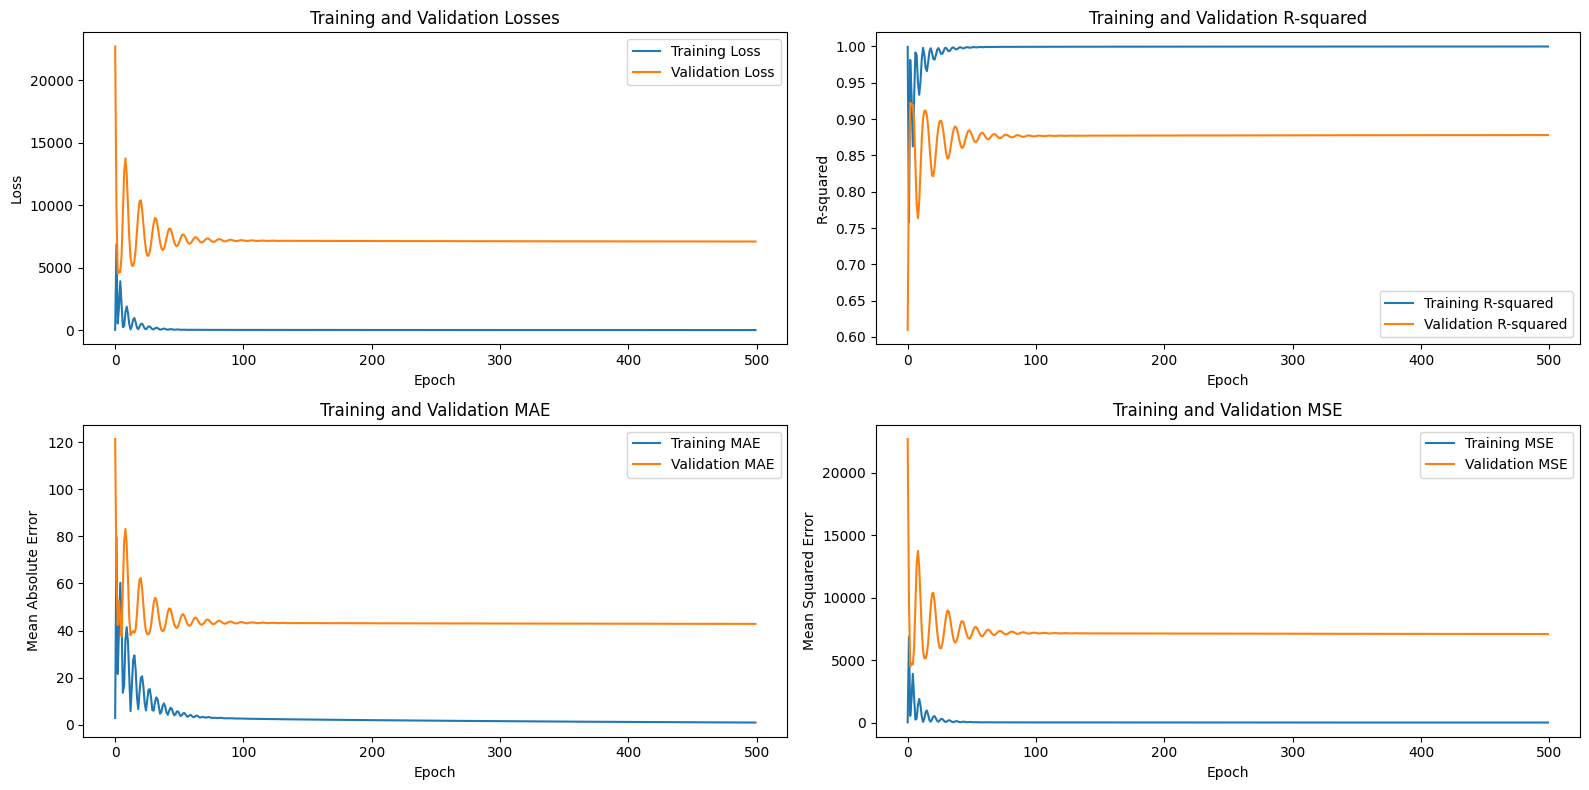

Test Loss: 616.5806884765625, Test R-squared: 0.9722057866332707, Test MAE: 15.420174598693848, Test MSE: 616.5806274414062


In [ ]:
from google.colab import drive
import os
import torch
import joblib
from torch_geometric.nn import SAGEConv
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
model_filename = 'pegnn_model_Paris.pth'  # Custom filename used previously
model_path = os.path.join(drive_path, model_filename)
study_path = os.path.join(drive_path, 'optuna_study_pegnn_Paris.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_Paris.pkl')

# Function to load the model
def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to load input feature size
def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Reload the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_params = loaded_study.best_params
print("Best parameters: ", best_params)

# Reload the input feature size
input_feature_size = load_input_feature_size(input_size_path)

# Define the PEGNN model class
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Assuming train_coords_pegnn, val_coords_pegnn, test_coords_pegnn, train_features_pegnn, val_features_pegnn, and test_features_pegnn are defined
d_model = 128

def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

def position_encoding(coords, d_model):
    pe = torch.zeros((coords.shape[0], d_model))
    for i in range(coords.shape[0]):
        for j in range(d_model // 2):
            pe[i, 2 * j] = torch.sin(coords[i, 0] / (10000 ** (2 * j / d_model)))
            pe[i, 2 * j + 1] = torch.cos(coords[i, 1] / (10000 ** (2 * j / d_model)))
    return pe

edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)
y_train = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn.values, dtype=torch.float).view(-1, 1)

# Load the model with the best hyperparameters
loaded_model = load_model(PEGNN, model_path, input_feature_size, best_params['hidden_channels'], 1)

# Set the model to evaluation mode
loaded_model.eval()

# Create the optimizer and loss function
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

# Train the model and compute metrics
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

loaded_model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = loaded_model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    loaded_model.eval()
    with torch.no_grad():
        out_val = loaded_model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')
    loaded_model.train()

# Save the final model
# save_model(loaded_model, model_path)  # Uncomment if you want to save the model again

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

loaded_model.eval()
with torch.no_grad():
    out_test = loaded_model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')



extra reporting metrics


Test Loss: 0.4837644100189209, Test R-squared: 0.5036542621371958, Test MAE: 0.3656303286552429, Test MSE: 0.4837644100189209


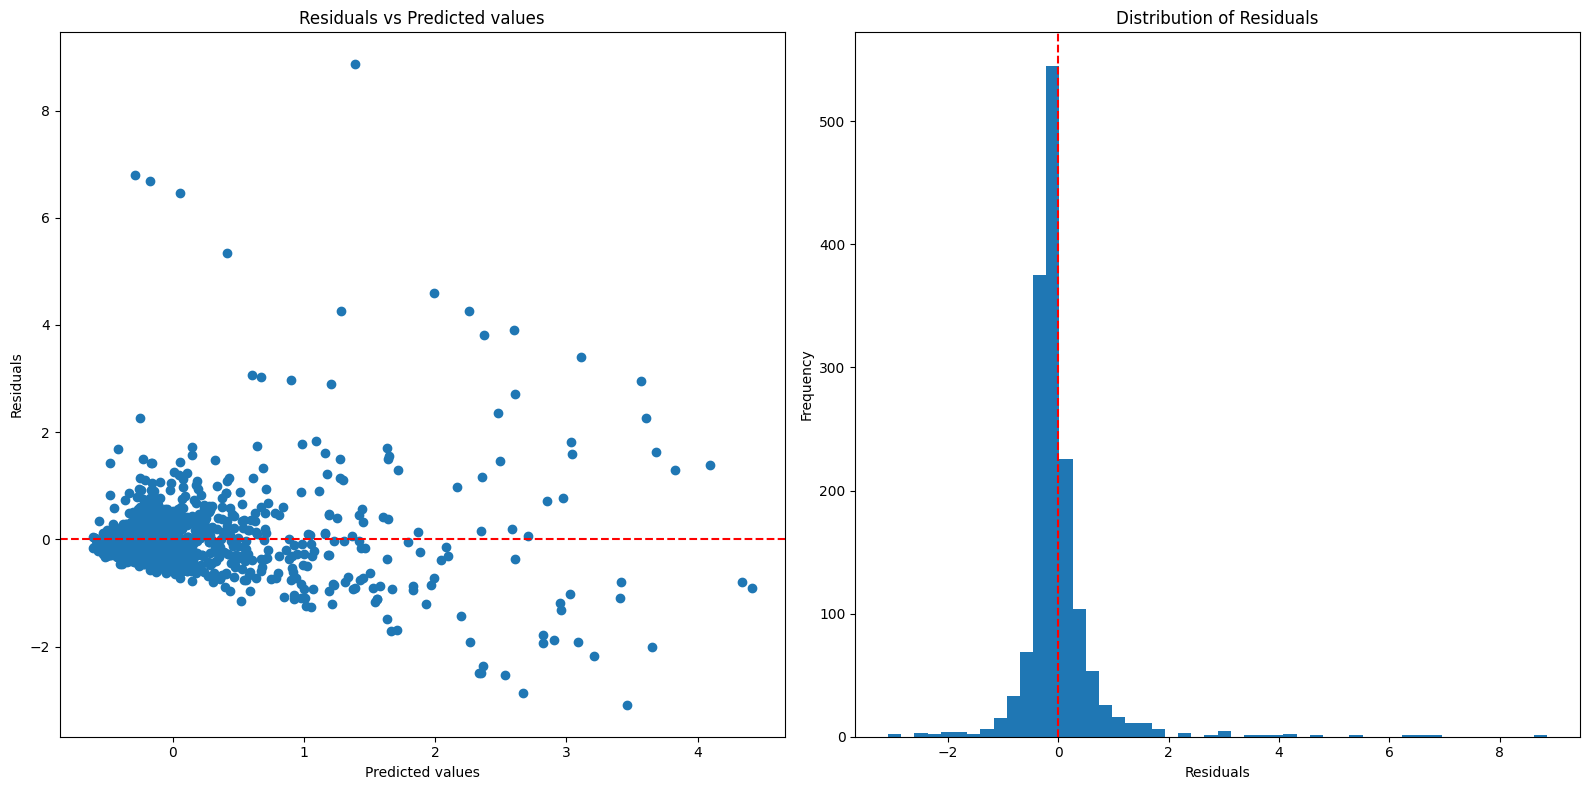

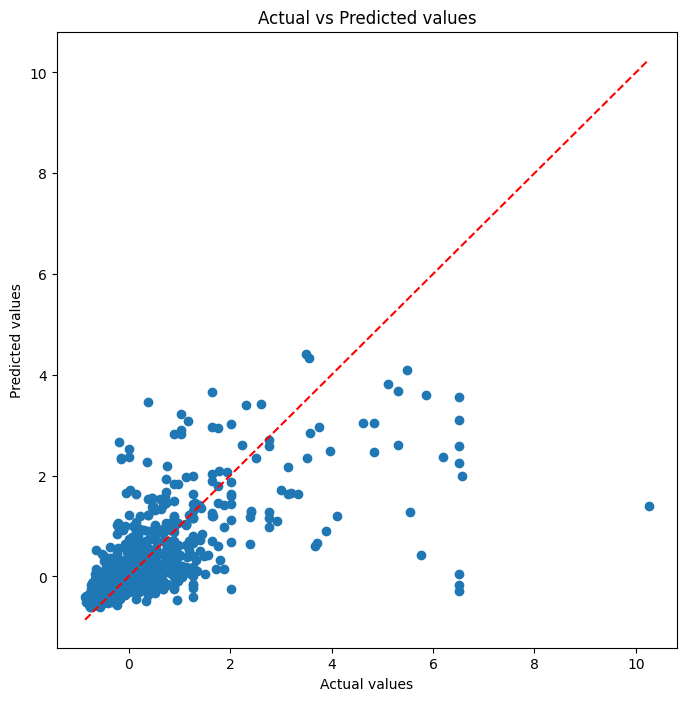

In [49]:
# Plotting residuals
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Plotting residuals
residuals = y_test_np - out_test_np
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(out_test_np, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_np, out_test_np)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')
plt.show()


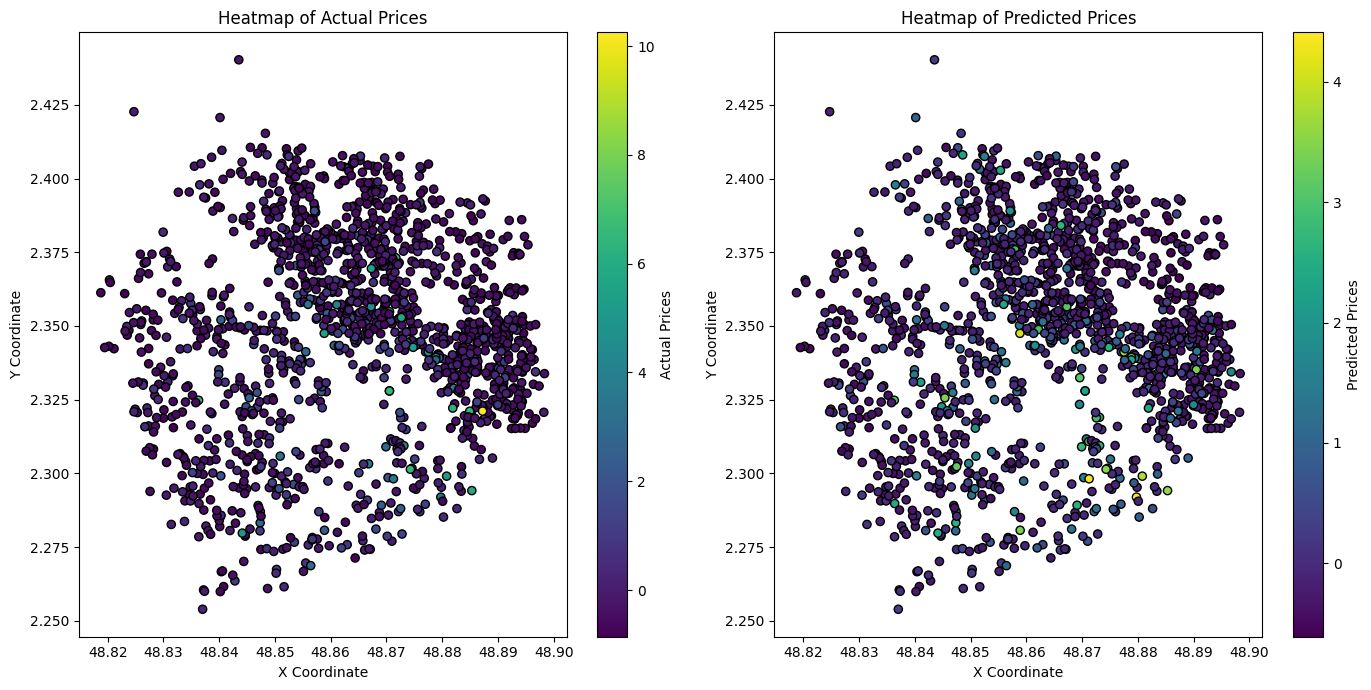

In [50]:
import seaborn as sns

# Plotting heatmaps of actual prices, predicted prices, and residuals
coords_np = np.array(test_coords_pegnn)

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_np, cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_np, cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


plt.tight_layout()
plt.show()



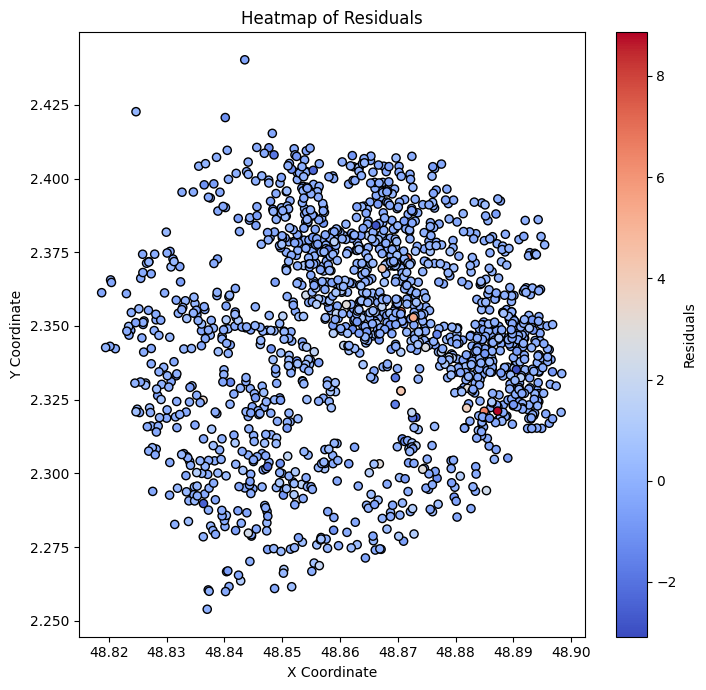

In [51]:
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals, cmap='coolwarm', s=35, edgecolor='k')
plt.colorbar(label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()

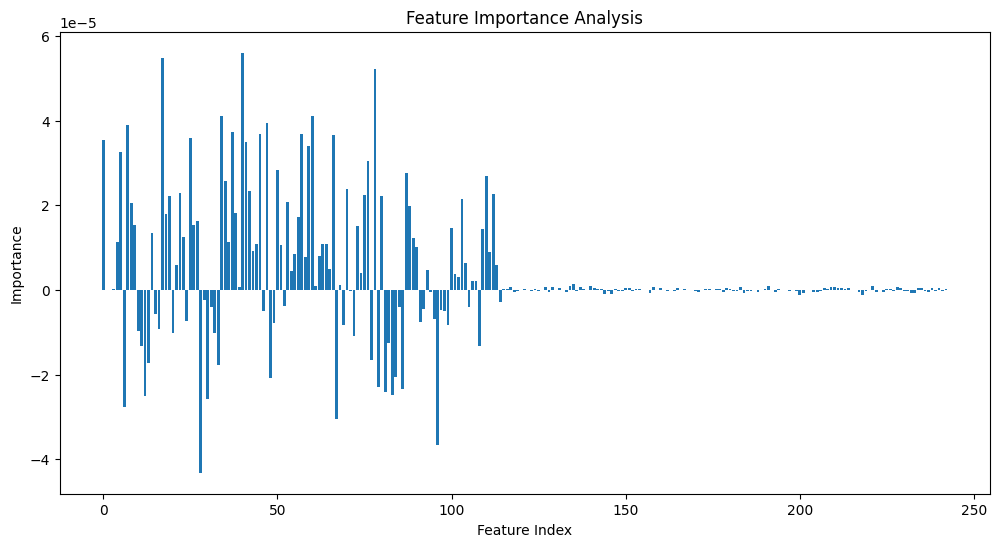

In [53]:
def feature_importance_analysis(model, x_test, edge_index_test, y_test, perturbation=0.01):
    model.eval()
    baseline_preds = model(x_test, edge_index_test).detach().numpy()
    baseline_mse = mean_squared_error(y_test.numpy(), baseline_preds)

    feature_importances = []

    for i in range(x_test.shape[1]):
        x_test_perturbed = x_test.clone()
        x_test_perturbed[:, i] += perturbation

        perturbed_preds = model(x_test_perturbed, edge_index_test).detach().numpy()
        perturbed_mse = mean_squared_error(y_test.numpy(), perturbed_preds)

        importance = perturbed_mse - baseline_mse
        feature_importances.append(importance)

    return feature_importances

# Perform feature importance analysis
feature_importances = feature_importance_analysis(model, x_test, edge_index_test, y_test)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(x_test.shape[1]), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance Analysis')
plt.show()


ik ga nog aanpassen dat de feature names hier bij komen te staan

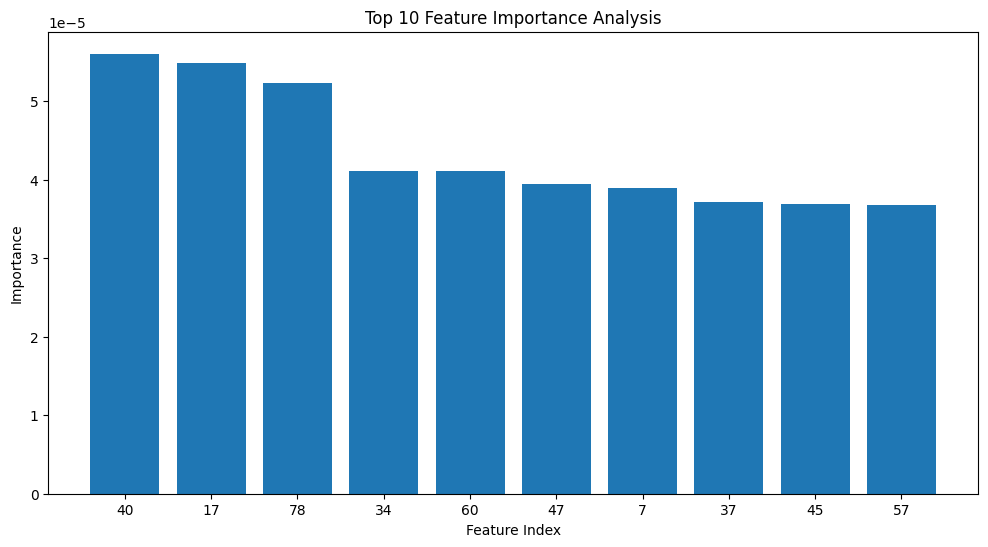

Feature Index: 40, Importance: 5.605816841125488e-05
Feature Index: 17, Importance: 5.486607551574707e-05
Feature Index: 78, Importance: 5.2303075790405273e-05
Feature Index: 34, Importance: 4.1157007217407227e-05
Feature Index: 60, Importance: 4.1097402572631836e-05
Feature Index: 47, Importance: 3.94284725189209e-05
Feature Index: 7, Importance: 3.8951635360717773e-05
Feature Index: 37, Importance: 3.7223100662231445e-05
Feature Index: 45, Importance: 3.68952751159668e-05
Feature Index: 57, Importance: 3.6776065826416016e-05


In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def feature_importance_analysis(model, x_test, edge_index_test, y_test, perturbation=0.01):
    model.eval()
    baseline_preds = model(x_test, edge_index_test).detach().numpy()
    baseline_mse = mean_squared_error(y_test.numpy(), baseline_preds)

    feature_importances = []

    for i in range(x_test.shape[1]):
        x_test_perturbed = x_test.clone()
        x_test_perturbed[:, i] += perturbation

        perturbed_preds = model(x_test_perturbed, edge_index_test).detach().numpy()
        perturbed_mse = mean_squared_error(y_test.numpy(), perturbed_preds)

        importance = perturbed_mse - baseline_mse
        feature_importances.append((i, importance))

    return feature_importances

# Perform feature importance analysis
feature_importances = feature_importance_analysis(model, x_test, edge_index_test, y_test)

# Sort features by importance
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Get top 10 features
top_features = feature_importances[:10]
top_indices = [x[0] for x in top_features]
top_importances = [x[1] for x in top_features]

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(10), top_importances, tick_label=top_indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance Analysis')
plt.show()

# Print top 10 features and their importances
for idx, importance in top_features:
    print(f'Feature Index: {idx}, Importance: {importance}')
